# Eco-Emosphere

### "What can we learn about climate change through sentiment analysis across different social media platforms?"

## Data Acquisition

*Some data acquisition/pre-processing were done in my IDE, due to free Google Colab's RAM limitations. The relevant code will still be included, but the cell will not be executed

More rationale/detail are on presentation slides, and are noted at the start which slide/s the cell refers to

I deleted most cell outputs, since they make the file reallllllly long, but left some to preserve some examples

### [Reddit Climate Change Comments Data from Kaggle](https://www.kaggle.com/datasets/pavellexyr/the-reddit-climate-change-dataset)

In [ ]:
reddit_df = pd.read_csv("C:\Users\Andrew\Desktop\reddit_climatechange_comments_og.csv")
reddit_df.insert(0, "comment_date", pd.to_datetime(reddit_df["created_utc"], unit="s").dt.date)
# Slide 6: Dropped, used, renamed variables
reddit_df.drop(labels=["type", "id", "subreddit.id", "subreddit.nsfw", "created_utc", "sentiment"], axis=1, inplace=True)
# Slide 5: Data Period Granularity
reddit_df = reddit_df[(reddit_df["comment_date"] >= pd.to_datetime("2018-08-01").date()) & (reddit_df["comment_date"] <= pd.to_datetime("2022-08-01").date())].reset_index(labels=["index"], axis=1)
reddit_df = reddit_df.sort_values(by='comment_date', ascending=True).reset_index(drop=True)
# Feather/Arrow more lightweight & memory-efficient than csv
reddit_df.to_feather(r"C:\Users\Andrew\Desktop\reddit_climatechange_comments.arrow")

### Facebook-Scraper Library

1. Get cookies from [Chrome extension](https://chrome.google.com/webstore/detail/get-cookiestxt-locally/cclelndahbckbenkjhflpdbgdldlbecc/related), exported as netscape
2. Worked pretty well a few times, but perhaps due to scraping too fast, got "Temporarily banned"
3. Consequently, encountered errors "facebook_scraper.page_iterators:No raw posts (<article> elements) were found in this page" which prevented any further data acquisition from Facebook.

They are known issues on Github and Stackoverflow.

In [ ]:
# !pip install git+https://github.com/kevinzg/facebook-scraper.git
from datetime import datetime
import pandas as pd
from facebook_scraper import get_posts
import time

fb_comments = []
start_date = datetime(2018, 8, 1)
end_date = datetime(2022, 8, 1)
# Slide 7: Dropped, used, renamed variables
# comments_full -> comment_time, commenter_url, comment_text, comment_reaction_count  + replies -> ...
sources = ['UNclimatechange', "NASAClimateChange", "248515288542048"]

for source in sources:
  # latest_date=start_date
    for post in get_posts(source, cookies="www.facebook.com_cookies.txt", pages=5, options={"comments": True}):
      time.sleep(1)
      if start_date <= post["time"] <= end_date:
        for comment in post["comments_full"]:
            fb_comments.append({"comment_date": comment["comment_time"], "source": source, "link": comment["commenter_url"],
                               "body": comment["comment_text"], "likes": comment["comment_reaction_count"]})
            print(
                f"Retrieved {comment['comment_id']} for {post['post_id']} by {source} on {post['time']}")
      else:
        print(f"SKIPPING {post['time']}")

fb_df = pd.DataFrame(fb_comments)
print(fb_df)
print(len(fb_comments))
fb_df.to_csv("facebook_climatechange_comments.csv")

### Youtube

Information
- Quota: 10000/day/API Key, resets daily 12am UST

1. [Search](https://developers.google.com/youtube/v3/docs/search/list) to search term “climate change” -> list of videos with videoIDs

Information
- Cost: 100 per call for max 50 results/page

In [ ]:
import googleapiclient.discovery

api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = "..."

yt = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)
yt_search_res = yt.search().list(
        part="snippet",
        q="climate change",
        order="relevance",
        publishedAfter="2018-08-01T00:00:00Z",
        publishedBefore="2022-08-01T00:00:00Z",
        safeSearch="none",
        maxResults=50,
    ).execute()
yt_vids = yt_search_res["items"]

# Results are paginated
while yt_search_res.get('nextPageToken'):
  yt_search_res = yt.search().list(part="snippet", q="climate change", order="relevance", publishedAfter="2018-08-01T00:00:00Z", publishedBefore="2022-08-01T00:00:00Z", safeSearch="none", maxResults=50, pageToken=yt_search_res["nextPageToken"]).execute()
  yt_vids.extend(yt_search_res['items'])

yt_vids_ids = []
for yt_vid in yt_vids:
  try:
    yt_vids_ids.append(yt_vid["id"]["videoId"])
  except KeyError:
    pass

print(len(yt_vids_ids), yt_vids_ids)

2. [CommentThread](https://developers.google.com/youtube/v3/docs/commentThreads/list) to extract all commentThreads (top-level comments) per videoID

Information
- Cost: 1 per call for max 100 results/page
- Can specify part="snippet,replies", but only top 5 as shown on video page, not all replies

In [ ]:
yt_commentThreads = []
for yt_vid_id in yt_vids_ids:
  try:
    yt_commentThread_res = yt.commentThreads().list(
            part="snippet",
            videoId=yt_vid_id,
            maxResults=100,
            order="relevance",
            textFormat="plainText",
        ).execute()
    yt_commentThreads.extend(yt_commentThread_res["items"])

    while yt_commentThread_res.get('nextPageToken'):
        yt_commentThread_res = yt.commentThreads().list(part="snippet,replies",videoId=yt_vid_id,maxResults=100,order="relevance",pageToken=yt_commentThread_res["nextPageToken"]).execute()
        yt_commentThreads.extend(yt_commentThread_res['items'])
        print(yt_vid_id)
  # WARNING:googleapiclient.http:Encountered 403 Forbidden with reason "commentsDisabled"
  except:
    pass

yt_comment_parent_ids = []
yt_comments = []
for yt_commentThread in yt_commentThreads:
  toplevelComment = yt_commentThread["snippet"]["topLevelComment"]
  yt_comment_parent_ids.append(toplevelComment["id"])
  yt_comments.append({"comment_date": toplevelComment['snippet']['updatedAt'], "id": toplevelComment["id"], "link": f"https://www.youtube.com/watch?v={toplevelComment['snippet']['videoId']}", "body": toplevelComment['snippet']['textDisplay'], "like_count": toplevelComment['snippet']['likeCount']})

with open("yt_comment_parent_ids.txt", "w") as file: file.write(str(yt_comment_parent_ids))

3. [Comments](https://developers.google.com/youtube/v3/docs/comments/list) to extract all nested replies per commentThread (API limitation: replies only to top-level comments, not replies to replies yet)

Information
- Cost: 1 per call for max 100 results/page

Most time-consuming stage, there were 147 956 commentThreads from the previous part, thus would have been ~15 days of data collection using 1 API Key.

Thankfully, the API was free to use and didn't require Google Credits on the Google Cloud Console. Therefore I used 6 API Keys to split up the work, and save files to disk to continue the next day, ultimately only taking 3 days.

In [ ]:
import ast
with open("yt_comment_parent_ids.txt", 'r') as file: yt_comment_parent_ids = ast.literal_eval(file.read())

import json
with open("yt_comments.json", "r") as json_file: yt_comments = json.load(json_file)
yt_comments_final1 = yt_comments[:]
len(yt_comments_final1)

In [ ]:
for i, yt_comment_parent_id in enumerate(yt_comment_parent_ids):
  yt_comment_res = yt.comments().list(
          part="snippet",
          parentId=yt_comment_parent_id,
          maxResults=100,
          textFormat="plainText",
      ).execute()
  for yt_comment_res_item in yt_comment_res["items"]:
    yt_comment_res_item = yt_comment_res_item["snippet"]
    yt_comments_final1.append({"comment_date": yt_comment_res_item["updatedAt"], "parentId": yt_comment_res_item["parentId"], "link": "", "body": yt_comment_res_item['textDisplay'], "like_count": yt_comment_res_item['likeCount']})

  while yt_comment_res.get('nextPageToken'):
      yt_comment_res = yt.comments().list(part="snippet",parentId=yt_comment_parent_id,maxResults=100,pageToken=yt_comment_res["nextPageToken"]).execute()
      for yt_comment_res_item in yt_comment_res["items"]:
        yt_comment_res_item = yt_comment_res_item["snippet"]
        yt_comments_final1.append({"comment_date": yt_comment_res_item["updatedAt"], "parentId": yt_comment_res_item["parentId"], "link": "", "body": yt_comment_res_item['textDisplay'], "like_count": yt_comment_res_item['likeCount']})

yt_df = pd.DataFrame(yt_comments_final1)

yt_df.to_csv("yt_df.csv", escapechar='~')
with open("yt_comments.json", "w") as json_file: json.dump(yt_comments_final1, json_file)

yt_df.tail(10)

## Importing, Functions & Overview

In [ ]:
# Necessary importing and setting up|

from google.colab import drive

drive.mount('/content/drive')
FOLDERNAME = "Stanford Summer Session/SOC 128D"

from datetime import datetime
import numpy as np
import pandas as pd
# Polars is faster and more efficient than the traditional pandas
import polars as pl
import matplotlib.pyplot as mplt
import seaborn as sb
import plotnine as pn

mplt.style.use("ggplot")
pl.Config.set_tbl_rows(10)
# For merging dataframes with categorical columns
pl.enable_string_cache(True)

# Annotate on matplotlib plots
def annotate(text, xy, xy_offset, ax=None):
  if ax is not None:
      ax.annotate(text=text,
                xy=xy,
                textcoords="offset points",
                xytext=xy_offset,
                ha='center')
  else:
    mplt.annotate(text=text,
                xy=xy,
                textcoords="offset points",
                xytext=xy_offset,
                ha='center')

# Vader & Flair Sentiments
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
!pip install flair
from flair.data import Sentence
from flair.nn import Classifier

# Most models suggest splitting up into sentences as they are trained on individual sentences, but this is both less accurate and more computationally intensive.
# Can take up to 200 words
def split_text_by_word_limit(text: str, word_limit: int = 200) -> list:
  sentences = nltk.sent_tokenize(text)
  paragraphs = []
  current_paragraph = []
  current_word_count = 0
  for sentence in sentences:
      words = sentence.split()
      sentence_word_count = len(words)
      if current_word_count + sentence_word_count > word_limit:
          paragraphs.append(" ".join(current_paragraph))
          #  Resetting
          current_paragraph = []
          current_word_count = 0
      current_paragraph.append(sentence)
      current_word_count += sentence_word_count
  if current_paragraph:
      paragraphs.append(" ".join(current_paragraph))
  return paragraphs

def get_sentence_score(paragraphs: list, vader_only=False, flair_only=False) -> tuple:
  assert not (vader_only and flair_only)
  if not (vader_only or flair_only):
    vaders = []
    flairs = []
    for paragraph in paragraphs:
      vaders.append(vader.polarity_scores(paragraph)["compound"])

      sentence = Sentence(paragraph)
      flair.predict(sentence)
      try:
        if "POSITIVE" in str(sentence):
          flairs.append(sentence.score)
        else:
          flairs.append(sentence.score * -1)
      except:
        flairs.append(0)

    # Up to 200 words
    if len(vaders) == 1:
          most_polar_vader = vaders[0]
          most_polar_flair = flairs[0]
    else:
        # If need to be broken up into paragraphs, take the most extreme/polar sentiment
        # Slide 102, 103: Implementation Caveats
        if abs(min(vaders)) >= max(vaders):
            most_polar_vader = min(vaders)
        else:
            most_polar_vader = max(vaders)

        if abs(min(flairs)) >= max(flairs):
            most_polar_flair = min(flairs)
        else:
            most_polar_flair = max(flairs)

    return round(most_polar_vader, 2), round(most_polar_flair, 2)

  elif vader_only:
    vaders = [vader.polarity_scores(paragraph)["compound"] for paragraph in paragraphs]
    if len(vaders) == 1:
      return vaders[0]
    elif abs(min(vaders)) >= max(vaders):
      return min(vaders)
    else:
      return max(vaders)

  else:
    flairs = []
    for paragraph in paragraphs:
      sentence = Sentence(paragraph)
      flair.predict(sentence)
      try:
        if "POSITIVE" in str(sentence):
          flairs.append(sentence.score)
        else:
          flairs.append(sentence.score * -1)
      except:
        flairs.append(0)

    if len(flairs) == 1:
      return flairs[0]
    elif abs(min(flairs)) >= max(flairs):
      return min(flairs)
    else:
      return max(flairs)

vader = SentimentIntensityAnalyzer()
flair = Classifier.load('sentiment-fast')

# Slide 23: Peculiarity/Investigation Workflow (Step 2 and 3 Graphs)
def get_graphs(df):
  # Getting sentiments
  df = df.with_columns(
      pl.col("body").apply(split_text_by_word_limit).apply(get_sentence_score).alias("VADER_FLAIR"),
  )
  df = df.select(
      pl.all().exclude("VADER_FLAIR"),
      pl.col("VADER_FLAIR").apply(lambda x: x[0]).alias("VADER").cast(pl.Float32),
      pl.col("VADER_FLAIR").apply(lambda x: x[1]).alias("FLAIR").cast(pl.Float32),
  )

  # Vader & Flair Sentiments vs Time
  vader_date = df.groupby_dynamic('comment_date', every="1d").agg(pl.col('VADER').sum().alias("vader_date_sum"))
  flair_date = df.groupby_dynamic('comment_date', every="1d").agg(pl.col('FLAIR').sum().alias("flair_date_sum"))
  vader_date_sorted = vader_date.sort("vader_date_sum")
  vader_date_filtered_high = vader_date_sorted.tail(3)
  vader_date_filtered_low = vader_date_sorted.head(3)
  flair_date_sorted = flair_date.sort("flair_date_sum")
  flair_date_filtered_high = flair_date_sorted.tail(3)
  flair_date_filtered_low = flair_date_sorted.head(3)

  fig, axes = mplt.subplots(2, 1, figsize=(22, 10))
  axes[0].plot(vader_date["comment_date"], vader_date["vader_date_sum"], color='black')
  axes[0].scatter(vader_date_filtered_high["comment_date"], vader_date_filtered_high["vader_date_sum"], color='green', label="3 Highest Vader Sentiment")
  axes[0].scatter(vader_date_filtered_low["comment_date"], vader_date_filtered_low["vader_date_sum"], color='red', label="3 Lowest Vader Sentiment")
  axes[0].set_ylabel('Vader Sentiment')
  axes[0].legend()
  axes[1].plot(flair_date["comment_date"], flair_date["flair_date_sum"], color='black')
  axes[1].scatter(flair_date_filtered_high["comment_date"], flair_date_filtered_high["flair_date_sum"], color='green', label="3 Highest Flair Sentiment")
  axes[1].scatter(flair_date_filtered_low["comment_date"], flair_date_filtered_low["flair_date_sum"], color='red', label="3 Lowest Flair Sentiment")
  axes[1].set_ylabel('Flair Sentiment')
  axes[1].legend()
  fig.supxlabel("Date")
  mplt.suptitle("Vader & Flair Sentiments vs Time")

  for filtered_df, ax in [(vader_date_filtered_high, axes[0]), (vader_date_filtered_low, axes[0]), (flair_date_filtered_high, axes[1]), (flair_date_filtered_low, axes[1])]:
    for comment_date, sentiment in filtered_df.iter_rows():
      annotate(text=comment_date.strftime('%Y-%m-%d'),
              xy=(comment_date, sentiment),
              xy_offset=(-35, -4), ax=ax)

  mplt.show()

  # Subreddit vs Vader Sentiment
  vader_subreddit = df.groupby('subreddit.name').agg(pl.col('VADER').sum().alias("vader_subreddit_sum")).sort("vader_subreddit_sum")
  vader_subreddit_filtered_high = vader_subreddit.tail(5)
  vader_subreddit_filtered_low = vader_subreddit.head(5).sort("vader_subreddit_sum", descending=True)

  fig, axes = mplt.subplots(1, 2, figsize=(22, 6))
  axes[0].barh(vader_subreddit_filtered_high["subreddit.name"], vader_subreddit_filtered_high["vader_subreddit_sum"], color='green')
  axes[1].barh(vader_subreddit_filtered_low["subreddit.name"], vader_subreddit_filtered_low["vader_subreddit_sum"], color='red')
  fig.supylabel("Subreddits")
  fig.supxlabel('Vader Sentiment')
  mplt.suptitle("Subreddit vs Vader Sentiment")
  mplt.show()

  return vader_date, flair_date, vader_subreddit

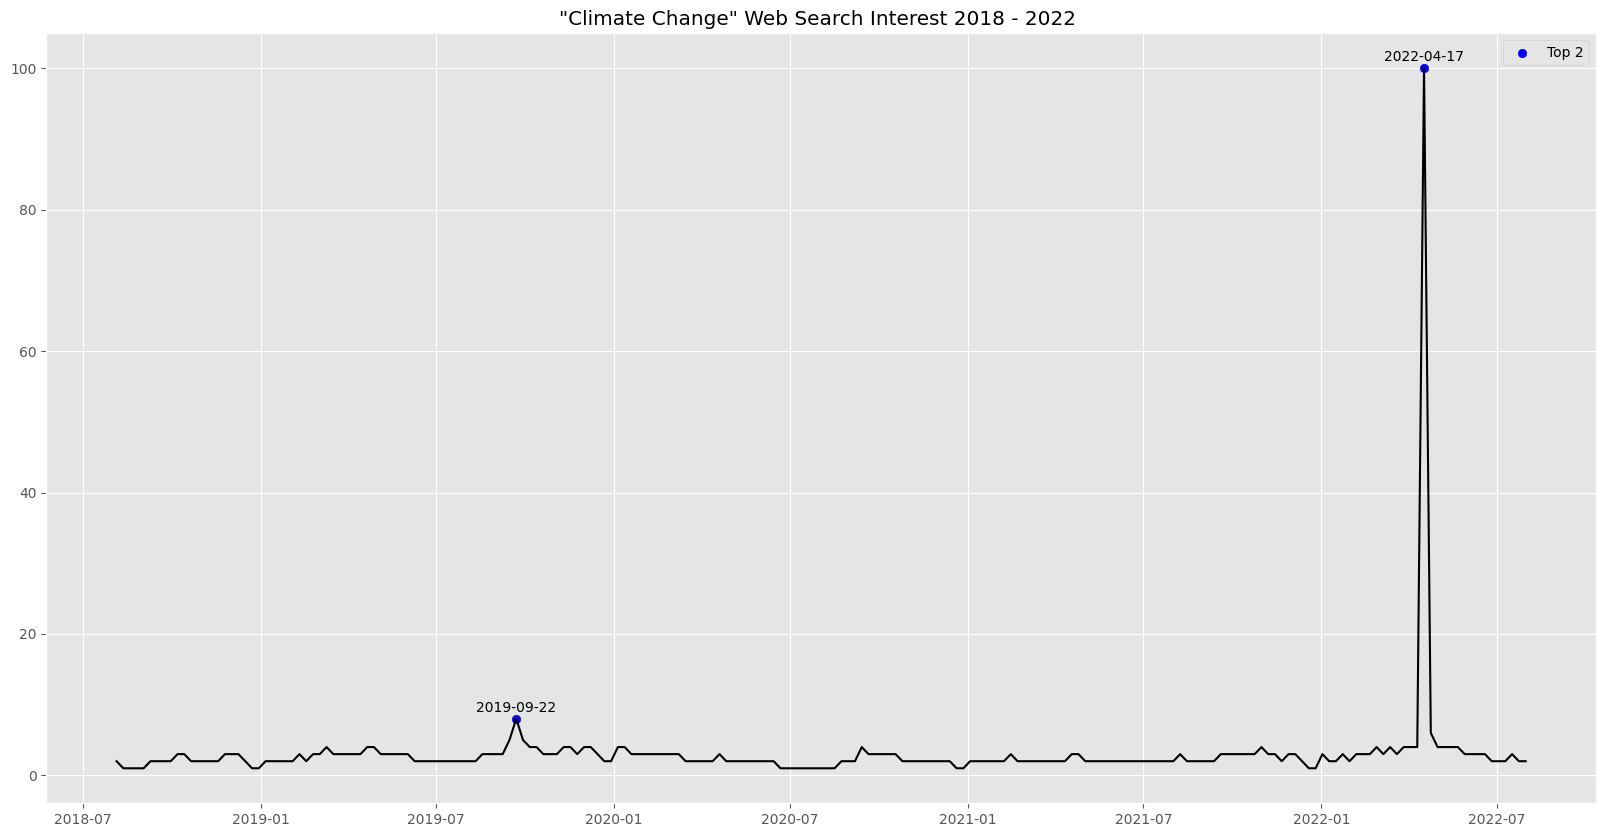

In [ ]:
# Slides 12-16: Google Search Interest by keyword, country, metro, city, related topics
# !pip install pytrends
from pytrends.request import TrendReq

requests_args = {
    "headers": {
      "Host": "trends.google.com",
      "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:109.0) Gecko/20100101 Firefox/111.0",
      "Accept": "application/json, text/plain, */*",
      "Accept-Language": "en-US,en;q=0.5",
      "Accept-Encoding": "gzip, deflate, br",
      "Alt-Used": "trends.google.com",
      "Connection": "keep-alive",
      "Referer": "https://trends.google.com/",
      "Cookie": "...",
      "Sec-Fetch-Dest": "empty",
      "Sec-Fetch-Mode": "cors",
      "Sec-Fetch-Site": "same-origin",
      "TE": "trailers"
  }
}

pytrends = TrendReq(hl='en-US', tz=360, requests_args=requests_args)
kw_list = ["Climate Change"]
fig, ax = mplt.subplots(figsize=(20,10))
for kw in kw_list:
  pytrends.build_payload(kw_list, timeframe='2018-08-01 2022-08-01', cat=0)
  hk_df = pytrends.interest_over_time()
  ax.plot(hk_df.index, hk_df[kw], color="black")
  top_2_df = hk_df.nlargest(2, columns="Climate Change")
  ax.scatter(top_2_df.index, top_2_df["Climate Change"], label="Top 2", color="blue")
  for i, row in top_2_df.iterrows():
    annotate(text=i.strftime('%Y-%m-%d'),
          xy=(i, row["Climate Change"]),
          xy_offset=(0, 5))

ax.set_title('"Climate Change" Web Search Interest 2018 - 2022 ')
mplt.legend()
mplt.show()

<BarContainer object of 20 artists>

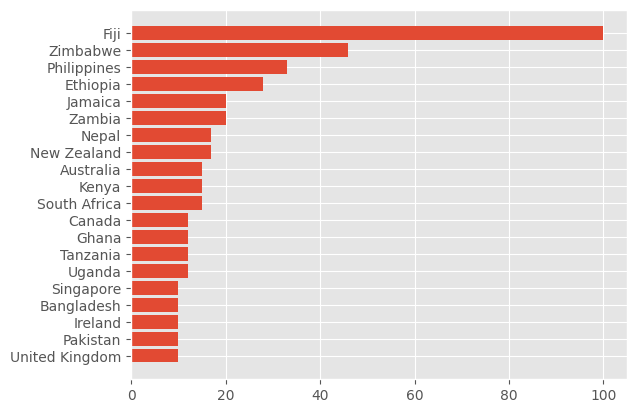

In [ ]:
# Uses same timeframe from pytrends.build_payload above
hk_by_region_df = pytrends.interest_by_region(resolution='COUNTRY', inc_geo_code=False).nlargest(20, ["Climate Change"], keep="all").sort_values(by="Climate Change", ascending=True)
mplt.barh(hk_by_region_df.index, hk_by_region_df["Climate Change"])

<BarContainer object of 23 artists>

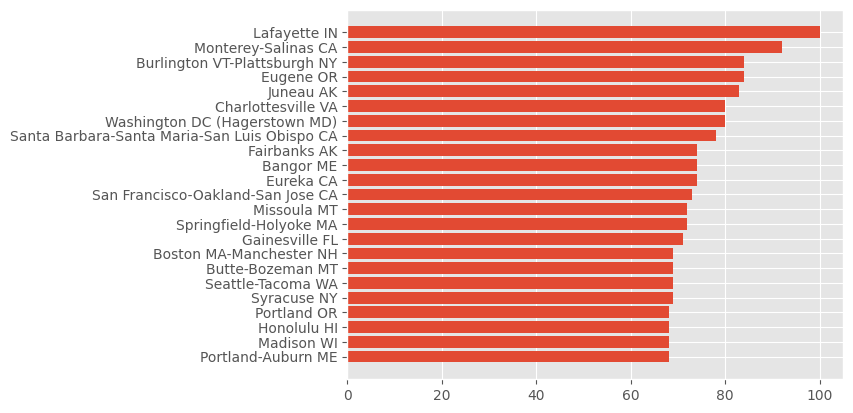

In [ ]:
hk_by_metro_df = pytrends.interest_by_region(resolution='DMA', inc_geo_code=False).nlargest(20, ["Climate Change"], keep="all").sort_values(by="Climate Change", ascending=True)
mplt.barh(hk_by_metro_df.index, hk_by_metro_df["Climate Change"])

<BarContainer object of 12 artists>

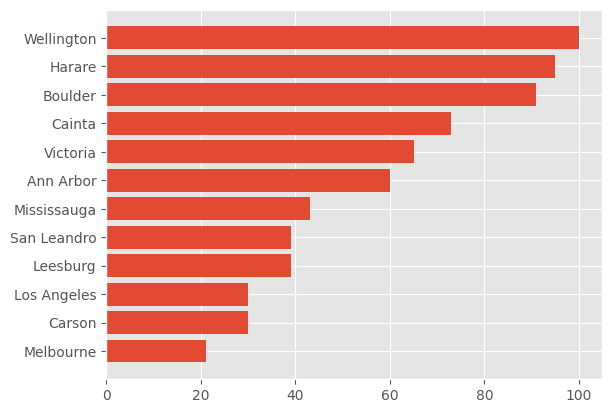

In [ ]:
hk_by_city_df = pytrends.interest_by_region(resolution='CITY', inc_geo_code=False).nlargest(12, ["Climate Change"], keep="all").sort_values(by="Climate Change", ascending=True)
mplt.barh(hk_by_city_df.index, hk_by_city_df["Climate Change"])

In [ ]:
pytrends.related_topics()["Climate Change"]["rising"].drop(columns=["formattedValue", "link", "topic_mid"])

value                                    topic_title         topic_type
0   51550                                      important              Topic
1   35550                                 Greta Thunberg   Swedish activist
2   28350                                     succeeding              Topic
3   27550                                          other              Topic
4   21700                                            cut              Topic
5    2150                                        Brainly  Education company
6    1500                                  Strike action              Topic
7     600                                         People              Topic
8     350                                        Protest              Topic
9     350  2021 United Nations Climate Change Conference              Topic
10    160                                       Wildfire      Disaster type
11    120                                 Global warming     Field of study
12    120                                           Fact              Topic

In [ ]:
pytrends.related_queries()["Climate Change"]["rising"]

query  value
0                                      greta thunberg  22850
1                                greta climate change  17750
2                                 climate change 2019   6000
3                                            quillbot   5750
4                               climate change strike   1000
5                                   paraphrasing tool    950
6            what is climate change simple definition    550
7                        climate change is real shirt    400
8                              climate change protest    350
9                             climate change protests    300
10                                          earth day    200
11                   climate change performance index    140
12                             climate change meaning    130
13                             climate change tagalog    120
14                              climate change poster    100
15                             global warming meaning     80
16                             ano ang climate change     80
17                           climate change paragraph     70
18                           un climate change report     70
19                         how to stop climate change     70
20                            what is climate change?     60
21  ministry of environment forest and climate change     60
22                    why is climate change important     50
23                              climate change slogan     50
24                                      social issues     50

## Reddit

In [ ]:
%%time
reddit_df = pl.read_ipc(f"drive/My Drive/{FOLDERNAME}/data/reddit_climatechange_comments.arrow")
reddit_df = reddit_df.with_columns(pl.col(["subreddit.name", "permalink"]).cast(pl.Categorical), pl.col("score").cast(pl.Int32))
reddit_df

CPU times: user 8.39 s, sys: 10.7 s, total: 19.1 s
Wall time: 37.1 s


shape: (3_237_761, 5)
┌─────────────────────┬──────────────────┬────────────────────────┬────────────────────────┬───────┐
│ comment_date        ┆ subreddit.name   ┆ permalink              ┆ body                   ┆ score │
│ ---                 ┆ ---              ┆ ---                    ┆ ---                    ┆ ---   │
│ datetime[ns]        ┆ cat              ┆ cat                    ┆ str                    ┆ i32   │
╞═════════════════════╪══════════════════╪════════════════════════╪════════════════════════╪═══════╡
│ 2018-08-01 00:00:00 ┆ unpopularopinion ┆ https://old.reddit.com ┆ That's what we worried ┆ 3     │
│                     ┆                  ┆ /r/unpopul…            ┆ about wit…             ┆       │
│ 2018-08-01 00:00:00 ┆ iama             ┆ https://old.reddit.com ┆ Hi Andrew! I was       ┆ 1     │
│                     ┆                  ┆ /r/IAmA/co…            ┆ curious about w…       ┆       │
│ 2018-08-01 00:00:00 ┆ chapotraphouse   ┆ https://old.reddit.com ┆                        ┆ 2     │
│                     ┆                  ┆ /r/ChapoTr…            ┆ &gt;How are the core   ┆       │
│                     ┆                  ┆                        ┆ ideas behi…            ┆       │
│ 2018-08-01 00:00:00 ┆ europe           ┆ https://old.reddit.com ┆ Nonono climate change  ┆ 1     │
│                     ┆                  ┆ /r/europe/…            ┆ just start…            ┆       │
│ 2018-08-01 00:00:00 ┆ science          ┆ https://old.reddit.com ┆ Canada. Forest fires   ┆ 7     │
│                     ┆                  ┆ /r/science…            ┆ and heatwav…           ┆       │
│ …                   ┆ …                ┆ …                      ┆ …                      ┆ …     │
│ 2022-08-01 00:00:00 ┆ magictruffle     ┆ https://old.reddit.com ┆ I am glad you liked it ┆ 1     │
│                     ┆                  ┆ /r/MagicTr…            ┆ and had a…             ┆       │
│ 2022-08-01 00:00:00 ┆ ark              ┆ https://old.reddit.com ┆ You bought a game to   ┆ 11    │
│                     ┆                  ┆ /r/ARK/com…            ┆ play on ser…           ┆       │
│ 2022-08-01 00:00:00 ┆ environment      ┆ https://old.reddit.com ┆ ***From reporters      ┆ 1     │
│                     ┆                  ┆ /r/environ…            ┆ Meghan McDonou…        ┆       │
│ 2022-08-01 00:00:00 ┆ worldnews        ┆ https://old.reddit.com ┆ This is the problem    ┆ 7     │
│                     ┆                  ┆ /r/worldne…            ┆ with the gre…          ┆       │
│ 2022-08-01 00:00:00 ┆ politics         ┆ https://old.reddit.com ┆ None of the others     ┆ 17    │
│                     ┆                  ┆ /r/politic…            ┆ have the bott…         ┆       │
└─────────────────────┴──────────────────┴────────────────────────┴────────────────────────┴───────┘

Available files:

- reddit_climatechange_comments (Raw)
- r_sentence.drop("VADER", "FLAIR", axis=1) for r_lex (Lexicon-based sentiment
(AFINN, NRC))
- r_sentence (Sentence-based Sentiment (VADER, Flair))
- r_perspective (In-depth toxicity analysis (Perspective API))


#### Exploratory

In [ ]:
# Slide 100: Implementation Caveat
# Checking no.of duplicates
duplicate_comments = reddit_df.select(pl.col("body"))
duplicate_comments.filter(duplicate_comments.is_duplicated())

shape: (107_861, 1)
┌───────────────────────────────────┐
│ body                              │
│ ---                               │
│ str                               │
╞═══════════════════════════════════╡
│ Climate Change.                   │
│ Main point I’m making is that us… │
│ Main point I’m making is that us… │
│ Here are some other articles abo… │
│ Here are some other articles abo… │
│ …                                 │
│ [97% of Congress is swayed by co… │
│ Code: YKjR2zPFOh                  │
│                                   │
│ Join me and ov…                   │
│ Climate Change                    │
│ *Climate change has entered the … │
│ Bernie considers global warming … │
└───────────────────────────────────┘

In [ ]:
# !pip install wordcloud
from wordcloud import WordCloud
import regex as re
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import TweetTokenizer
nltk.download('punkt')
from string import punctuation, ascii_lowercase
import regex as re
from collections import Counter

with open(f"drive/My Drive/{FOLDERNAME}/data/stopwords_extra.json", "r") as file: stopwords_extra = set(json.load(file))
stopwords_nltk = set(stopwords.words('english'))
# !"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~
# Unicode symbols Eg. ' vs ’
punctuation += "–—― ̳‘’‚‛“”„†‡•...‰′′′‹›!! ̅⁄⁊"
stopwords_punct = set(punctuation)
stopwords_alphabets = set(ascii_lowercase)
combined_stoplist = list(set.union(stopwords_extra, stopwords_nltk, stopwords_punct, stopwords_alphabets))

# As the data was too large, I had to break it up into chunks
wc = WordCloud()
counts_all = Counter()
tokenizer = TweetTokenizer()

for text in reddit_df['body']:
    # Unicode Categories C (Oontrol), M (Mark), P (Punctuation), S (Symbol), Z (Separator) + emojis
    re.compile(r'[\\p{C}|\\p{M}|\\p{P}|\\p{S}|\\p{Z}]+',
               re.UNICODE).sub(" ", text)
    for word in tokenizer.tokenize(text):
        word = word.lower()
        if word not in combined_stoplist and not re.search("\d+", word):
            counts_all.update(wc.process_text(word))

wc.generate_from_frequencies(counts_all)
wc.to_file('reddit_wc.png')

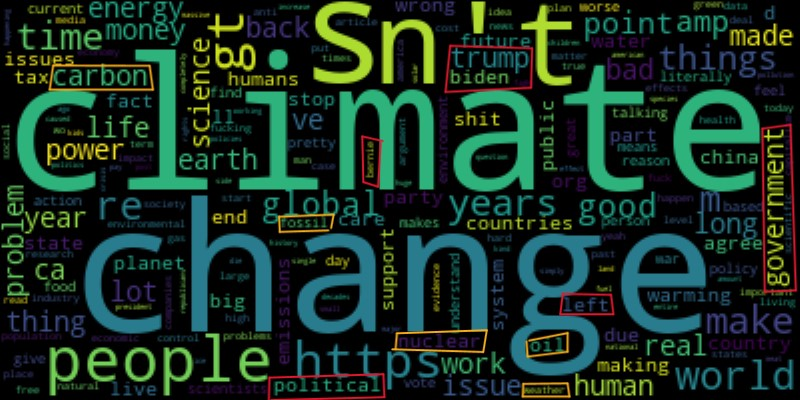

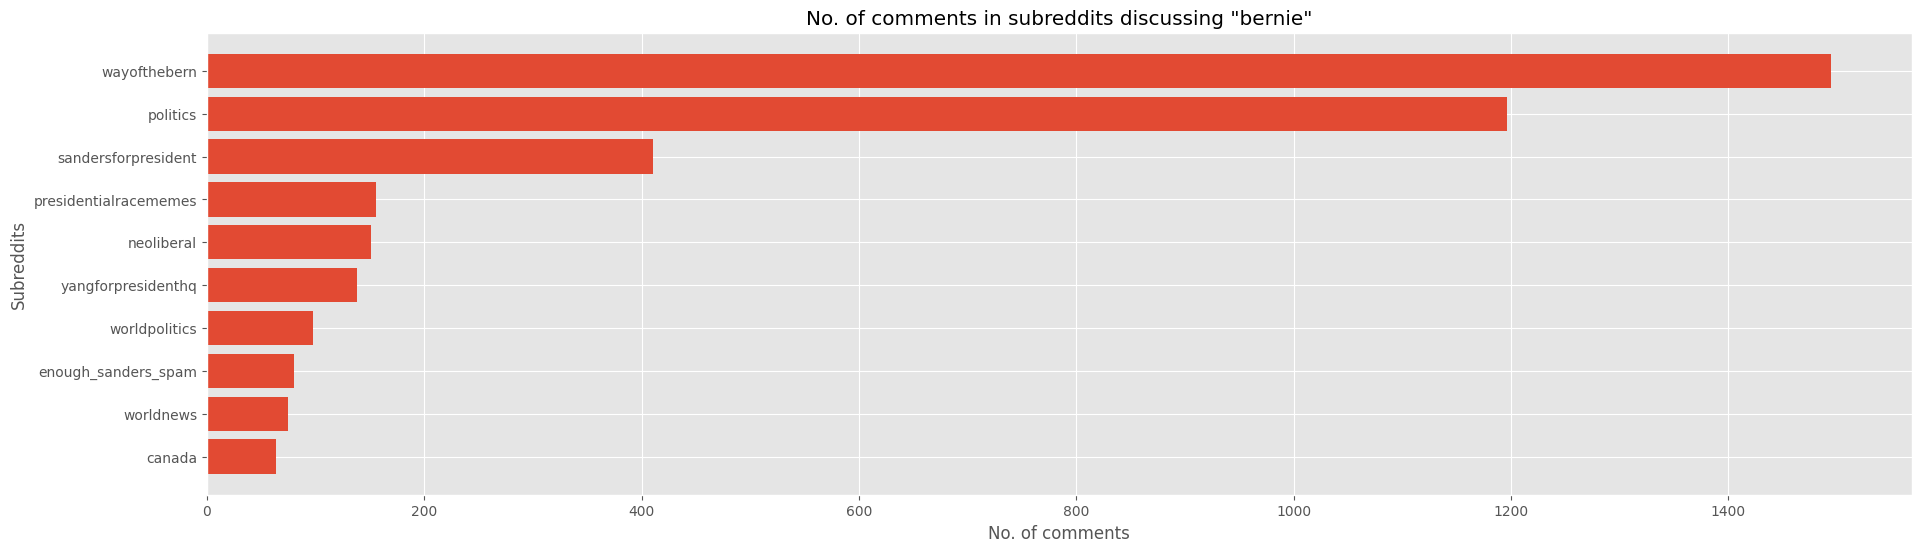

2023-08-09 05:25:49,878 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:25:55,319 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:25:55,391 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:25:55,468 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:25:55,874 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:25:56,346 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:25:56,428 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:26:12,762 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:27:32,296 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:27:33,968 Warning: An empty Sentence was 

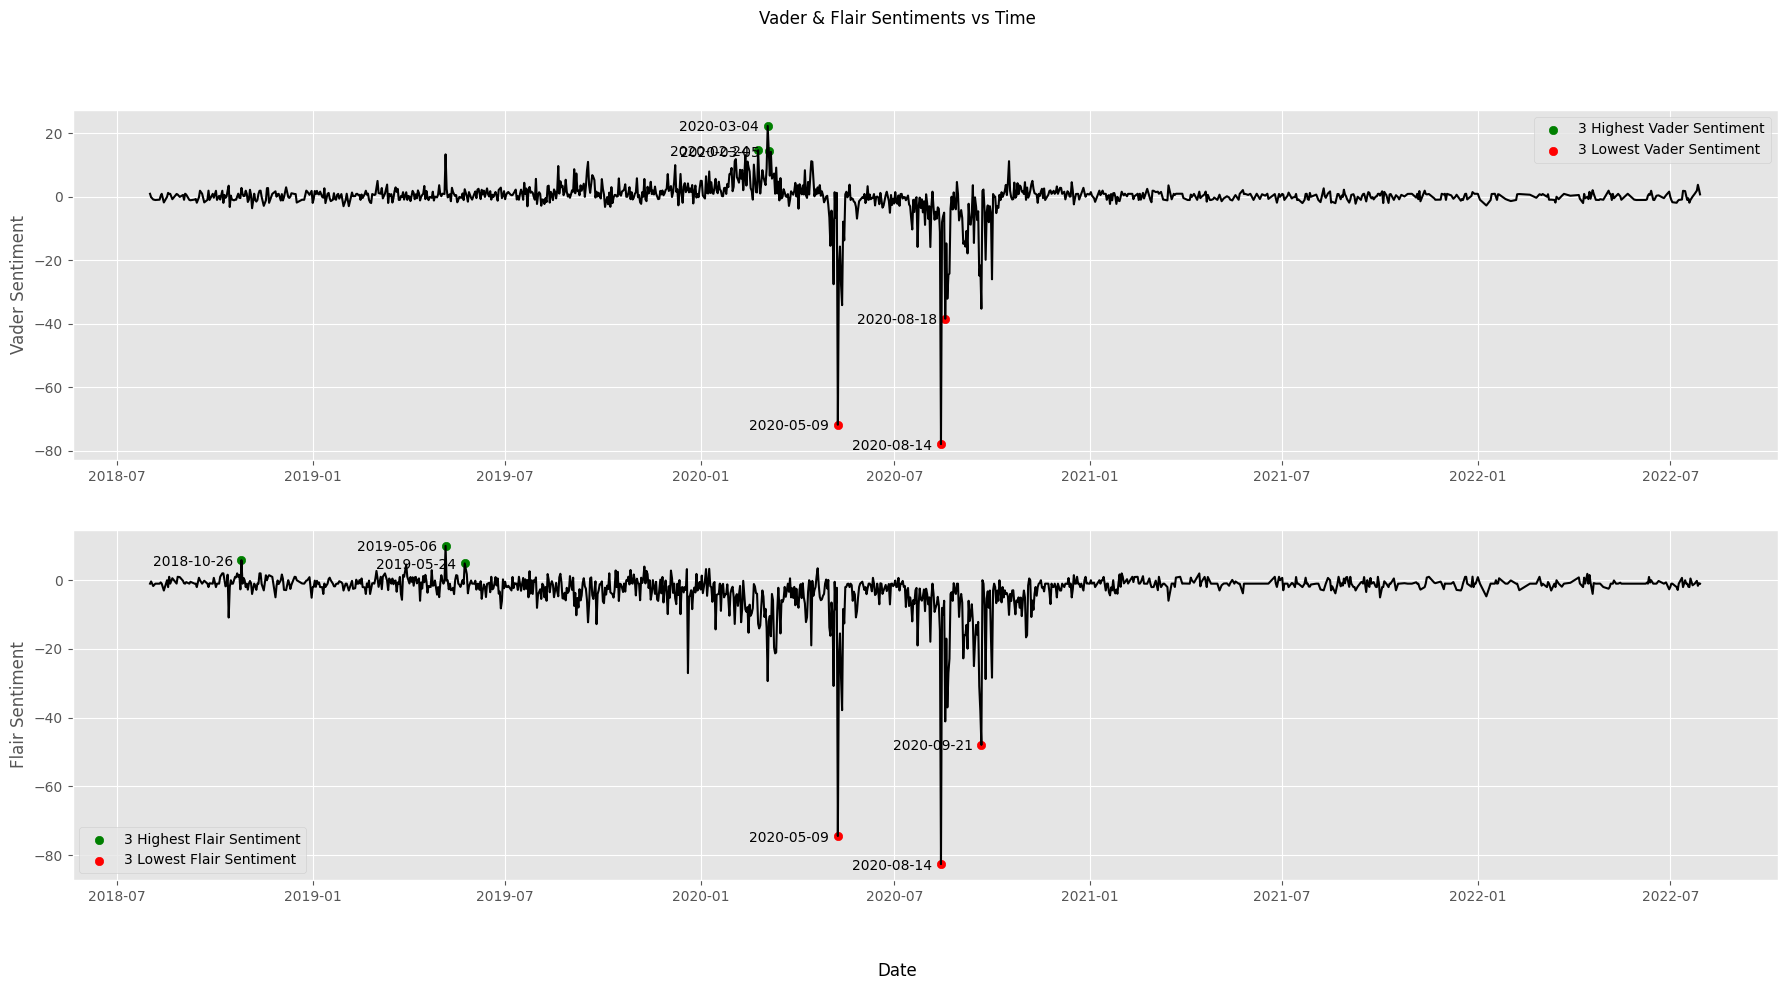

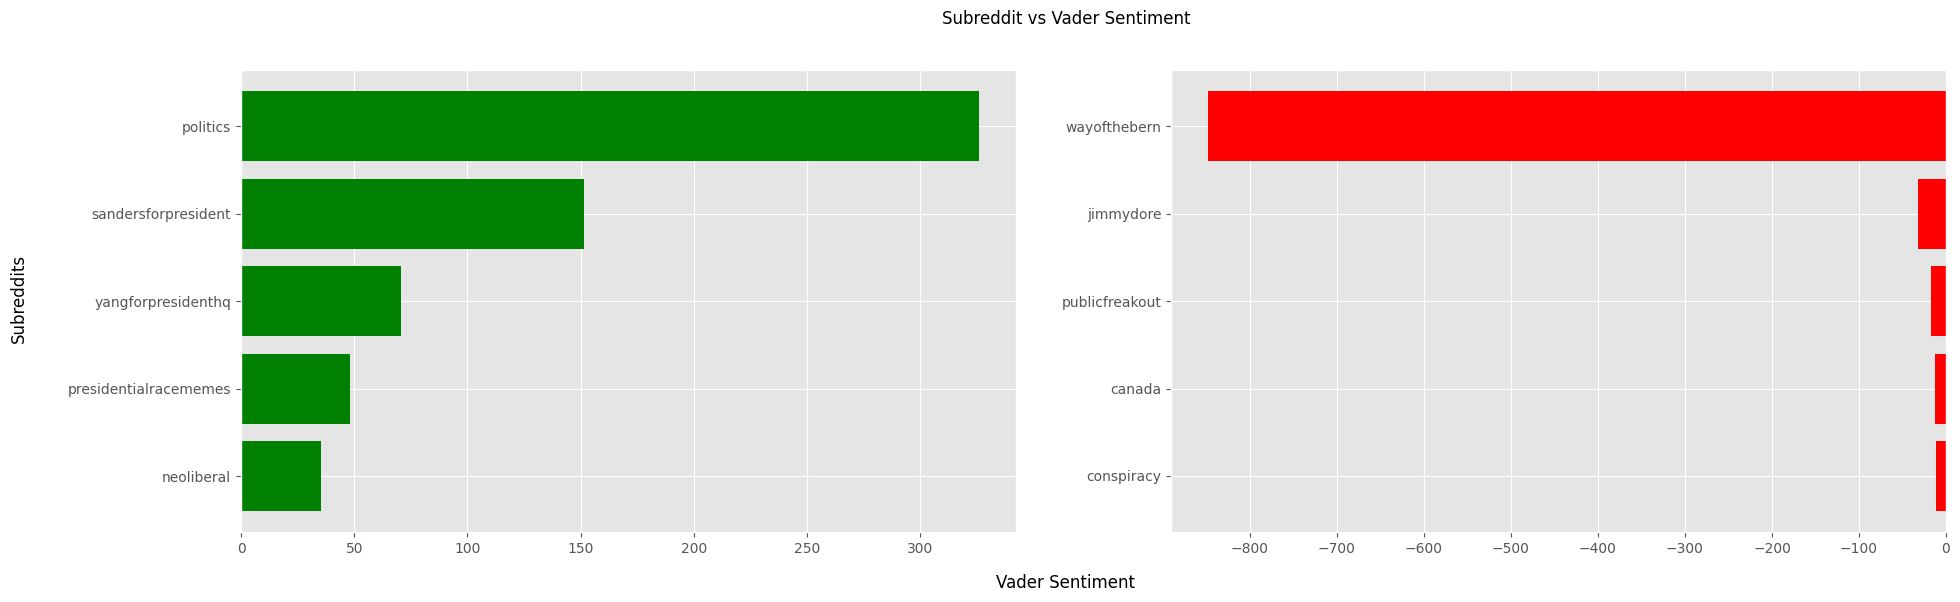

In [ ]:
# Slides 26-31
# Since bernie appeared in the wordcloud and not sanders, searching all comments containing "bernie"
bernie_df = reddit_df.filter(pl.col("body").str.contains("bernie"))
bernie_grped = bernie_df.groupby('subreddit.name').agg(pl.count('body').alias('num_subreddit_comments')).sort("num_subreddit_comments").tail(10)

mplt.figure(figsize=(22, 6))
mplt.barh(bernie_grped["subreddit.name"], bernie_grped["num_subreddit_comments"])
mplt.xlabel('No. of comments')
mplt.ylabel('Subreddits')
mplt.title('No. of comments in subreddits discussing "bernie"')
mplt.show()

get_graphs(bernie_df)

In [ ]:
for a, b, c in bernie_df.filter(pl.col("subreddit.name") == "wayofthebern").select(pl.col("comment_date", "body", "score")).iter_rows(): print(a b, c)

In [ ]:
for a, b, c, d in bernie_df.filter(pl.col("comment_date") == datetime.strptime('2020-05-09', '%Y-%m-%d')).select(pl.col("comment_date", "permalink", "body", "score")).iter_rows(): print(a, b, c, "\n==============")

In [ ]:
bernie_duplicates_df = bernie_df.filter(pl.col("comment_date") == datetime.strptime('2020-05-09', '%Y-%m-%d')).select(pl.col("body"))
print(f"All comments: {bernie_duplicates_df.shape[0]} vs Duplicated comments: {bernie_duplicates_df.filter(bernie_duplicates_df.is_duplicated()).shape[0]}")
bernie_duplicates_df.filter(bernie_duplicates_df.is_duplicated())

All comments: 92 vs Duplicated comments: 87


shape: (87, 1)
┌───────────────────────────────────┐
│ body                              │
│ ---                               │
│ str                               │
╞═══════════════════════════════════╡
│ Trump is to the left of Biden so… │
│ Trump is to the left of Biden so… │
│ Trump is to the left of Biden so… │
│ Trump is to the left of Biden so… │
│ Trump is to the left of Biden so… │
│ …                                 │
│ Trump is to the left of Biden so… │
│ Trump is to the left of Biden so… │
│ Trump is to the left of Biden so… │
│ Trump is to the left of Biden so… │
│ Trump is to the left of Biden so… │
└───────────────────────────────────┘

In [ ]:
for a, b, c in bernie_df.filter(pl.col("comment_date") == datetime.strptime('2020-08-14', '%Y-%m-%d')).select(pl.col("comment_date", "body", "score")).iter_rows(): print(a, b, c, "\n==============")

In [ ]:
bernie_duplicates_df = bernie_df.filter(pl.col("comment_date") == datetime.strptime('2020-08-14', '%Y-%m-%d')).select(pl.col("body"))
print(f"All comments: {bernie_duplicates_df.shape[0]} vs Duplicated comments: {bernie_duplicates_df.filter(bernie_duplicates_df.is_duplicated()).shape[0]}")
bernie_duplicates_df.filter(bernie_duplicates_df.is_duplicated())

All comments: 88 vs Duplicated comments: 83


shape: (83, 1)
┌───────────────────────────────────┐
│ body                              │
│ ---                               │
│ str                               │
╞═══════════════════════════════════╡
│ False talking points galore! Wow… │
│ False talking points galore! Wow… │
│ Biden is against single payer, a… │
│ Biden is against single payer, a… │
│ Biden is against single payer, a… │
│ …                                 │
│ Biden is against single payer, a… │
│ Biden is against single payer, a… │
│ Biden is against single payer, a… │
│ Biden is against single payer, a… │
│ Biden is against single payer, a… │
└───────────────────────────────────┘

In [ ]:
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import TweetTokenizer
nltk.download('punkt')
from string import punctuation, ascii_lowercase
import regex as re
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

# Stopwords
with open(f"drive/My Drive/{FOLDERNAME}/data/stopwords_extra.json", "r") as file: stopwords_extra = set(json.load(file))
stopwords_nltk = set(stopwords.words('english'))
# !"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~
# Unicode symbols Eg. ' vs ’
punctuation += "–—― ̳‘’‚‛“”„†‡•...‰′′′‹›!! ̅⁄⁊"
stopwords_punct = set(punctuation)
stopwords_alphabets = set(ascii_lowercase)
combined_stoplist = list(set.union(stopwords_extra, stopwords_nltk, stopwords_punct, stopwords_alphabets))

# Lemmatization
def get_POS_tags(pos_tag):
  POS_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
  try:
    # Getting first 2 letters of pos_tag
    return POS_tag[pos_tag[:2]]
  except:
    # Fallback to noun (Default)
    return 'n'

class LemmaTokenizer(object):
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, corpus):
    return [self.wnl.lemmatize(word, pos=get_POS_tags(tag)) for word, tag in pos_tag(tokenizer.tokenize(corpus)) if not re.search("\d+", word)]

tokenizer = TweetTokenizer()
tf_vectorizer = CountVectorizer(stop_words=combined_stoplist, tokenizer=LemmaTokenizer())
tf = tf_vectorizer.fit_transform(reddit_df["body"])
print(f"No. of words per topic: {len(tf_vectorizer.get_feature_names_out())}")

# Using GridSearch for optimal number of topics
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA()
model = GridSearchCV(lda, param_grid={'n_components': [2, 4, 6, 8, 10]})
model.fit(tf)

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", model.best_estimator_.perplexity(tf))

No. of words per topic: 3007532
Best Model's Params: {'n_components': 8}
Best Log Likelihood Score: -188474231.7053696
Model Perplexity: 3154.473693879297


In [ ]:
# Slide 32: Topic Modelling
def get_model_topics(model, vectorizer, topics, n_top_words=10, detailed=False):
  word_dict = {}
  words = vectorizer.get_feature_names_out()
  if detailed:
    for topic_i, topic_freq in enumerate(model.components_):
      # Sorting indexes of words by top frequent topics
      top_freq_words_i = topic_freq.argsort()[:-n_top_words - 1:-1]
      # {topic: [(word, word_p), ...]}
      word_dict[topics[topic_i]] = [(words[i], topic_freq[i]/len(topic_freq)) for i in top_freq_words_i]
    return pd.DataFrame([(topic, word, freq) for topic, words in word_dict.items() for word, freq in words], columns=["Topic", "Word", "Probability"])

  else:
    for topic_i, topic_freq in enumerate(model.components_):
      top_freq_words_i = topic_freq.argsort()[:-n_top_words - 1:-1]
      # {topic: [word, ...]}
      word_dict[topics[topic_i]] = [words[i] for i in top_freq_words_i]
    return pd.DataFrame(word_dict)

lda = LDA(n_components=8, random_state=1)
topic_per_document = lda.fit_transform(tf)
word_per_topic = lda.components_

r_topics_words_df = get_model_topics(lda, tf_vectorizer, ["Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5", "Topic 6", "Topic 7", "Topic 8"])
r_topics_words_df

shape: (10, 8)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬────────────┐
│ Topic 1  ┆ Topic 2 ┆ Topic 3 ┆ Topic 4 ┆ Topic 5 ┆ Topic 6 ┆ Topic 7 ┆ Topic 8    │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---        │
│ str      ┆ str     ┆ str     ┆ str     ┆ str     ┆ str     ┆ str     ┆ str        │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════════╡
│ climate  ┆ change  ┆ climate ┆ climate ┆ tax     ┆ time    ┆ change  ┆ people     │
│ change   ┆ climate ┆ change  ┆ state   ┆ pay     ┆ book    ┆ climate ┆ change     │
│ energy   ┆ human   ┆ people  ┆ change  ┆ money   ┆ make    ┆ year    ┆ make       │
│ emission ┆ people  ┆ make    ┆ fire    ┆ cost    ┆ find    ┆ people  ┆ country    │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …          │
│ carbon   ┆ food    ┆ science ┆ area    ┆ company ┆ world   ┆ ...     ┆ thing      │
│ global   ┆ planet  ┆ thing   ┆ global  ┆ year    ┆ story   ┆ bad     ┆ good       │
│ gas      ┆ meat    ┆ party   ┆ day     ┆ policy  ┆ write   ┆ happen  ┆ government │
│ fossil   ┆ thing   ┆ issue   ┆ report  ┆ plan    ┆ comment ┆ world   ┆ work       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴────────────┘

Topic 1: Energy sources

Topic 2: Meat/Veganism

Topic 3: Politics

Topic 5: $$

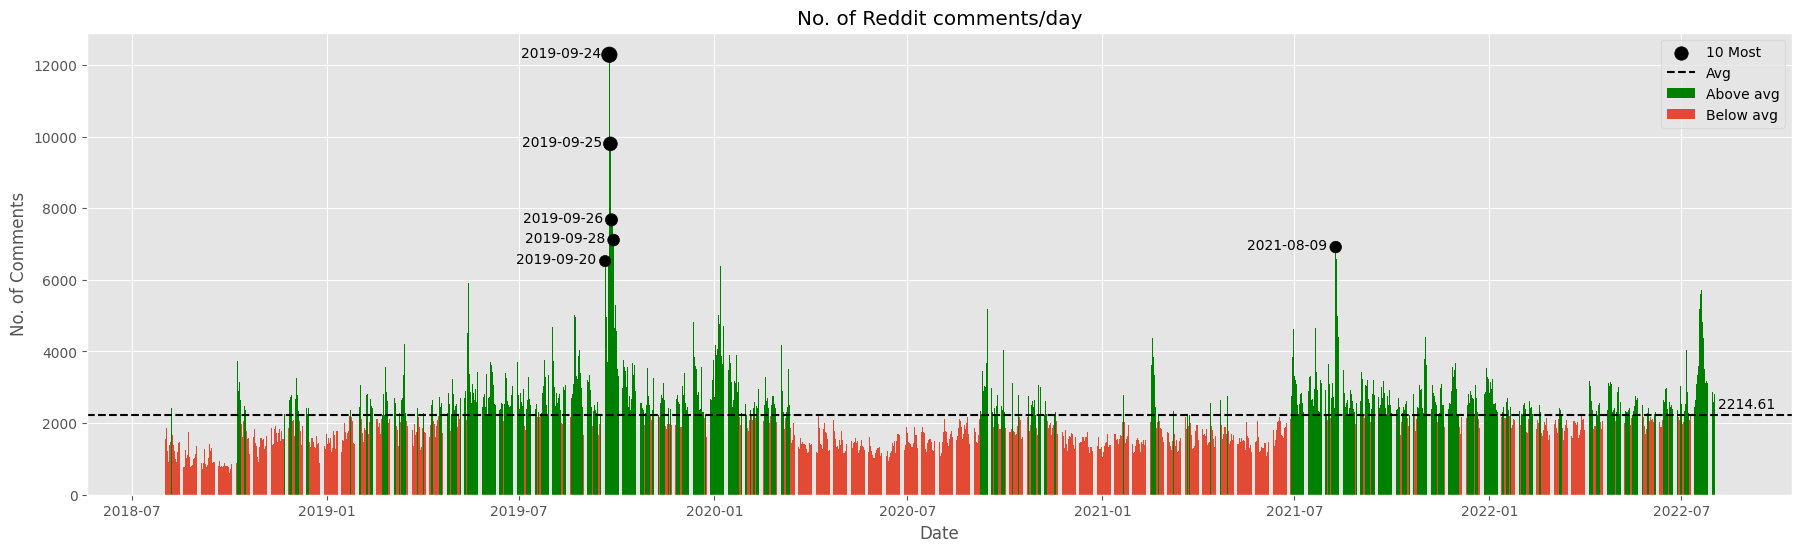

In [ ]:
# Slide 33
r_comments_day = reddit_df.groupby_dynamic('comment_date', every="1d").agg(pl.count('body').alias('num_comments'))
r_avg_comments = r_comments_day['num_comments'].mean()
r_comments_day_above_avg = r_comments_day.filter(r_comments_day['num_comments'] >= r_avg_comments)
r_comments_day_below_avg = r_comments_day.filter(r_comments_day['num_comments'] < r_avg_comments)
# diff() to preserve critical information without information overload Eg. 2019-09-26 (7675) is very close to 2019-09-27 (7696). So plotting one of them is sufficient
r_filtered = r_comments_day.sort("num_comments").tail(10)
r_filtered = r_filtered.filter(r_filtered['num_comments'].diff() >= 100)

mplt.figure(figsize=(22, 6))
mplt.bar(r_comments_day_above_avg['comment_date'], r_comments_day_above_avg['num_comments'], label='Above avg', color="green")
mplt.bar(r_comments_day_below_avg['comment_date'], r_comments_day_below_avg['num_comments'], label='Below avg', color="red")
mplt.scatter(r_filtered['comment_date'], r_filtered['num_comments'], label='10 Most', s=r_filtered['num_comments'] * 0.01, color="black")
mplt.axhline(y=r_avg_comments, color='black', linestyle='--', label='Avg')
annotate(text=round(r_avg_comments, 2),
         xy=(datetime.strptime('2022-09-01', '%Y-%m-%d'), r_avg_comments),
         xy_offset=(0, 5))

for comment_date, num_comments in r_filtered.iter_rows():
  annotate(text=comment_date.strftime('%Y-%m-%d'),
           xy=(comment_date, num_comments),
           xy_offset=(-35, -2))

mplt.xlabel('Date')
mplt.ylabel('No. of Comments')
mplt.title('No. of Reddit comments/day')
mplt.legend()
mplt.show()

2023-08-09 05:38:42,750 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:39:02,609 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:40:06,771 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:41:41,954 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:41:47,675 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:42:24,912 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:42:33,004 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:44:00,030 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:47:50,949 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 05:48:47,341 Warning: An empty Sentence was 

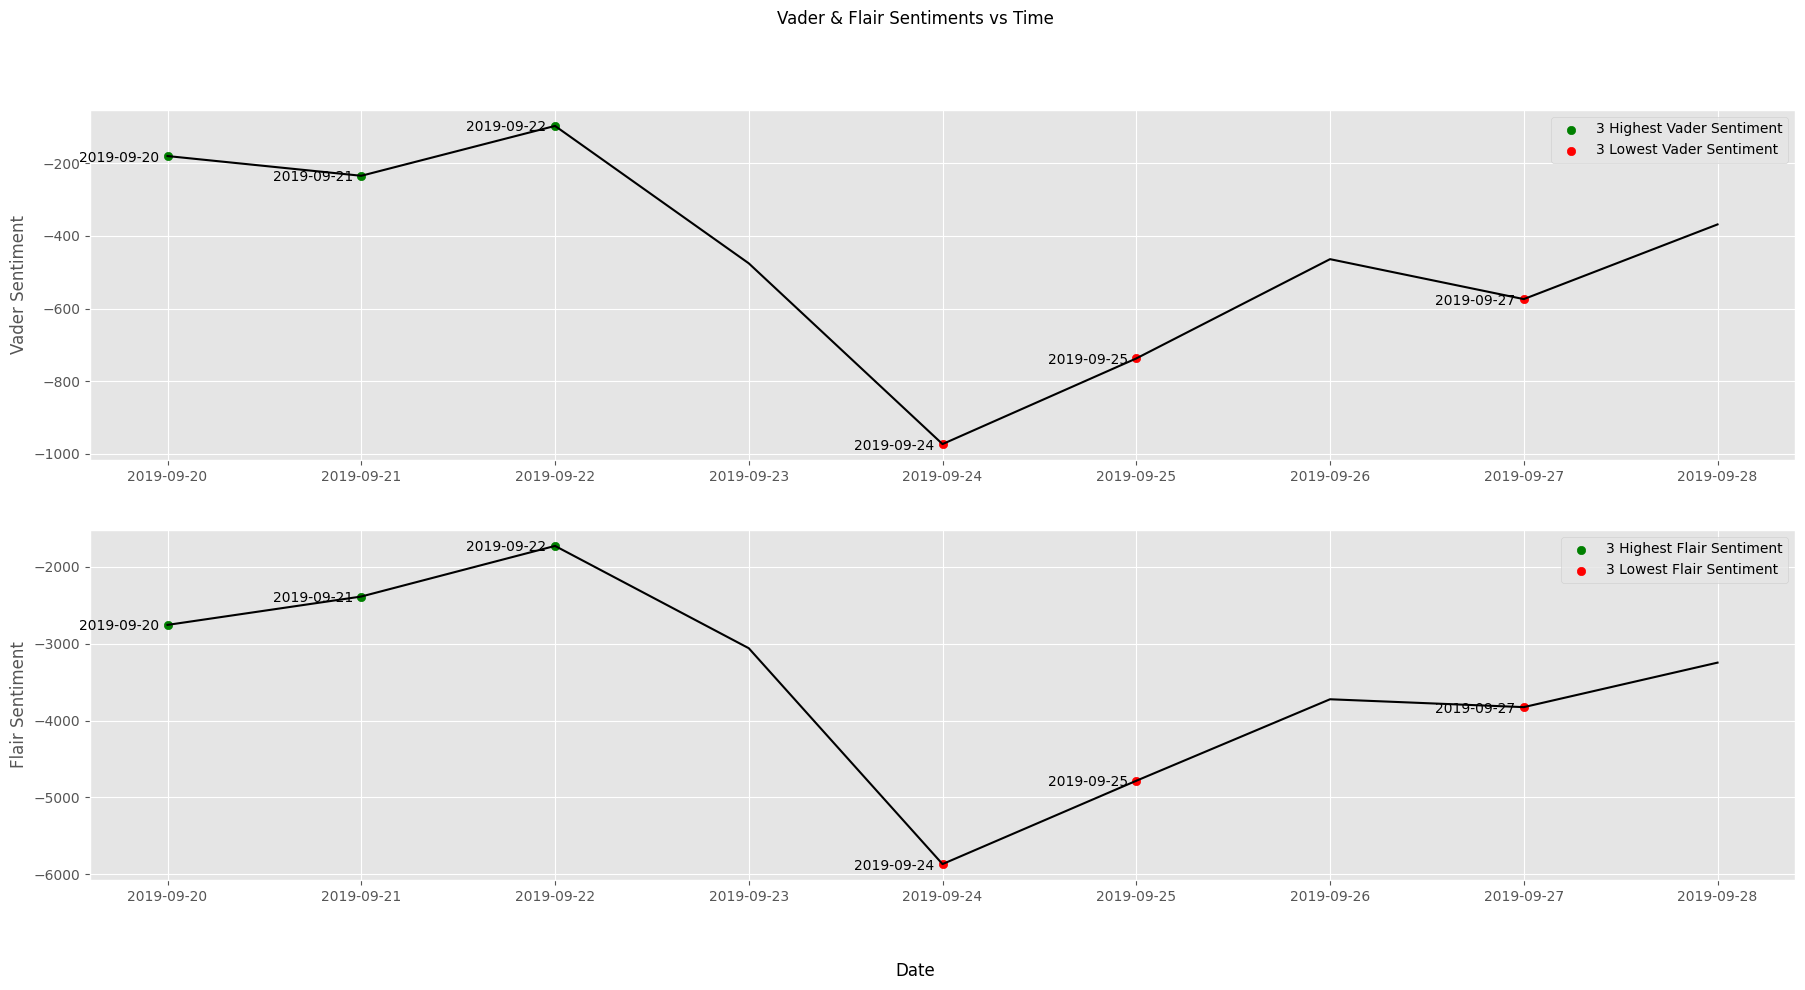

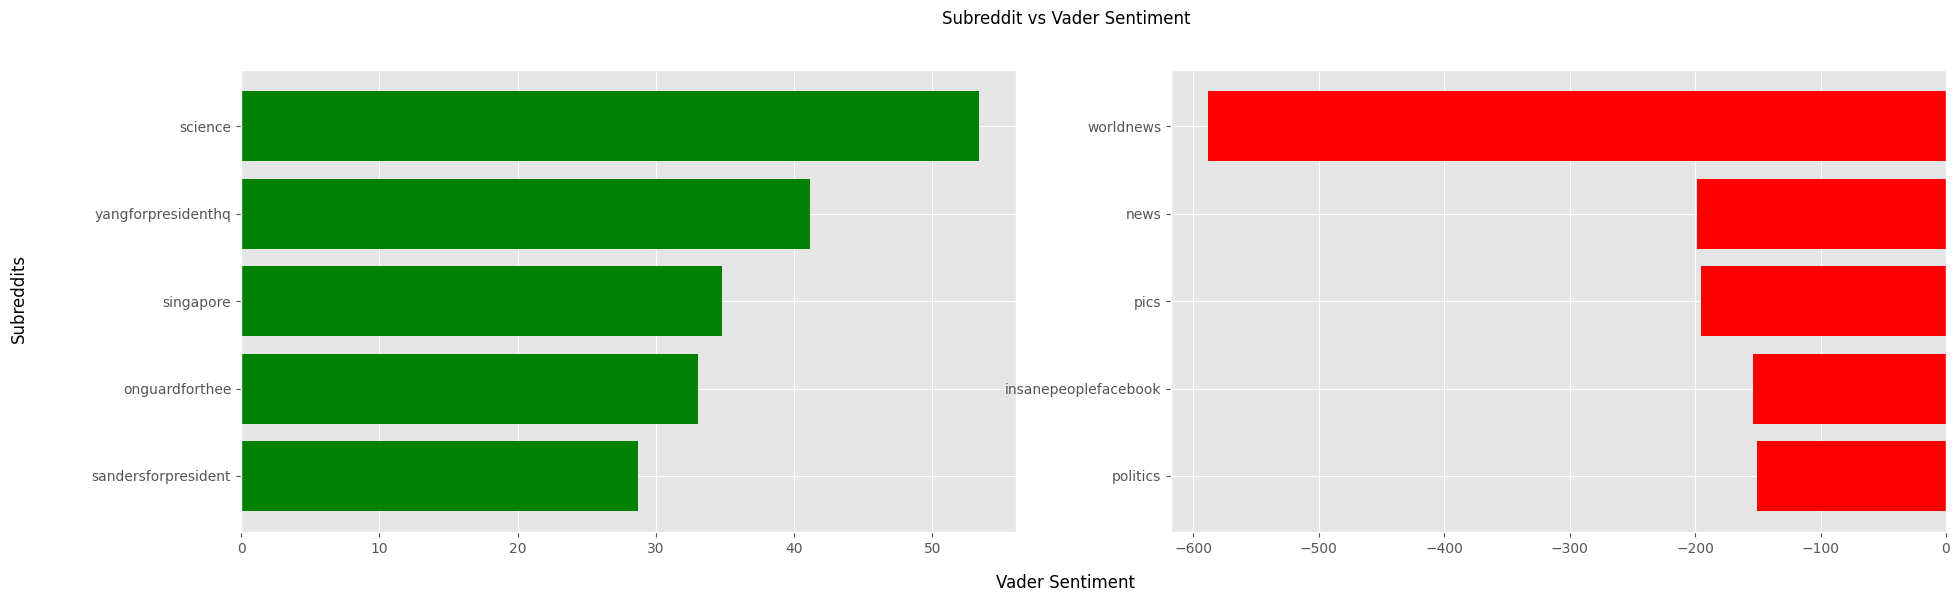

In [ ]:
# Slide 34-36
high_volume_comments_period = reddit_df.filter(pl.col("comment_date").is_between(datetime.strptime('2019-09-20', '%Y-%m-%d'), datetime.strptime('2019-09-28', '%Y-%m-%d')))
get_graphs(high_volume_comments_period)

In [ ]:
for a, b, c in reddit_df.filter((pl.col("comment_date").is_between(datetime.strptime('2019-09-20', '%Y-%m-%d'), datetime.strptime('2019-09-28', '%Y-%m-%d'))) & (pl.col("subreddit.name") == "worldnews")).select(pl.col("comment_date", "body", "score")).sample(500).iter_rows(): print(a, b, c, "\n==============")

In [ ]:
for a, b, c in reddit_df.filter((pl.col("comment_date").is_between(datetime.strptime('2019-09-20', '%Y-%m-%d'), datetime.strptime('2019-09-28', '%Y-%m-%d'))) & (pl.col("subreddit.name") == "worldnews")).sort("score").select(pl.col("comment_date", "body", "score")).tail(5).iter_rows(): print(a, b, c, "\n==============")

2023-08-09 06:05:15,164 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 06:06:39,289 Warning: An empty Sentence was created! Are there empty strings in your dataset?


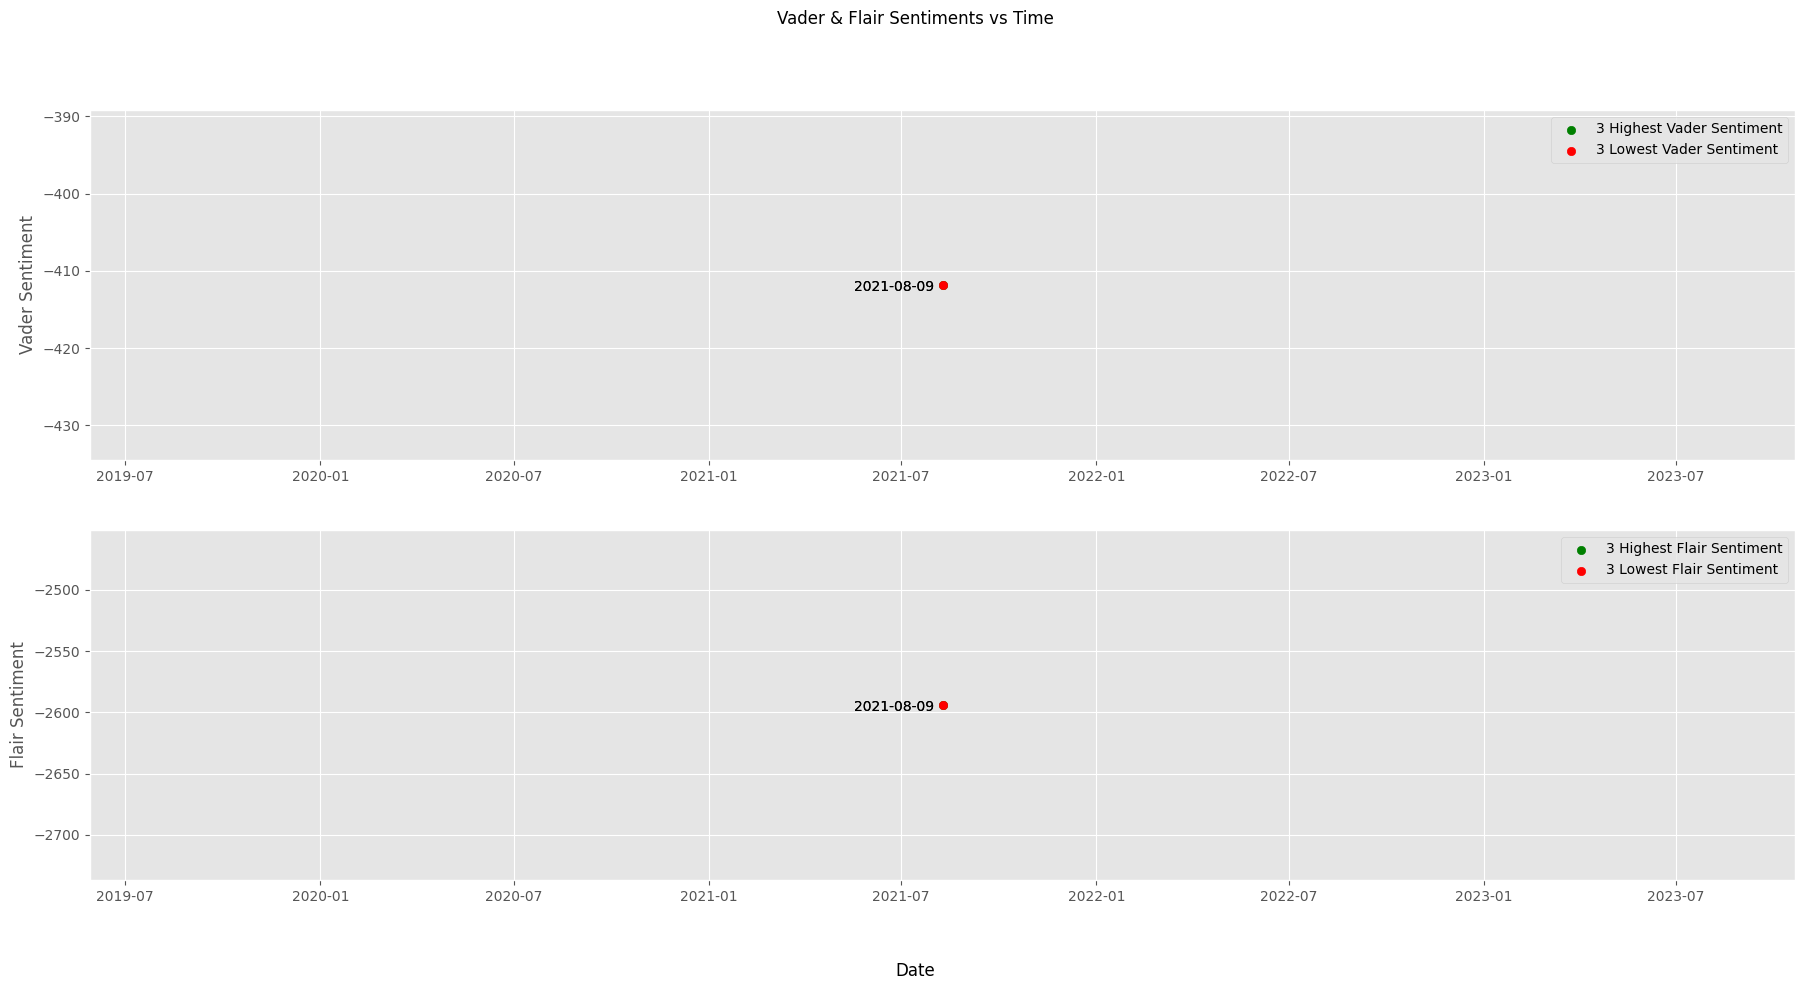

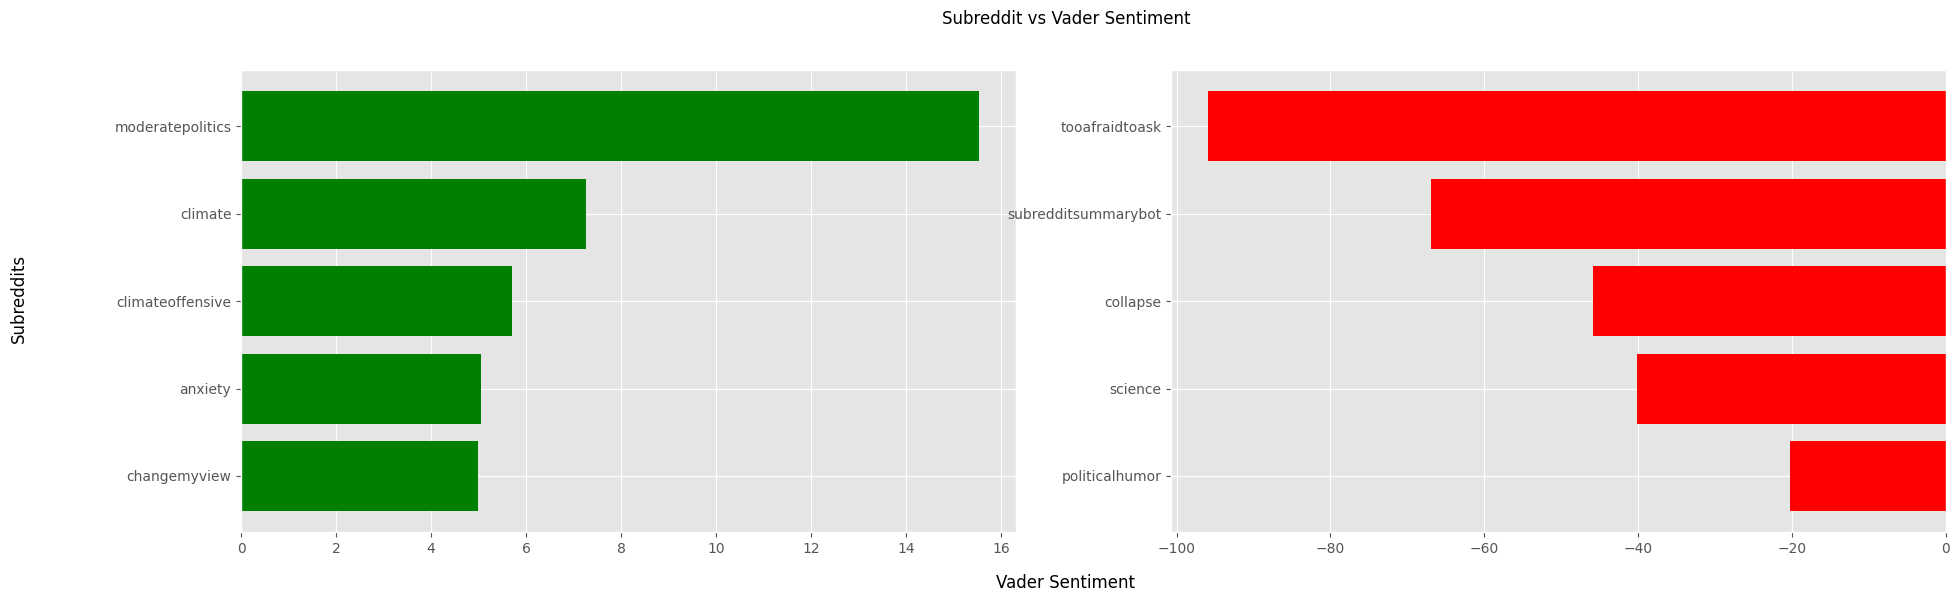

In [ ]:
# Slide 37, 38
high_volume_comments_day = reddit_df.filter(pl.col("comment_date") == datetime.strptime('2021-08-09', '%Y-%m-%d'))
get_graphs(high_volume_comments_day)

In [ ]:
for a, b, c in reddit_df.filter((pl.col("comment_date") == datetime.strptime('2021-08-09', '%Y-%m-%d')) & (pl.col("subreddit.name") == "tooafraidtoask")).sort("score").select(pl.col("comment_date", "body", "score")).head(5).iter_rows(): print(a, b, c, "\n==============")

2021-08-09 00:00:00 But there actually are things to be worried about, such as… CLIMATE CHANGE! -41 
2021-08-09 00:00:00 Due to overpopulation.  Not climate change nonsense. -19 
2021-08-09 00:00:00 It isn’t scientific to say that global warming will be catastrophic. It’s just not. Especially in the next 100 years. 

I understand one political party likes to scare people about climate change but the standard of living in 100 years will be way better than it is today. -8 
2021-08-09 00:00:00 Except climate change is a real thing. We wont all magically perish in 2050, but things are gonna start to suck, but mostly for third world countries. -7 
2021-08-09 00:00:00 I never said it wouldn’t evolve, just that the stuff from the 70’s is definitely far more focused on global warming rather than cooling.  The only major cooling predictions were from aerosols being released into the atmosphere, which clearly aren’t a problem anymore.

Acting like we haven’t known that anthropomorphic climate ch

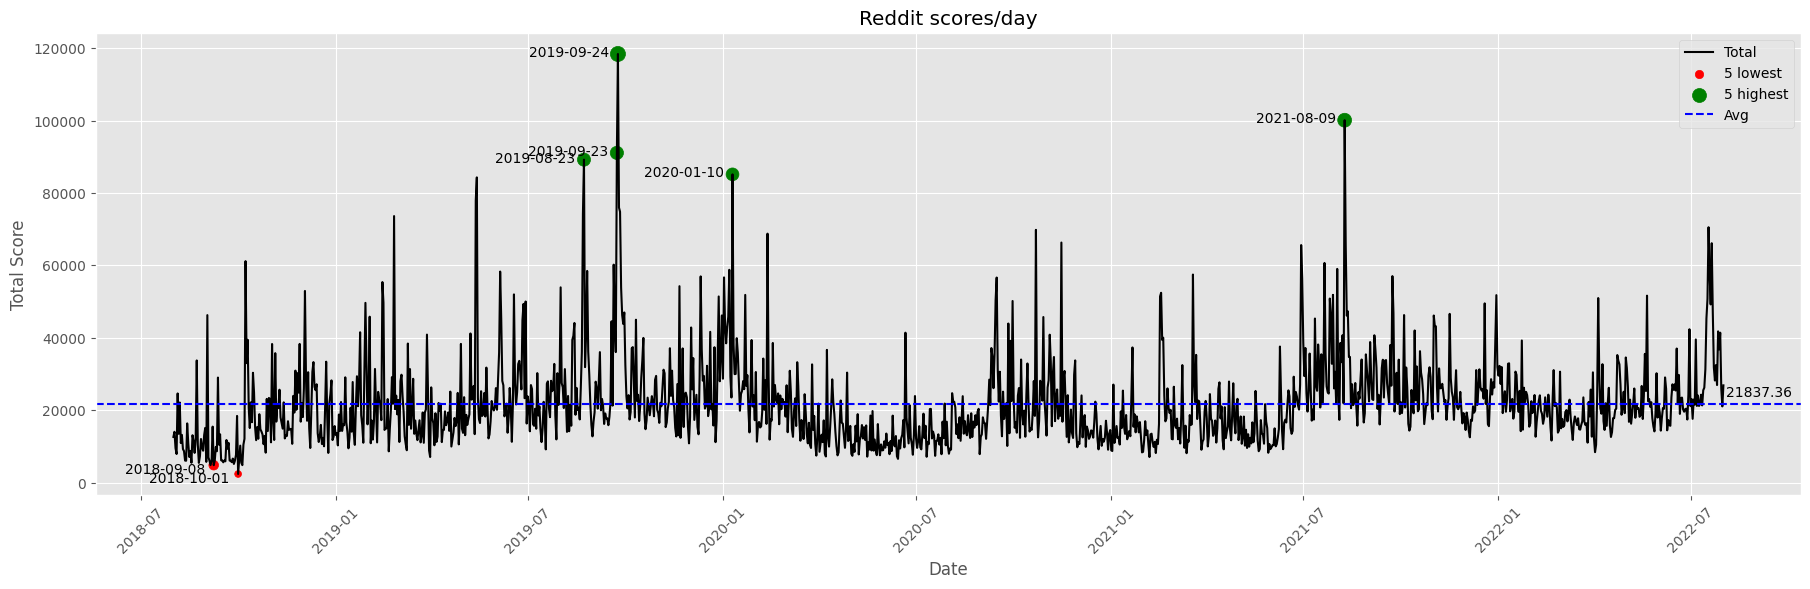

In [ ]:
# Slide 39
r_score_day = reddit_df.groupby_dynamic('comment_date', every="1d").agg(pl.col('score').sum().alias('total_score'))
r_avg_score = r_score_day['total_score'].mean()
r_score_day_sorted = r_score_day.sort("total_score")
r_lowest_scores = r_score_day_sorted.head(2)
r_highest_scores = r_score_day_sorted.tail(5)

mplt.figure(figsize=(22, 6))
mplt.plot(r_score_day['comment_date'], r_score_day['total_score'], label='Total', color="black")
mplt.scatter(r_lowest_scores['comment_date'], r_lowest_scores['total_score'], label='5 lowest', s=r_lowest_scores['total_score'] * 0.01, color="red")
mplt.scatter(r_highest_scores['comment_date'], r_highest_scores['total_score'], label='5 highest', s=r_highest_scores['total_score'] * 0.001, color="green")
mplt.axhline(y=r_avg_score, color='blue', linestyle='--', label='Avg')
annotate(text=round(r_avg_score, 2),
         xy=(datetime.strptime('2022-09-01', '%Y-%m-%d'), r_avg_score),
         xy_offset=(2, 5))

for comment_date, total_score in r_lowest_scores.iter_rows():
  annotate(text=comment_date.strftime('%Y-%m-%d'),
           xy=(comment_date, total_score),
           xy_offset=(-35, -6))

for comment_date, total_score in r_highest_scores.iter_rows():
  annotate(text=comment_date.strftime('%Y-%m-%d'),
           xy=(comment_date, total_score),
           xy_offset=(-35, -2))

mplt.xlabel('Date')
mplt.ylabel('Total Score')
mplt.title('Reddit scores/day')
mplt.legend()
mplt.xticks(rotation=45)
mplt.show()

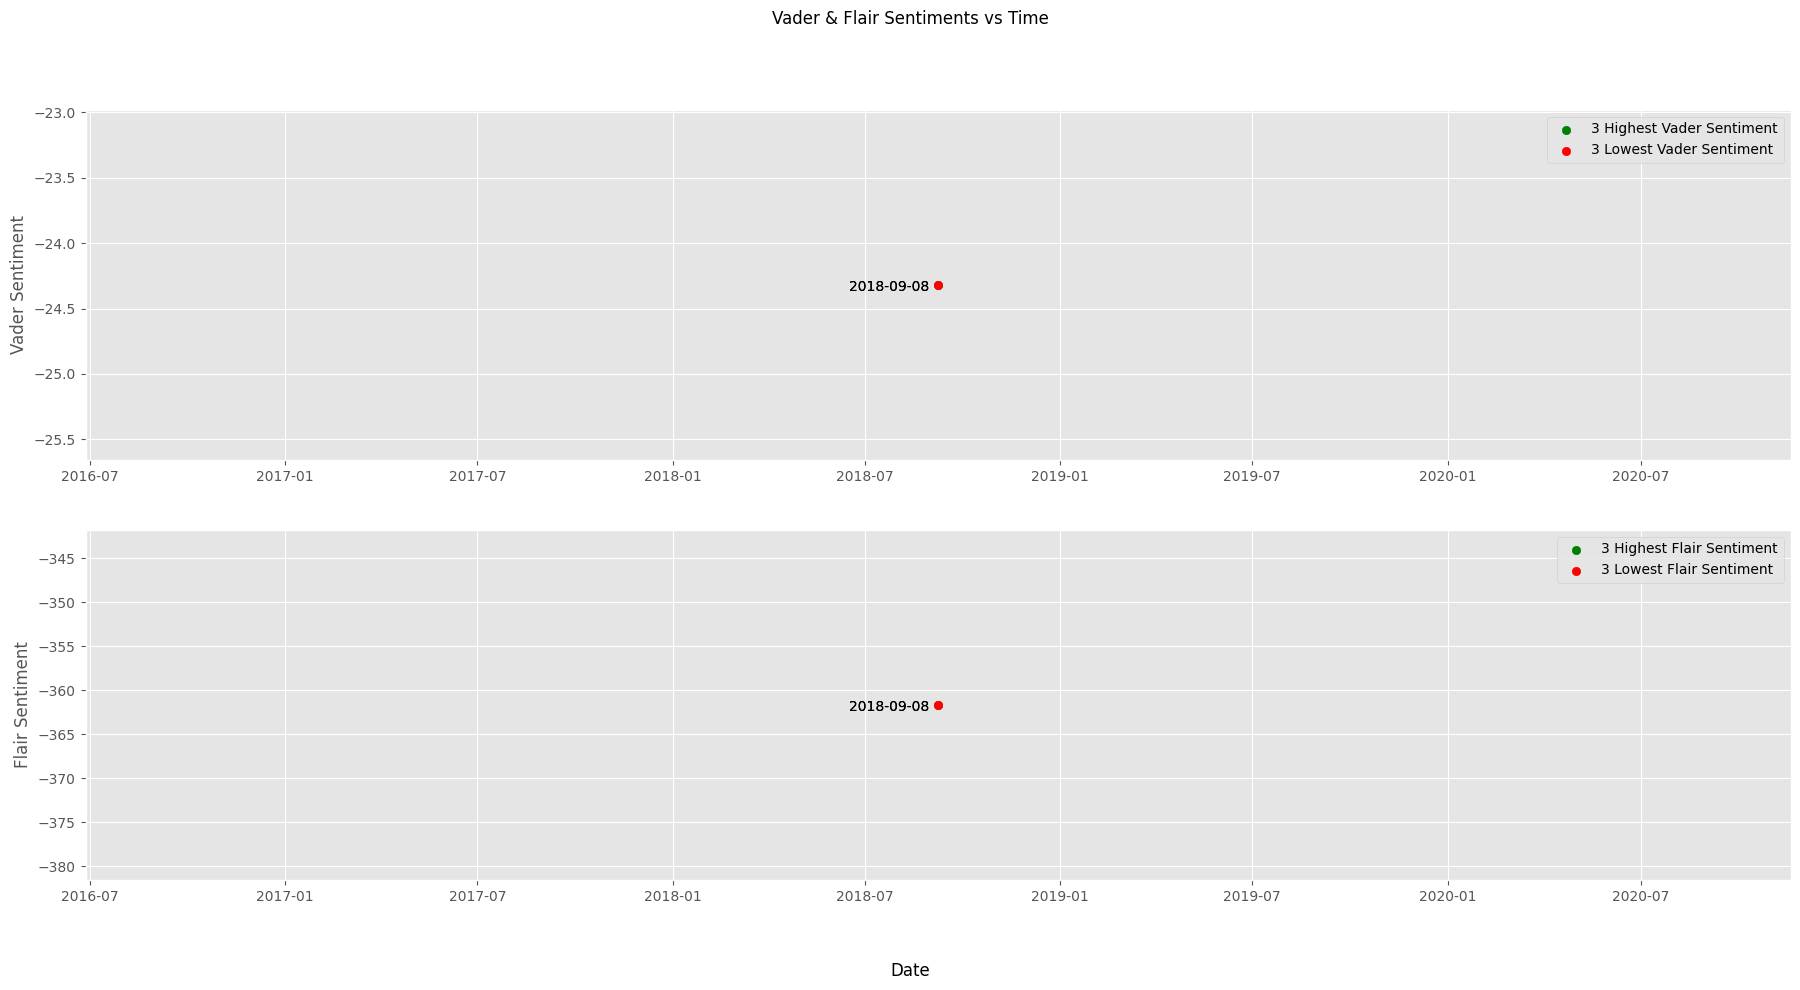

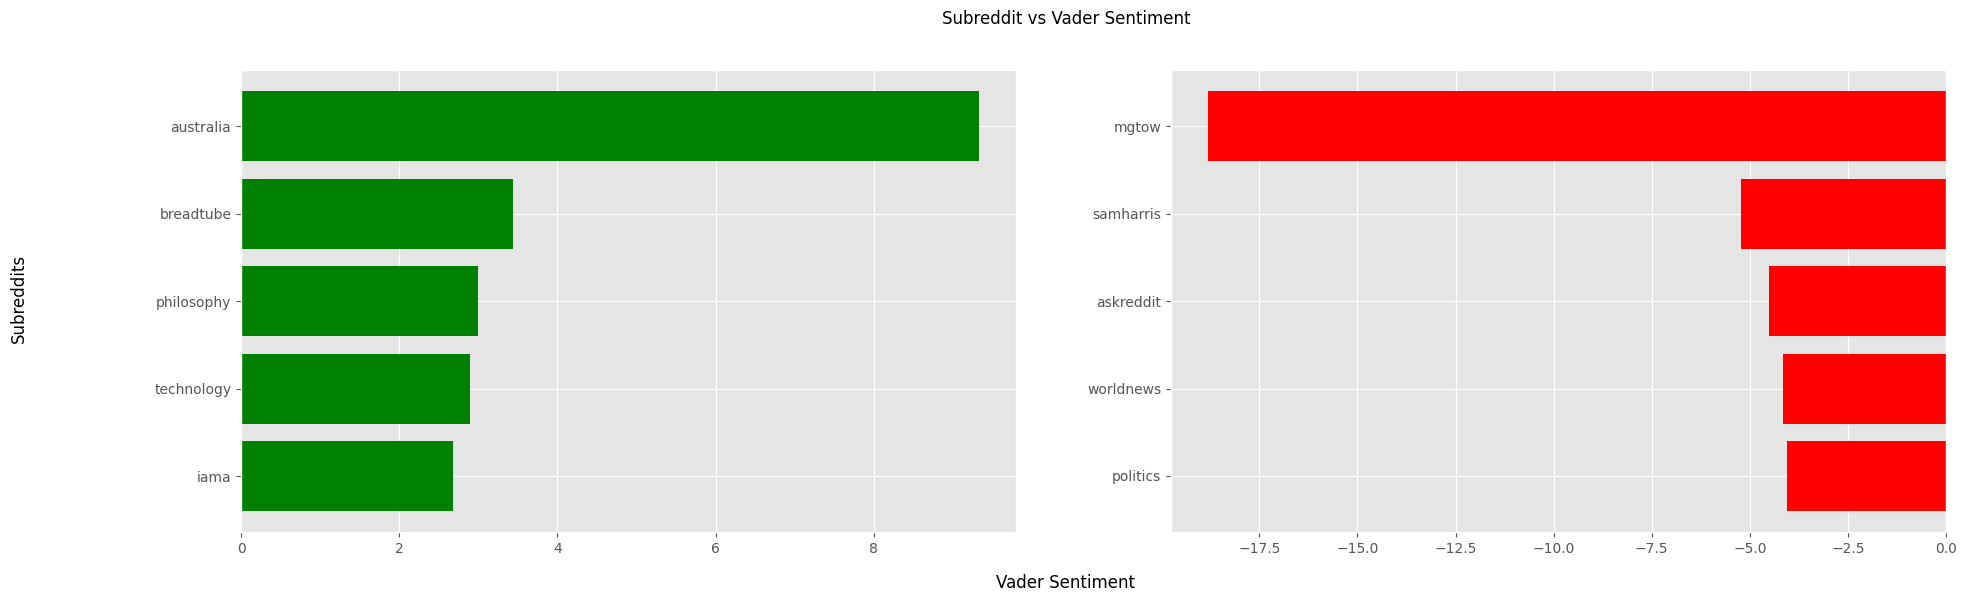

In [ ]:
# Slide 40
low_scores_day_1 = reddit_df.filter(pl.col("comment_date") == datetime.strptime('2018-09-08', '%Y-%m-%d'))
get_graphs(low_scores_day_1)

In [ ]:
for a, b, c, d in low_scores_day_1.filter(pl.col("subreddit.name") == "australia").sort("score").select(pl.col("comment_date", "body", "permalink", "score")).sample(20).iter_rows(): print(a, b, c, d, "\n==============")

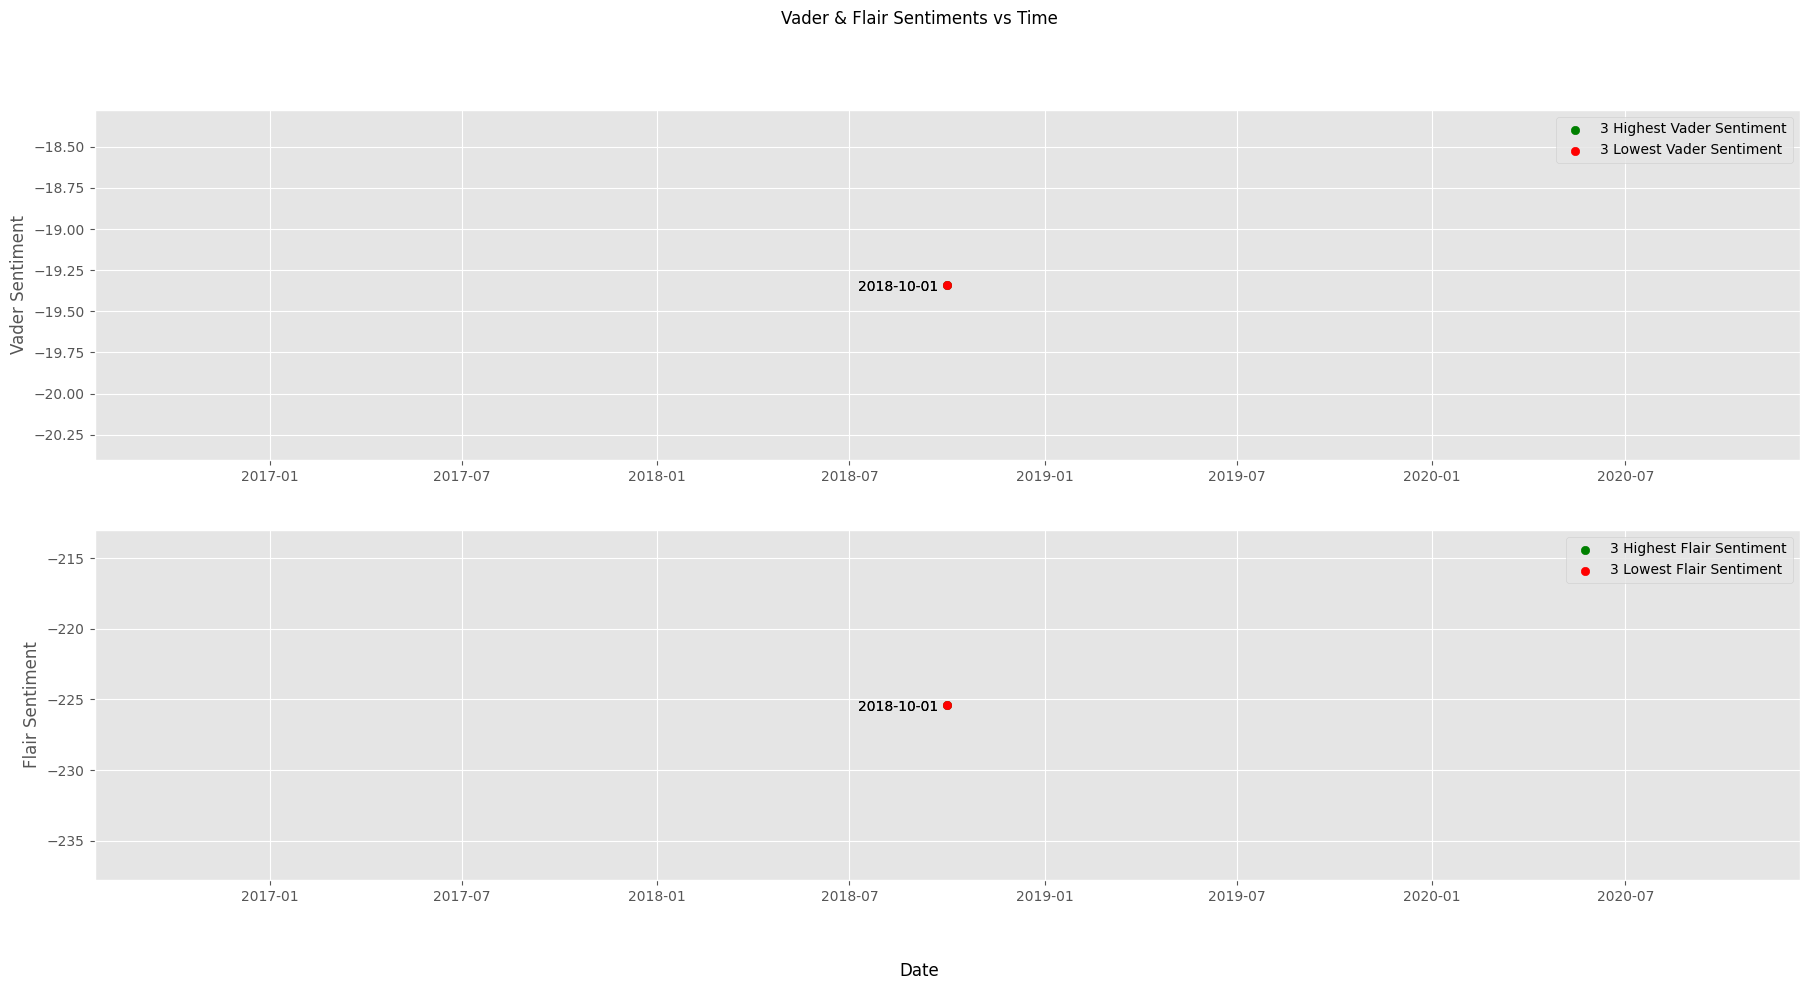

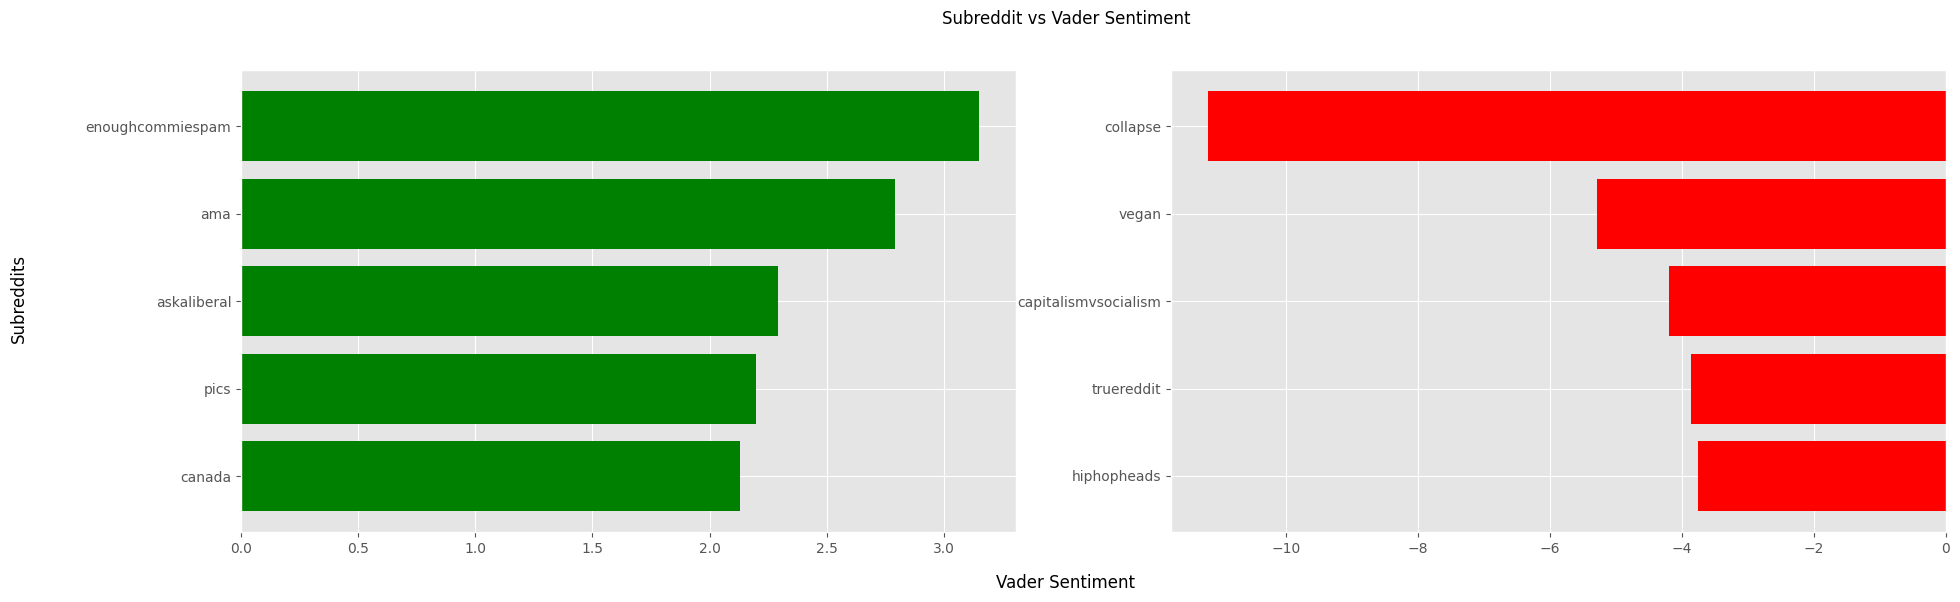

In [ ]:
# Nothing much, skipped
low_scores_day_2 = reddit_df.filter(pl.col("comment_date") == datetime.strptime('2018-10-01', '%Y-%m-%d'))
get_graphs(low_scores_day_2)

In [ ]:
for a, b, c, d in reddit_df.filter((pl.col("comment_date") == datetime.strptime('2018-10-01', '%Y-%m-%d')) & (pl.col("subreddit.name") == "collapse")).sort("score").select(pl.col("comment_date", "body", "permalink", "score")).head(5).iter_rows(): print(a, b, c, d, "\n==============")

2023-08-09 07:02:21,469 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 07:02:22,119 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-08-09 07:03:06,914 Warning: An empty Sentence was created! Are there empty strings in your dataset?


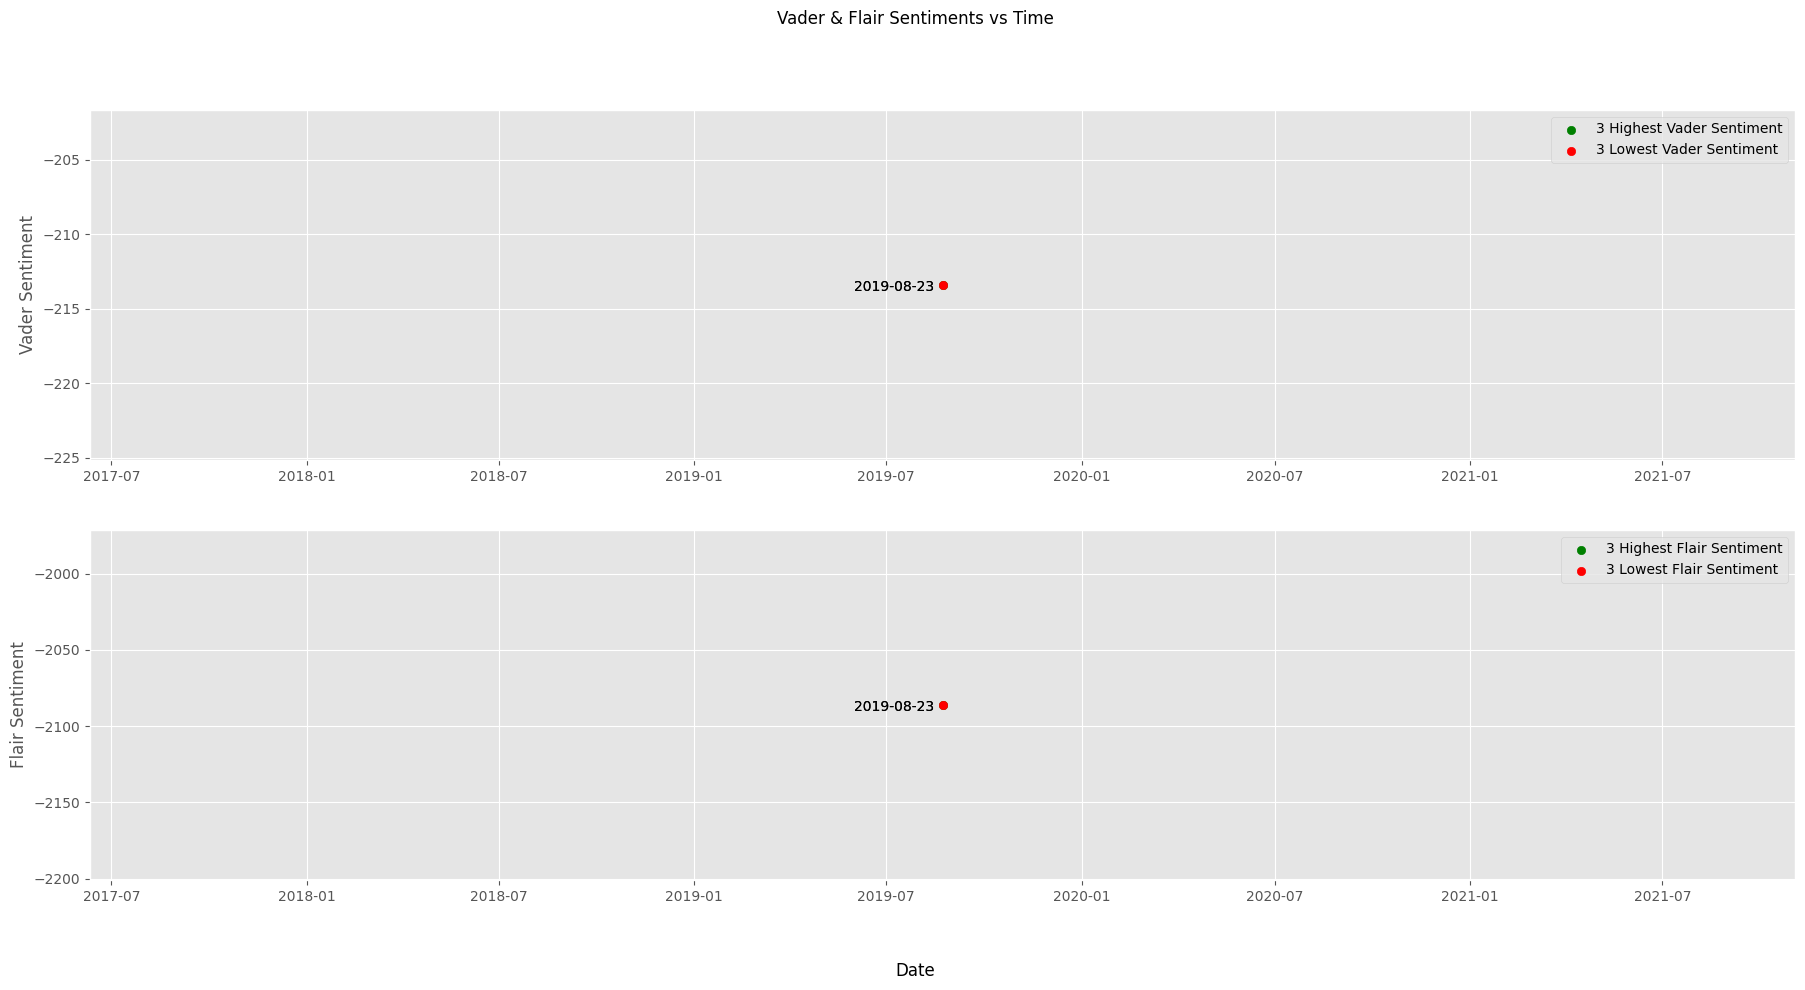

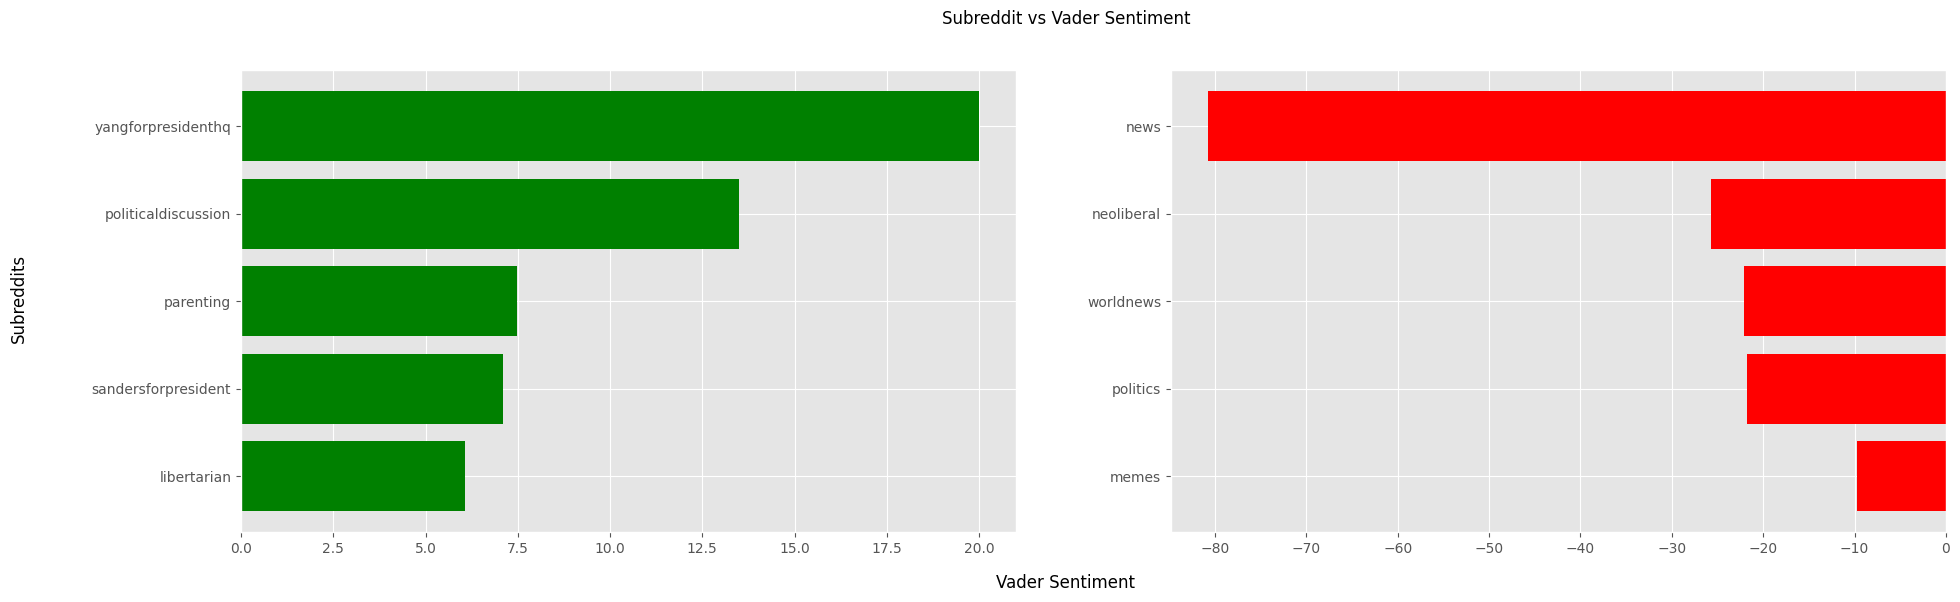

In [ ]:
# Slide 42, 43
high_scores_day_1 = reddit_df.filter(pl.col("comment_date") == datetime.strptime('2019-08-23', '%Y-%m-%d'))
get_graphs(high_scores_day_1)

In [ ]:
for a, b, c, d in reddit_df.filter((pl.col("comment_date") == datetime.strptime('2019-08-23', '%Y-%m-%d')) & (pl.col("subreddit.name") == "news")).sort("score").select(pl.col("comment_date", "permalink", "score", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2023-08-09 07:11:28,575 Warning: An empty Sentence was created! Are there empty strings in your dataset?


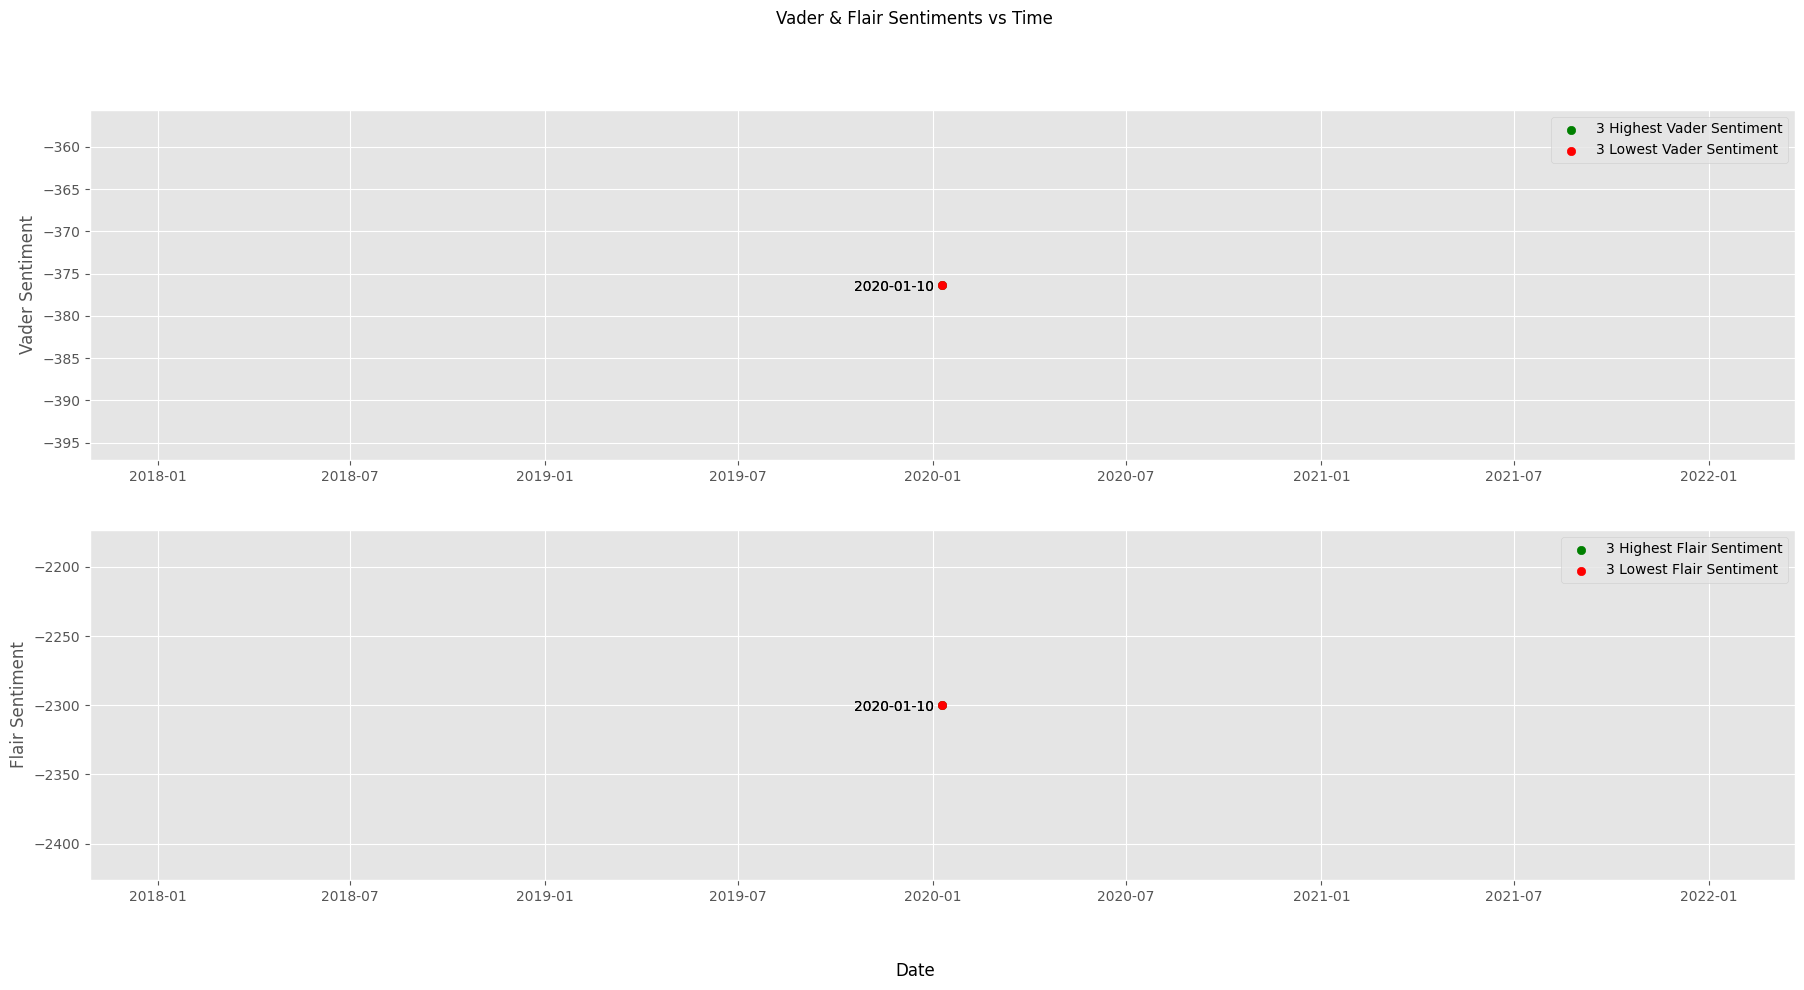

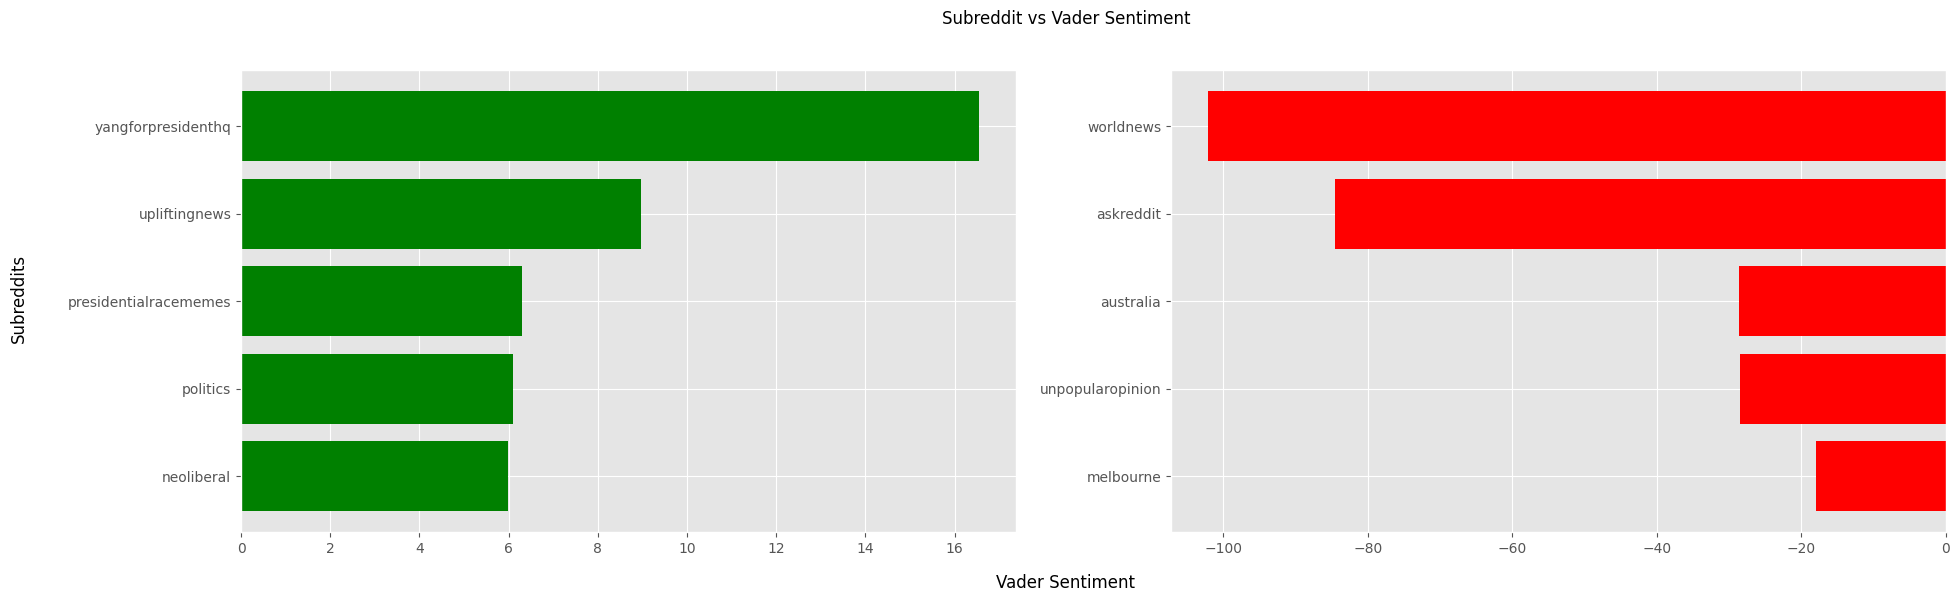

In [ ]:
# Slide 44, 45
high_scores_day_2 = reddit_df.filter(pl.col("comment_date") == datetime.strptime('2020-01-10', '%Y-%m-%d'))
get_graphs(high_scores_day_2)

In [ ]:
for a, b, c, d in reddit_df.filter((pl.col("comment_date") == datetime.strptime('2020-01-10', '%Y-%m-%d')) & (pl.col("subreddit.name") == "askreddit")).sort("score").select(pl.col("comment_date", "permalink", "score", "body")).tail(10).iter_rows(): print(a, b, c, "\n", d, "\n==============")

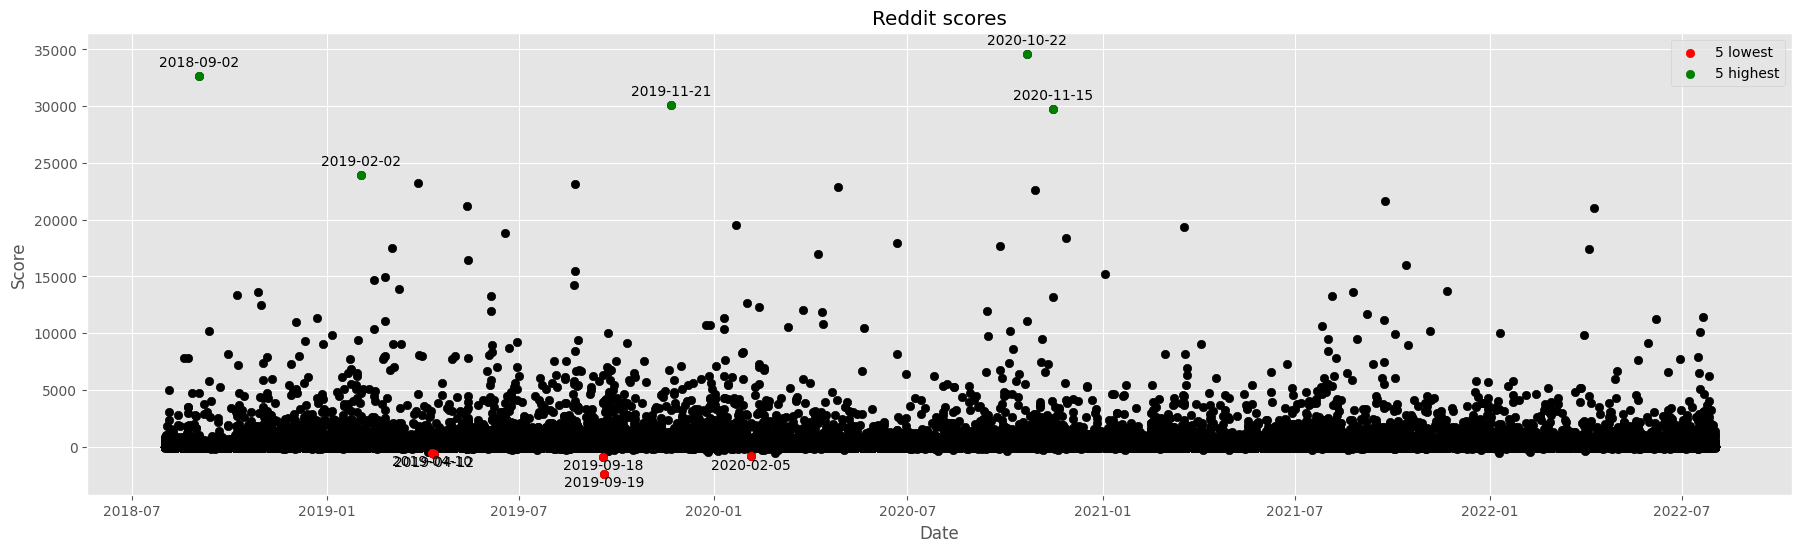

In [ ]:
# Slide 46-48
r_comments_score_sorted = reddit_df.sort("score").select(pl.col("comment_date", "score"))
reddit_lowest_comments = r_comments_score_sorted.head(5)
reddit_highest_comments = r_comments_score_sorted.tail(5)

mplt.figure(figsize=(22, 6))
mplt.scatter(reddit_df["comment_date"], reddit_df["score"], color="black")
mplt.scatter(r_comments_score_sorted["comment_date"].head(5), r_comments_score_sorted["score"].head(5), label='5 lowest', color="red")
mplt.scatter(r_comments_score_sorted["comment_date"].tail(5), r_comments_score_sorted["score"].tail(5), label='5 highest', color="green")

for comment_date, score in reddit_lowest_comments.iter_rows():
  annotate(text=comment_date.strftime('%Y-%m-%d'),
           xy=(comment_date, score),
           xy_offset=(0, -9))

for comment_date, score in reddit_highest_comments.iter_rows():
  annotate(text=comment_date.strftime('%Y-%m-%d'),
           xy=(comment_date, score),
           xy_offset=(0, 7))

mplt.xlabel('Date')
mplt.ylabel('Score')
mplt.title('Reddit scores')
mplt.legend()
mplt.show()

In [ ]:
for a, b, c, d in reddit_df.sort("score").select(pl.col("comment_date", "permalink", "score", "body")).head(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2019-09-19 00:00:00 https://old.reddit.com/r/IAmA/comments/d6etv5/hi_im_beto_orourke_a_candidate_for_president/f0sobz9/ -2379 
  We should rewrite our immigration laws so that there is a safe, orderly and quick path to come to this country to work, to go to school, to join your family, to flee persecution or violence or disaster. We should never again criminally prosecute anyone seeking asylum or refuge; never separate another child from her family; never use immigration enforcement as a tool to breakup families or terrorize communities within the United States. We should work with the people of those countries - like El Salvador, Guatemala, Honduras — that are producing so many refugees to reduce violence, mitigate the effects of climate change and drought, and ensure that they have don’t have to make a 2,000+ mile journey to this country. We should legalize millions who are already here, starting with the more than 1m dreamers, make them u.s. citizens. And then, accomplishing all of 

In [ ]:
for a, b, c, d in reddit_df.sort("score").select(pl.col("comment_date", "permalink", "score", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

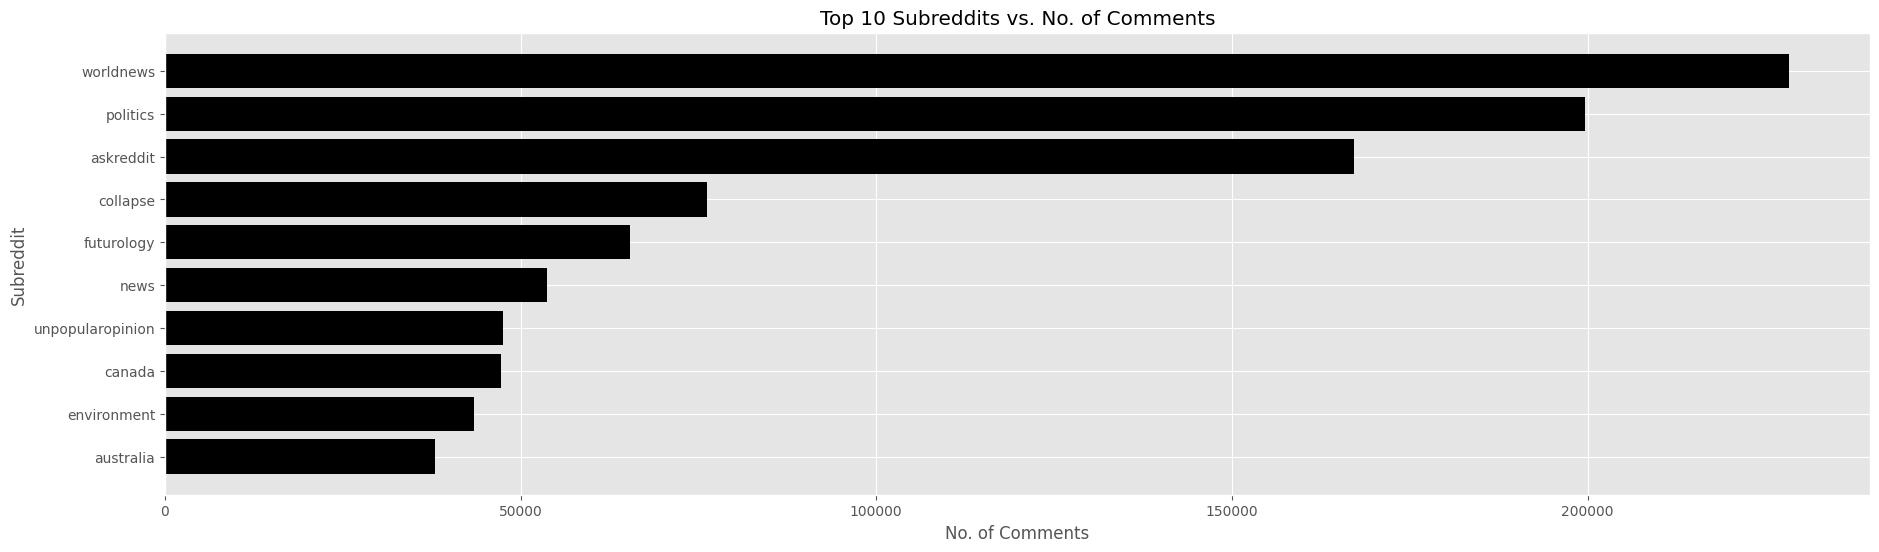

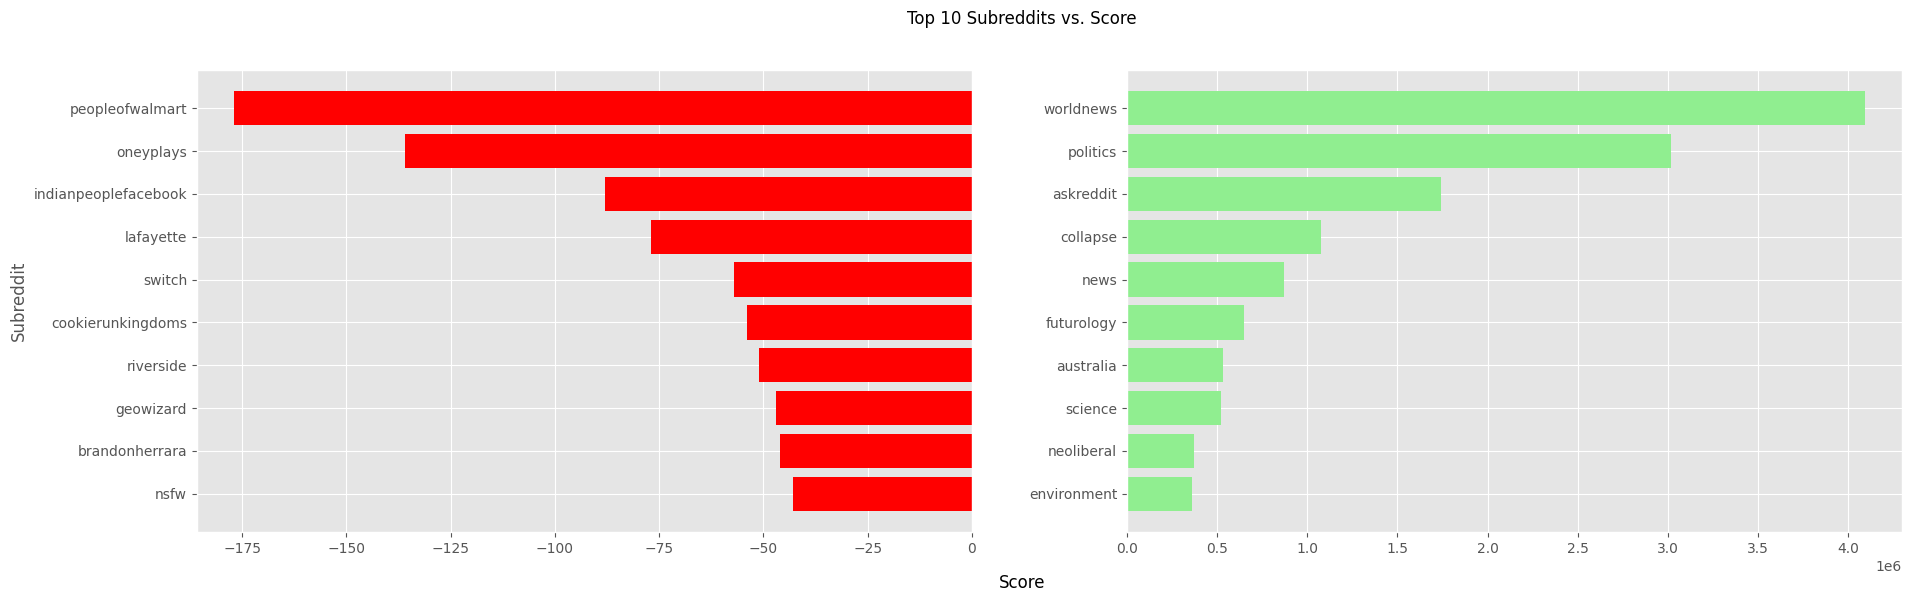

In [ ]:
# Slide 49, 50
r_comments_subreddit = reddit_df.groupby('subreddit.name').agg(pl.count('body').alias('num_subreddit_comments')).sort("num_subreddit_comments")
r_score_subreddit = reddit_df.groupby('subreddit.name').agg(pl.col('score').sum().alias('subreddit_score')).sort("subreddit_score")

mplt.figure(figsize=(22, 6))
mplt.barh(r_comments_subreddit.tail(10)['subreddit.name'], r_comments_subreddit.tail(10)['num_subreddit_comments'], color='black')
mplt.xlabel('No. of Comments')
mplt.ylabel('Subreddit')
mplt.title('Top 10 Subreddits vs. No. of Comments')

fig, axes = mplt.subplots(1, 2, figsize=(22, 6))
axes[0].barh(r_score_subreddit.head(10).sort("subreddit_score", descending=True)['subreddit.name'], r_score_subreddit.head(10).sort("subreddit_score", descending=True)['subreddit_score'], color='red')
axes[0].set_ylabel('Subreddit')
axes[1].barh(r_score_subreddit.tail(10)['subreddit.name'], r_score_subreddit.tail(10)['subreddit_score'], color='lightgreen')
fig.supxlabel("Score")
mplt.suptitle("Top 10 Subreddits vs. Score")

mplt.show()

In [ ]:
for a, b, c, d in reddit_df.filter(pl.col("subreddit.name") == "cookierunkingdoms").select(pl.col("comment_date", "permalink", "score", "body")).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2021-12-24 00:00:00 https://old.reddit.com/r/CookieRunKingdoms/comments/rn9p64/stop_playing_devsisters_games_for_a_week_until/hprn7el/ -66 
 nfts legit contribute to climate change so little, like less than 1%. companies like amazon and apple contribute to climate change so much more. instead of campaigning against devsis we should boycott amazon and other large companies 
2021-12-24 00:00:00 https://old.reddit.com/r/CookieRunKingdoms/comments/rn9p64/stop_playing_devsisters_games_for_a_week_until/hps8uhn/ 12 
 Its not just climate change, its a scam and a barely legal pyramidal scheme used by mostly money laundrers. Like wtf 80% of the crk community cant even start their own bank account, nobody will buy them anyway 


#### Lexicon-based sentiment (AFINN, NRC)

In [ ]:
# !pip install afinn
from afinn import Afinn
# !pip install NRCLex
from nrclex import NRCLex
import regex as re
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import TweetTokenizer
nltk.download('punkt')
from string import punctuation, ascii_lowercase
import regex as re
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

with open(f"drive/My Drive/{FOLDERNAME}/data/stopwords_extra.json", "r") as file: stopwords_extra = set(json.load(file))
stopwords_nltk = set(stopwords.words('english'))
# !"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~
# Unicode symbols Eg. ' vs ’
punctuation += "–—― ̳‘’‚‛“”„†‡•...‰′′′‹›!! ̅⁄⁊"
stopwords_punct = set(punctuation)
stopwords_alphabets = set(ascii_lowercase)
combined_stoplist = list(set.union(stopwords_extra, stopwords_nltk, stopwords_punct, stopwords_alphabets))

# Convert pos_tag tags to WordNet's POS tags
def get_POS_tags(pos_tag):
  POS_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
  try:
    # Getting first 2 letters of pos_tag
    return POS_tag[pos_tag[:2]]
  except:
    # Fallback to noun (Default)
    return 'n'

def lexicon_score(text: str) -> tuple:
    # Splits intelligently on whitespaces, some punctuation
    tokenized_words = tokenizer.tokenize(text.lower())
    # Unicode Categories C (Control), M (Mark), S (Symbol), Z (Separator) + emojis
    stopwords_removed = [re.compile(r'[\p{C}|\p{M}|\p{S}|\p{Z}]+', re.UNICODE).sub(" ", word).strip() for word in tokenized_words if word not in combined_stoplist and not re.search("\d+", word)]
    # Lemmatization Eg. happier (no score) => happy (3.0)
    lemmatized_joined = " ".join([wnl.lemmatize(word, pos=get_POS_tags(tag)) for word, tag in pos_tag(stopwords_removed)])

    NRC_emotions = NRCLex(lemmatized_joined)
    NRC_emotions_str = ', '.join(emotion[0] for emotion in NRC_emotions.top_emotions)
    return str(afinn.score(lemmatized_joined)), str(round(NRC_emotions.raw_emotion_scores.get("positive", 0) - NRC_emotions.raw_emotion_scores.get("negative", 0), 2)), NRC_emotions_str

tokenizer = TweetTokenizer()
wnl = WordNetLemmatizer()
afinn = Afinn()
r_lex = reddit_df.with_columns(
    pl.col("body").apply(lexicon_score).alias("AFINN_NRC")
)
r_lex = r_lex.select(
    pl.all().exclude("AFINN_NRC Sentiments"),
    pl.col("AFINN_NRC").apply(lambda x: x[0]).alias("AFINN").cast(pl.Float32),
    pl.col("AFINN_NRC").apply(lambda x: x[1]).alias("NRC").cast(pl.Float32),
    pl.col("AFINN_NRC").apply(lambda x: x[2]).alias("NRC_Sentiments").cast(pl.Categorical)
)
r_lex

shape: (3_237_761, 8)
┌───────────────┬──────────────┬──────────────┬──────────────┬───────┬───────┬──────┬──────────────┐
│ comment_date  ┆ subreddit.na ┆ permalink    ┆ body         ┆ score ┆ AFINN ┆ NRC  ┆ NRC_Sentimen │
│ ---           ┆ me           ┆ ---          ┆ ---          ┆ ---   ┆ ---   ┆ ---  ┆ ts           │
│ datetime[ns]  ┆ ---          ┆ str          ┆ str          ┆ i64   ┆ f32   ┆ f32  ┆ ---          │
│               ┆ str          ┆              ┆              ┆       ┆       ┆      ┆ cat          │
╞═══════════════╪══════════════╪══════════════╪══════════════╪═══════╪═══════╪══════╪══════════════╡
│ 2018-08-01    ┆ unpopularopi ┆ https://old. ┆ That's what  ┆ 3     ┆ -12.0 ┆ -3.0 ┆ fear         │
│ 00:00:00      ┆ nion         ┆ reddit.com/r ┆ we worried   ┆       ┆       ┆      ┆              │
│               ┆              ┆ /unpopul…    ┆ about wit…   ┆       ┆       ┆      ┆              │
│ 2018-08-01    ┆ iama         ┆ https://old. ┆ Hi Andrew! I ┆ 1     ┆ -2.0  ┆ 0.0  ┆ fear, trust, │
│ 00:00:00      ┆              ┆ reddit.com/r ┆ was curious  ┆       ┆       ┆      ┆ surprise     │
│               ┆              ┆ /IAmA/co…    ┆ about w…     ┆       ┆       ┆      ┆              │
│ 2018-08-01    ┆ chapotraphou ┆ https://old. ┆              ┆ 2     ┆ -4.0  ┆ -2.0 ┆ fear,        │
│ 00:00:00      ┆ se           ┆ reddit.com/r ┆ &gt;How are  ┆       ┆       ┆      ┆ negative     │
│               ┆              ┆ /ChapoTr…    ┆ the core     ┆       ┆       ┆      ┆              │
│               ┆              ┆              ┆ ideas behi…  ┆       ┆       ┆      ┆              │
│ 2018-08-01    ┆ europe       ┆ https://old. ┆ Nonono       ┆ 1     ┆ 0.0   ┆ 0.0  ┆ fear,        │
│ 00:00:00      ┆              ┆ reddit.com/r ┆ climate      ┆       ┆       ┆      ┆ anticipation │
│               ┆              ┆ /europe/…    ┆ change just  ┆       ┆       ┆      ┆              │
│               ┆              ┆              ┆ start…       ┆       ┆       ┆      ┆              │
│ 2018-08-01    ┆ science      ┆ https://old. ┆ Canada.      ┆ 7     ┆ -2.0  ┆ 2.0  ┆ fear,        │
│ 00:00:00      ┆              ┆ reddit.com/r ┆ Forest fires ┆       ┆       ┆      ┆ positive     │
│               ┆              ┆ /science…    ┆ and heatwav… ┆       ┆       ┆      ┆              │
│ …             ┆ …            ┆ …            ┆ …            ┆ …     ┆ …     ┆ …    ┆ …            │
│ 2022-08-01    ┆ magictruffle ┆ https://old. ┆ I am glad    ┆ 1     ┆ 9.0   ┆ 4.0  ┆ positive     │
│ 00:00:00      ┆              ┆ reddit.com/r ┆ you liked it ┆       ┆       ┆      ┆              │
│               ┆              ┆ /MagicTr…    ┆ and had a…   ┆       ┆       ┆      ┆              │
│ 2022-08-01    ┆ ark          ┆ https://old. ┆ You bought a ┆ 11    ┆ -6.0  ┆ 3.0  ┆ positive     │
│ 00:00:00      ┆              ┆ reddit.com/r ┆ game to play ┆       ┆       ┆      ┆              │
│               ┆              ┆ /ARK/com…    ┆ on ser…      ┆       ┆       ┆      ┆              │
│ 2022-08-01    ┆ environment  ┆ https://old. ┆ ***From      ┆ 1     ┆ 7.0   ┆ 15.0 ┆ positive     │
│ 00:00:00      ┆              ┆ reddit.com/r ┆ reporters    ┆       ┆       ┆      ┆              │
│               ┆              ┆ /environ…    ┆ Meghan       ┆       ┆       ┆      ┆              │
│               ┆              ┆              ┆ McDonou…     ┆       ┆       ┆      ┆              │
│ 2022-08-01    ┆ worldnews    ┆ https://old. ┆ This is the  ┆ 7     ┆ -9.0  ┆ 2.0  ┆ fear,        │
│ 00:00:00      ┆              ┆ reddit.com/r ┆ problem with ┆       ┆       ┆      ┆ positive     │
│               ┆              ┆ /worldne…    ┆ the gre…     ┆       ┆       ┆      ┆              │
│ 2022-08-01    ┆ politics     ┆ https://old. ┆ None of the  ┆ 17    ┆ 0.0   ┆ 1.0  ┆ fear         │
│ 00:00:00      ┆              ┆ reddit.com/r ┆ others have  ┆       ┆       ┆      ┆              │
│               ┆              ┆ /polit

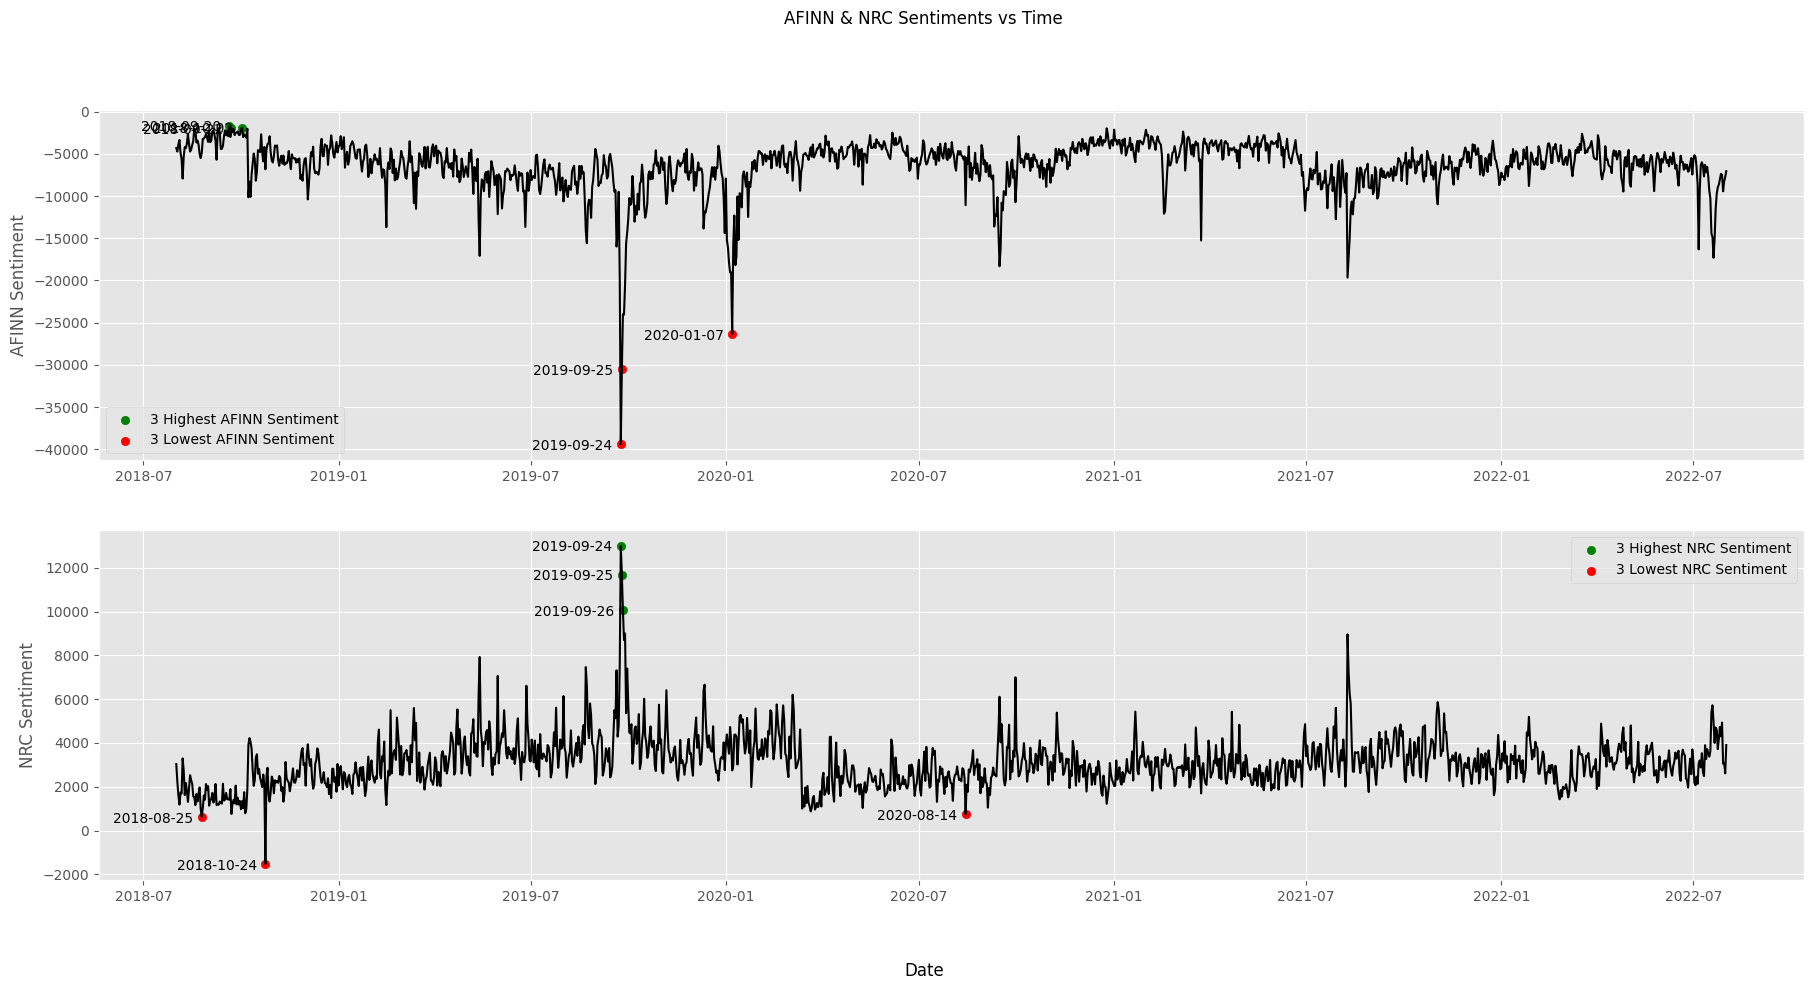

In [ ]:
# Slide 51
r_lex_afinn_sum = r_lex.groupby_dynamic('comment_date', every="1d").agg(pl.col('AFINN').sum().alias("afinn_sum"))
r_lex_nrc_sum = r_lex.groupby_dynamic('comment_date', every="1d").agg(pl.col('NRC').sum().alias("nrc_sum"))
afinn_date_sorted = r_lex_afinn_sum.sort("afinn_sum")
afinn_date_filtered_high = afinn_date_sorted.tail(3)
afinn_date_filtered_low = afinn_date_sorted.head(3)
nrc_date_sorted = r_lex_nrc_sum.sort("nrc_sum")
nrc_date_filtered_high = nrc_date_sorted.tail(3)
nrc_date_filtered_low = nrc_date_sorted.head(3)

fig, axes = mplt.subplots(2, 1, figsize=(22, 10))
axes[0].plot(r_lex_afinn_sum["comment_date"], r_lex_afinn_sum["afinn_sum"], color='black')
axes[0].scatter(afinn_date_filtered_high["comment_date"], afinn_date_filtered_high["afinn_sum"], color='green', label="3 Highest AFINN Sentiment")
axes[0].scatter(afinn_date_filtered_low["comment_date"], afinn_date_filtered_low["afinn_sum"], color='red', label="3 Lowest AFINN Sentiment")
axes[0].set_ylabel('AFINN Sentiment')
axes[0].legend()
axes[1].plot(r_lex_nrc_sum["comment_date"], r_lex_nrc_sum["nrc_sum"], color='black')
axes[1].scatter(nrc_date_filtered_high["comment_date"], nrc_date_filtered_high["nrc_sum"], color='green', label="3 Highest NRC Sentiment")
axes[1].scatter(nrc_date_filtered_low["comment_date"], nrc_date_filtered_low["nrc_sum"], color='red', label="3 Lowest NRC Sentiment")
axes[1].set_ylabel('NRC Sentiment')
axes[1].legend()
fig.supxlabel("Date")
mplt.suptitle("AFINN & NRC Sentiments vs Time")

for filtered_df, ax in [(afinn_date_filtered_high, axes[0]), (afinn_date_filtered_low, axes[0]), (nrc_date_filtered_high, axes[1]), (nrc_date_filtered_low, axes[1])]:
    for comment_date, sentiment in filtered_df.iter_rows():
      annotate(text=comment_date.strftime('%Y-%m-%d'),
              xy=(comment_date, sentiment),
              xy_offset=(-35, -4), ax=ax)

mplt.show()

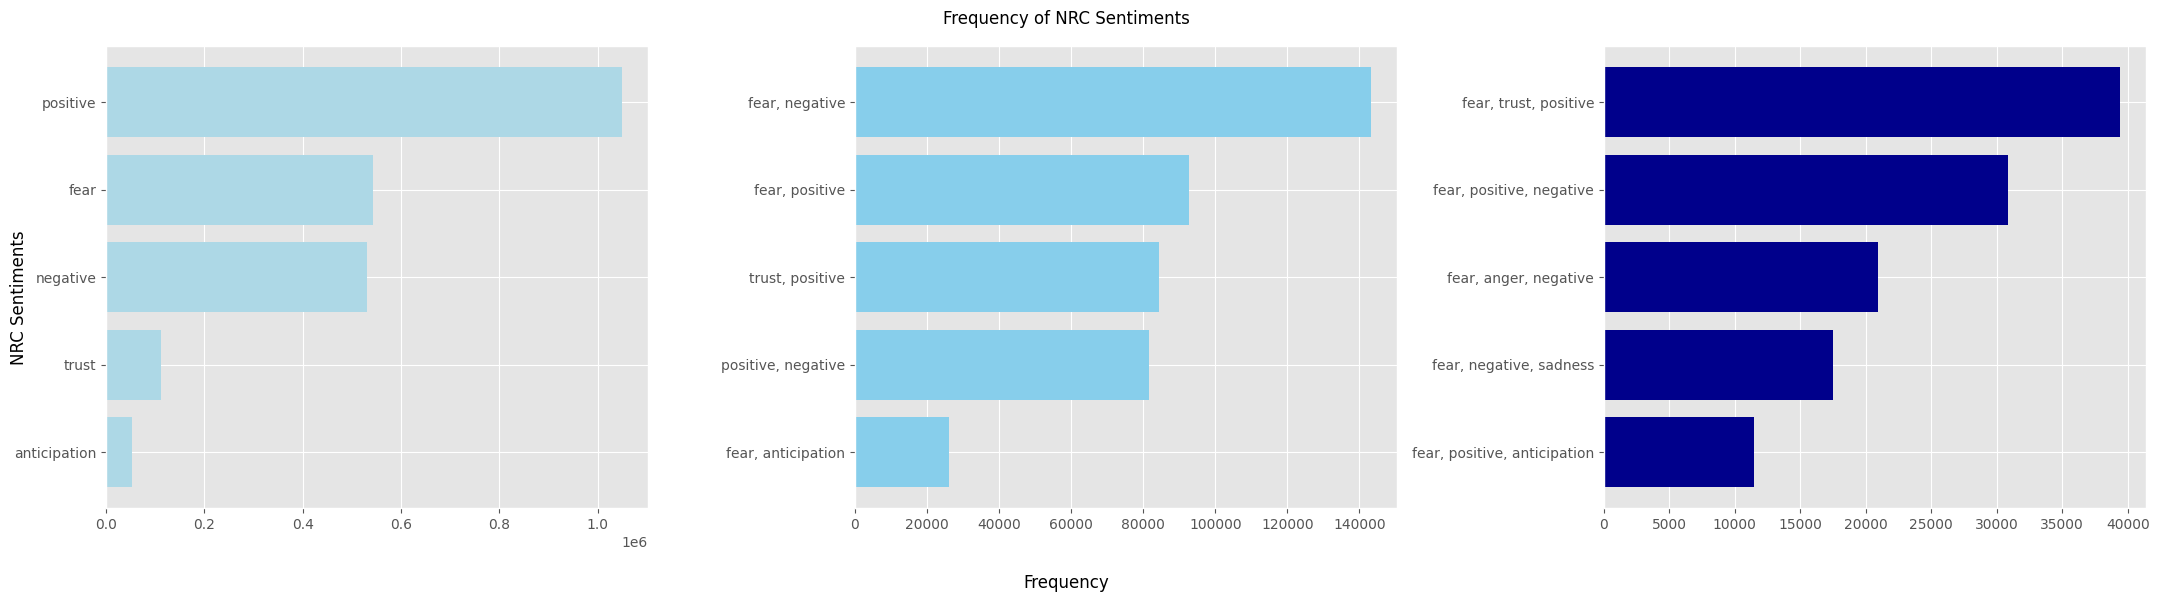

In [ ]:
# Slide 52, 53
r_lex_to_grp = r_lex.select(pl.col("*"), pl.col("NRC_Sentiments").apply(lambda x: len(x.split(","))).alias("NRC_Sentiment_List"))
r_lex_grped_1g_sentiments = r_lex_to_grp.filter(pl.col("NRC_Sentiment_List") == 1).groupby("NRC_Sentiments").agg(pl.count('body').alias('num_top_1g_sentiments')).sort("num_top_1g_sentiments")
r_lex_grped_2g_sentiments = r_lex_to_grp.filter(pl.col("NRC_Sentiment_List") == 2).groupby("NRC_Sentiments").agg(pl.count('body').alias('num_top_2g_sentiments')).sort("num_top_2g_sentiments")
r_lex_grped_3g_sentiments = r_lex_to_grp.filter(pl.col("NRC_Sentiment_List") == 3).groupby("NRC_Sentiments").agg(pl.count('body').alias('num_top_3g_sentiments')).sort("num_top_3g_sentiments")


fig, axes = mplt.subplots(1, 3, figsize=(22, 6))
axes[0].barh(r_lex_grped_1g_sentiments['NRC_Sentiments'].tail(5), r_lex_grped_1g_sentiments['num_top_1g_sentiments'].tail(5), color='lightblue')
axes[1].barh(r_lex_grped_2g_sentiments['NRC_Sentiments'].tail(5), r_lex_grped_2g_sentiments['num_top_2g_sentiments'].tail(5), color='skyblue')
axes[2].barh(r_lex_grped_3g_sentiments['NRC_Sentiments'].tail(5), r_lex_grped_3g_sentiments['num_top_3g_sentiments'].tail(5), color='darkblue')
fig.supylabel("NRC Sentiments")
fig.supxlabel("Frequency")
mplt.suptitle("Frequency of NRC Sentiments")
mplt.tight_layout()
mplt.show()

In [ ]:
for a, b, c, d in r_lex_to_grp.filter(pl.col("NRC_Sentiments") == "fear, trust, positive").select(pl.col("comment_date", "permalink", "score", "body")).sample(50).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2019-04-26 00:00:00 https://old.reddit.com/r/politics/comments/bhlhte/90_of_nuclear_plants_cant_handle_the_flood_risk/elucnue/ 0 
 Wow such an intelligent reply. If you were more intelligent you would realize that while climate change is not new, the finer details and potential local effects on say the flood zone around a nuclear plant is not something we are able to reliably predict. 
2019-09-09 00:00:00 https://old.reddit.com/r/RimWorld/comments/d1ll2a/when_you_play_rimworld_a_bit_too_much/ezn40um/ 1 
  TLDR:

# Swedish scientist advocates eating humans to combat climate change 
2019-10-02 00:00:00 https://old.reddit.com/r/AteTheOnion/comments/dc0wbb/couple_of_bites/f26pfay/ 1 
 Oh, while I absolutely believe we need to take legitimate action on climate change, I'm not calling him out over environmentalism here, but rather on spending and fiscal policies he claims to be trying to take down while simultaneously living them. 
2020-09-25 00:00:00 https://old.reddit.com/r/memes/comments/

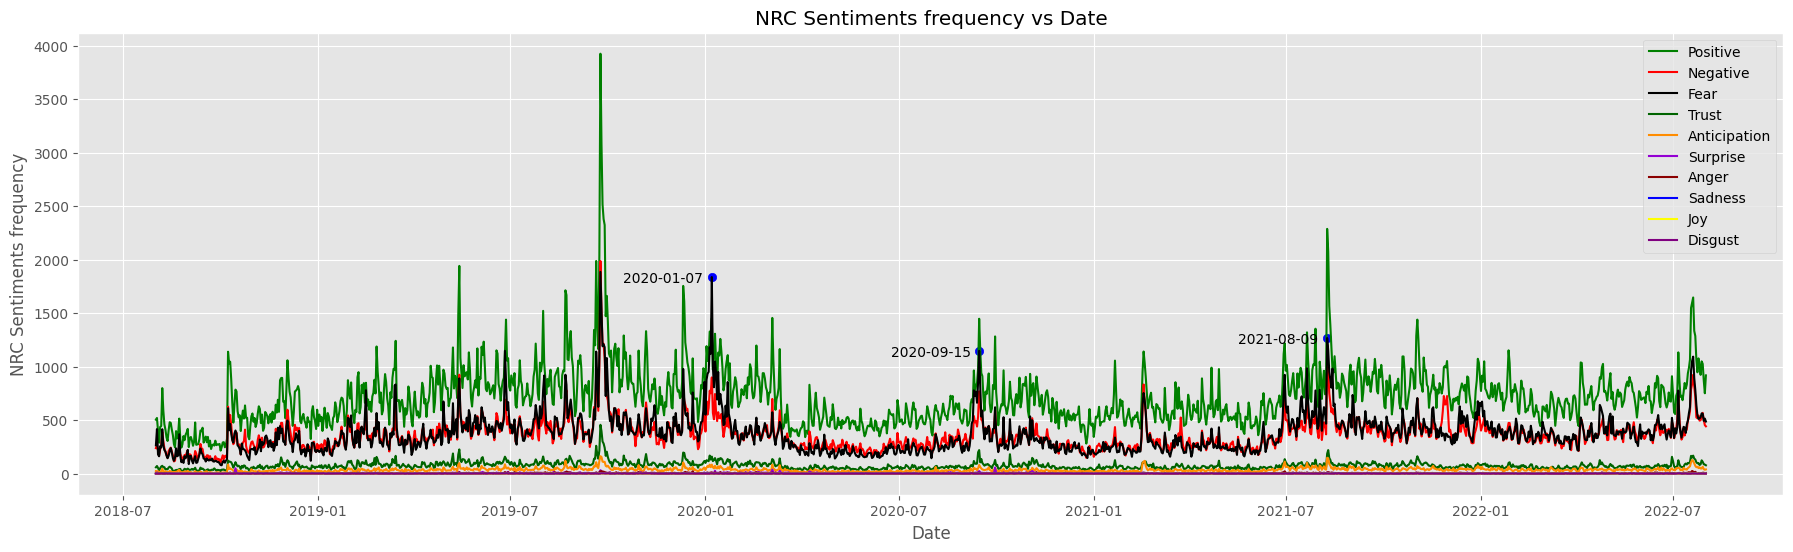

In [ ]:
# Slide 54-62
r_lex_grped_date_sentiment = r_lex_to_grp.filter(pl.col("NRC_Sentiment_List") == 1).groupby("comment_date", "NRC_Sentiments").agg(pl.count('body').alias('num_sentiment_comments'))

all_sentiments = ["fear", "anger", "anticipation", "trust", "surprise", "positive", "negative", "sadness", "disgust", "joy"]
missing_sentiments = []
day_sentiments = []
current_date = r_lex_grped_date_sentiment["comment_date"].min()
counter = 0

for comment_date, sentiment, num_comments in r_lex_grped_date_sentiment.sort("comment_date").iter_rows():
  counter += 1
  if len(day_sentiments) != len(all_sentiments):
    # Last one, will end with less than 10 since no more rows to iterate
    if counter == 11963:
      day_sentiments.append(sentiment)
      current_date = None

    if comment_date != current_date:
      for s in all_sentiments:
        if s not in day_sentiments:
          missing_sentiments.append({"comment_date": current_date,
                                     "NRC_Sentiments": s,
                                     "num_sentiment_comments": 0})
      day_sentiments = []
      day_sentiments.append(sentiment)
      current_date = comment_date
    else:
      day_sentiments.append(sentiment)

  else:
    day_sentiments = []
    day_sentiments.append(sentiment)
    current_date = comment_date
    continue

missing_sentiments_df = pl.from_dicts(missing_sentiments).with_columns(pl.col("comment_date").cast(pl.Datetime(time_unit="ns")), pl.col("NRC_Sentiments").cast(pl.Categorical), pl.col("num_sentiment_comments").cast(pl.UInt32))
r_lex_grped_date_sentiment_filled = pl.concat([r_lex_grped_date_sentiment, missing_sentiments_df]).sort("comment_date")
r_lex_grped_date_sentiment_filled_filtered= r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "positive")
r_lex_filter_fear = r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "fear")
r_lex_filter_fear_sorted = r_lex_filter_fear.sort("num_sentiment_comments").tail(10)

mplt.figure(figsize=(22, 6))
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled_filtered["num_sentiment_comments"], color='green', label="Positive")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "negative")["num_sentiment_comments"], color='red', label="Negative")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_filter_fear["num_sentiment_comments"], color='black', label="Fear")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "trust")["num_sentiment_comments"], color='darkgreen', label="Trust")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "anticipation")["num_sentiment_comments"], color='darkorange', label="Anticipation")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "surprise")["num_sentiment_comments"], color='darkviolet', label="Surprise")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "anger")["num_sentiment_comments"], color='darkred', label="Anger")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "sadness")["num_sentiment_comments"], color='blue', label="Sadness")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "joy")["num_sentiment_comments"], color='yellow', label="Joy")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "disgust")["num_sentiment_comments"], color='purple', label="Disgust")

for i, (comment_date, sentiment, num_comments) in enumerate(r_lex_filter_fear_sorted.iter_rows()):
  if i in [0, 6, 8]:
    annotate(text=comment_date.strftime('%Y-%m-%d'),
            xy=(comment_date, num_comments),
            xy_offset=(-35, -4))
    mplt.scatter(comment_date, num_comments, color="blue")

mplt.xlabel('Date')
mplt.ylabel('NRC Sentiments frequency')
mplt.title('NRC Sentiments frequency vs Date')
mplt.legend()
mplt.show()

In [ ]:
for a, b, c, d in reddit_df.filter(pl.col("comment_date") == datetime.strptime('2020-01-07', '%Y-%m-%d')).select(pl.col("comment_date", "permalink", "score", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

In [ ]:
for a, b, c, d in reddit_df.filter(pl.col("comment_date") == datetime.strptime('2020-09-15', '%Y-%m-%d')).select(pl.col("comment_date", "permalink", "score", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

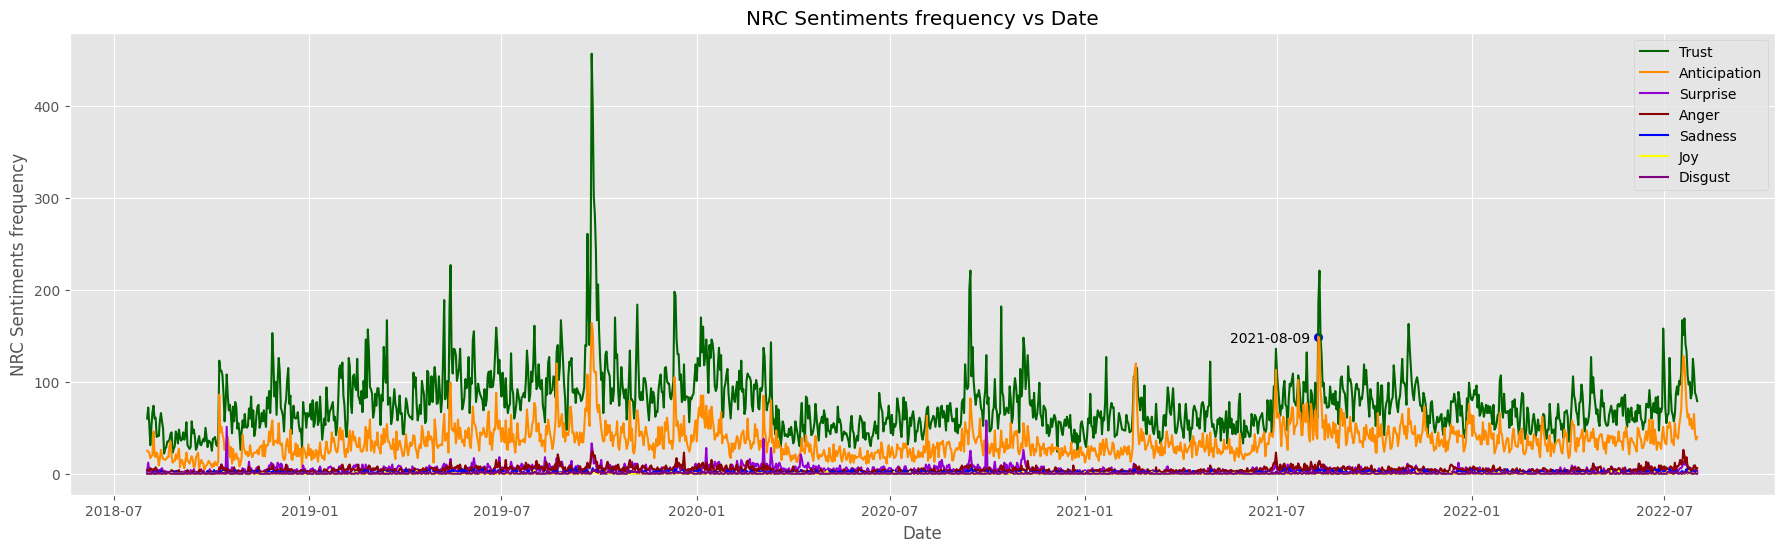

In [ ]:
r_lex_filter_anticip = r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "anticipation")
r_lex_filter_anticip_sorted = r_lex_filter_anticip.sort("num_sentiment_comments").tail(3)

mplt.figure(figsize=(22, 6))
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "trust")["num_sentiment_comments"], color='darkgreen', label="Trust")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_filter_anticip["num_sentiment_comments"], color='darkorange', label="Anticipation")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "surprise")["num_sentiment_comments"], color='darkviolet', label="Surprise")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "anger")["num_sentiment_comments"], color='darkred', label="Anger")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "sadness")["num_sentiment_comments"], color='blue', label="Sadness")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "joy")["num_sentiment_comments"], color='yellow', label="Joy")
mplt.plot(r_lex_grped_date_sentiment_filled_filtered["comment_date"], r_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "disgust")["num_sentiment_comments"], color='purple', label="Disgust")

for i, (comment_date, sentiment, num_comments) in enumerate(r_lex_filter_anticip_sorted.iter_rows()):
  if i in [0]:
    annotate(text=comment_date.strftime('%Y-%m-%d'),
            xy=(comment_date, num_comments),
            xy_offset=(-35, -4))
    mplt.scatter(comment_date, num_comments, color="blue")

mplt.xlabel('Date')
mplt.ylabel('NRC Sentiments frequency')
mplt.title('NRC Sentiments frequency vs Date')
mplt.legend()
mplt.show()

In [ ]:
for a, b, c, d in reddit_df.filter(pl.col("comment_date") == datetime.strptime('2021-08-09', '%Y-%m-%d')).select(pl.col("comment_date", "permalink", "score", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

#### Sentence-based Sentiment (VADER, Flair)

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
# !pip install flair
from flair.data import Sentence
from flair.nn import Classifier

# Most models suggest splitting up into sentences as they are trained on individual sentences, but this is both less accurate and more computationally intensive.
# Can take up to 200 words
def split_text_by_word_limit(text: str, word_limit: int = 200) -> list:
  sentences = nltk.sent_tokenize(text)
  paragraphs = []
  current_paragraph = []
  current_word_count = 0
  for sentence in sentences:
      words = sentence.split()
      sentence_word_count = len(words)
      if current_word_count + sentence_word_count > word_limit:
          paragraphs.append(" ".join(current_paragraph))
          #  Resetting
          current_paragraph = []
          current_word_count = 0
      current_paragraph.append(sentence)
      current_word_count += sentence_word_count
  if current_paragraph:
      paragraphs.append(" ".join(current_paragraph))
  return paragraphs

def get_sentence_score(paragraphs: list) -> tuple:
  vaders = []
  flairs = []
  for paragraph in paragraphs:
    vaders.append(vader.polarity_scores(paragraph)["compound"])

    sentence = Sentence(paragraph)
    flair.predict(sentence)
    try:
      if "POSITIVE" in str(sentence):
        flairs.append(sentence.score)
      else:
        flairs.append(sentence.score * -1)
    except:
      flairs.append(0)

  # Up to 200 words
  if len(vaders) == 1:
        most_polar_vader = vaders[0]
        most_polar_flair = flairs[0]
  else:
      # If need to be broken up into paragraphs, take the most extreme/polar sentiment
      if abs(min(vaders)) >= max(vaders):
          most_polar_vader = min(vaders)
      else:
          most_polar_vader = max(vaders)

      if abs(min(flairs)) >= max(flairs):
          most_polar_flair = min(flairs)
      else:
          most_polar_flair = max(flairs)

  return round(most_polar_vader, 2), round(most_polar_flair, 2)

vader = SentimentIntensityAnalyzer()
flair = Classifier.load('sentiment-fast')
r_sentence = r_lex.with_columns(
    pl.col("body").apply(split_text_by_word_limit).apply(get_sentence_score).alias("VADER_FLAIR"),
)
r_sentence = r_sentence.select(
    pl.all().exclude("VADER_FLAIR"),
    pl.col("VADER_FLAIR").apply(lambda x: x[0]).alias("VADER").cast(pl.Float32),
    pl.col("VADER_FLAIR").apply(lambda x: x[1]).alias("FLAIR").cast(pl.Float32),
)
r_sentence

shape: (3_237_761, 10)
┌────────────┬────────────┬───────────────┬──────────────┬───┬──────┬──────────────┬───────┬───────┐
│ comment_da ┆ subreddit. ┆ permalink     ┆ body         ┆ … ┆ NRC  ┆ NRC Top      ┆ VADER ┆ FLAIR │
│ te         ┆ name       ┆ ---           ┆ ---          ┆   ┆ ---  ┆ Sentiment    ┆ ---   ┆ ---   │
│ ---        ┆ ---        ┆ str           ┆ str          ┆   ┆ f32  ┆ ---          ┆ f32   ┆ f32   │
│ datetime[n ┆ str        ┆               ┆              ┆   ┆      ┆ cat          ┆       ┆       │
│ s]         ┆            ┆               ┆              ┆   ┆      ┆              ┆       ┆       │
╞════════════╪════════════╪═══════════════╪══════════════╪═══╪══════╪══════════════╪═══════╪═══════╡
│ 2018-08-01 ┆ unpopularo ┆ https://old.r ┆ That's what  ┆ … ┆ -3.0 ┆ fear         ┆ -0.38 ┆ 0.97  │
│ 00:00:00   ┆ pinion     ┆ eddit.com/r/u ┆ we worried   ┆   ┆      ┆              ┆       ┆       │
│            ┆            ┆ npopul…       ┆ about wit…   ┆   ┆      ┆              ┆       ┆       │
│ 2018-08-01 ┆ iama       ┆ https://old.r ┆ Hi Andrew! I ┆ … ┆ 0.0  ┆ fear, trust, ┆ -0.31 ┆ -0.99 │
│ 00:00:00   ┆            ┆ eddit.com/r/I ┆ was curious  ┆   ┆      ┆ surprise     ┆       ┆       │
│            ┆            ┆ AmA/co…       ┆ about w…     ┆   ┆      ┆              ┆       ┆       │
│ 2018-08-01 ┆ chapotraph ┆ https://old.r ┆              ┆ … ┆ -2.0 ┆ fear,        ┆ -0.78 ┆ -0.8  │
│ 00:00:00   ┆ ouse       ┆ eddit.com/r/C ┆ &gt;How are  ┆   ┆      ┆ negative     ┆       ┆       │
│            ┆            ┆ hapoTr…       ┆ the core     ┆   ┆      ┆              ┆       ┆       │
│            ┆            ┆               ┆ ideas behi…  ┆   ┆      ┆              ┆       ┆       │
│ 2018-08-01 ┆ europe     ┆ https://old.r ┆ Nonono       ┆ … ┆ 0.0  ┆ fear,        ┆ 0.0   ┆ -0.82 │
│ 00:00:00   ┆            ┆ eddit.com/r/e ┆ climate      ┆   ┆      ┆ anticipation ┆       ┆       │
│            ┆            ┆ urope/…       ┆ change just  ┆   ┆      ┆              ┆       ┆       │
│            ┆            ┆               ┆ start…       ┆   ┆      ┆              ┆       ┆       │
│ 2018-08-01 ┆ science    ┆ https://old.r ┆ Canada.      ┆ … ┆ 2.0  ┆ fear,        ┆ 0.0   ┆ 0.9   │
│ 00:00:00   ┆            ┆ eddit.com/r/s ┆ Forest fires ┆   ┆      ┆ positive     ┆       ┆       │
│            ┆            ┆ cience…       ┆ and heatwav… ┆   ┆      ┆              ┆       ┆       │
│ …          ┆ …          ┆ …             ┆ …            ┆ … ┆ …    ┆ …            ┆ …     ┆ …     │
│ 2022-08-01 ┆ magictruff ┆ https://old.r ┆ I am glad    ┆ … ┆ 4.0  ┆ positive     ┆ 0.94  ┆ 0.87  │
│ 00:00:00   ┆ le         ┆ eddit.com/r/M ┆ you liked it ┆   ┆      ┆              ┆       ┆       │
│            ┆            ┆ agicTr…       ┆ and had a…   ┆   ┆      ┆              ┆       ┆       │
│ 2022-08-01 ┆ ark        ┆ https://old.r ┆ You bought a ┆ … ┆ 3.0  ┆ positive     ┆ -0.72 ┆ 0.7   │
│ 00:00:00   ┆            ┆ eddit.com/r/A ┆ game to play ┆   ┆      ┆              ┆       ┆       │
│            ┆            ┆ RK/com…       ┆ on ser…      ┆   ┆      ┆              ┆       ┆       │
│ 2022-08-01 ┆ environmen ┆ https://old.r ┆ ***From      ┆ … ┆ 15.0 ┆ positive     ┆ -0.87 ┆ 0.78  │
│ 00:00:00   ┆ t          ┆ eddit.com/r/e ┆ reporters    ┆   ┆      ┆              ┆       ┆       │
│            ┆            ┆ nviron…       ┆ Meghan       ┆   ┆      ┆              ┆       ┆       │
│            ┆            ┆               ┆ McDonou…     ┆   ┆      ┆              ┆       ┆       │
│ 2022-08-01 ┆ worldnews  ┆ https://old.r ┆ This is the  ┆ … ┆ 2.0  ┆ fear,        ┆ -0.84 ┆ -1.0  │
│ 00:00:00   ┆            ┆ eddit.com/r/w ┆ problem with ┆   ┆      ┆ positive     ┆       ┆       │
│            ┆            ┆ orldne…       ┆ the gre…     ┆   ┆      ┆              ┆       ┆       │
│ 2022-08-01 ┆ politics   ┆ https://old.r ┆ None of the  ┆ … ┆ 1.0  ┆ fear         ┆ -0.69 ┆ -0.98 │
│ 00:00:00   ┆            ┆ eddit.com/

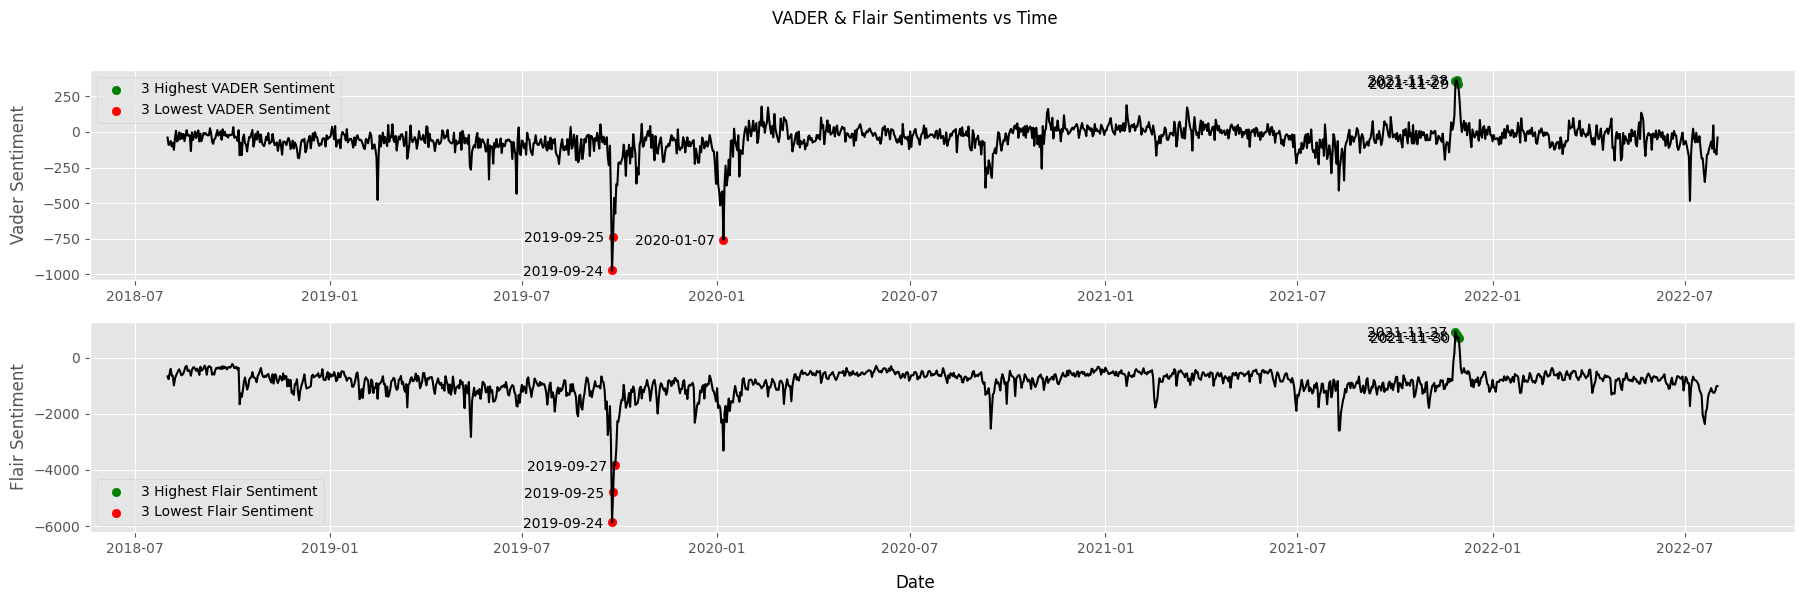

In [ ]:
# Slide 63, 64
r_sentence_vader_sum = r_sentence.groupby_dynamic('comment_date', every="1d").agg(pl.col('VADER').sum().alias("vader_sum"))
r_sentence_flair_sum = r_sentence.groupby_dynamic('comment_date', every="1d").agg(pl.col('FLAIR').sum().alias("flair_sum"))
vader_date_sorted = r_sentence_vader_sum.sort("vader_sum")
vader_date_filtered_high = vader_date_sorted.tail(3)
vader_date_filtered_low = vader_date_sorted.head(3)
flair_date_sorted = r_sentence_flair_sum.sort("flair_sum")
flair_date_filtered_high = flair_date_sorted.tail(3)
flair_date_filtered_low = flair_date_sorted.head(3)

fig, axes = mplt.subplots(2, 1, figsize=(22, 6))
axes[0].plot(r_sentence_vader_sum["comment_date"], r_sentence_vader_sum["vader_sum"], color='black')
axes[0].scatter(vader_date_filtered_high["comment_date"], vader_date_filtered_high["vader_sum"], color='green', label="3 Highest VADER Sentiment")
axes[0].scatter(vader_date_filtered_low["comment_date"], vader_date_filtered_low["vader_sum"], color='red', label="3 Lowest VADER Sentiment")
axes[0].set_ylabel('Vader Sentiment')
axes[0].legend()
axes[1].plot(r_sentence_flair_sum["comment_date"], r_sentence_flair_sum["flair_sum"], color='black')
axes[1].scatter(flair_date_filtered_high["comment_date"], flair_date_filtered_high["flair_sum"], color='green', label="3 Highest Flair Sentiment")
axes[1].scatter(flair_date_filtered_low["comment_date"], flair_date_filtered_low["flair_sum"], color='red', label="3 Lowest Flair Sentiment")
axes[1].set_ylabel('Flair Sentiment')
axes[1].legend()
fig.supxlabel("Date")
mplt.suptitle("VADER & Flair Sentiments vs Time")

for filtered_df, ax in [(vader_date_filtered_high, axes[0]), (vader_date_filtered_low, axes[0]), (flair_date_filtered_high, axes[1]), (flair_date_filtered_low, axes[1])]:
    for comment_date, sentiment in filtered_df.iter_rows():
      annotate(text=comment_date.strftime('%Y-%m-%d'),
              xy=(comment_date, sentiment),
              xy_offset=(-35, -4), ax=ax)

mplt.show()

In [ ]:
for a, b, c, d in r_sentence.filter((pl.col("comment_date").is_between(datetime.strptime('2021-11-27', '%Y-%m-%d'), datetime.strptime('2021-11-30', '%Y-%m-%d'))) & (~pl.col("body").str.contains("Bernie"))).select(pl.col("comment_date", "permalink",  "score", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

#### In-depth toxicity analysis (Perspective API)

In [ ]:
# Slide 21: Condition for "extremely negative" sentiment
# Negative sentiments would have higher toxicity
r_sentence = r_sentence.filter((pl.col("VADER") < -0.9) & (pl.col("FLAIR") < -0.9))
r_sentence = r_sentence.filter(~r_sentence["body"].is_duplicated())
r_sentence

shape: (226_102, 10)
┌────────────┬────────────┬────────────────┬───────────────┬───┬───────┬───────────┬───────┬───────┐
│ comment_da ┆ subreddit. ┆ permalink      ┆ body          ┆ … ┆ NRC   ┆ NRC Top   ┆ VADER ┆ FLAIR │
│ te         ┆ name       ┆ ---            ┆ ---           ┆   ┆ ---   ┆ Sentiment ┆ ---   ┆ ---   │
│ ---        ┆ ---        ┆ str            ┆ str           ┆   ┆ f32   ┆ ---       ┆ f32   ┆ f32   │
│ datetime[n ┆ str        ┆                ┆               ┆   ┆       ┆ cat       ┆       ┆       │
│ s]         ┆            ┆                ┆               ┆   ┆       ┆           ┆       ┆       │
╞════════════╪════════════╪════════════════╪═══════════════╪═══╪═══════╪═══════════╪═══════╪═══════╡
│ 2018-08-01 ┆ neoliberal ┆ https://old.re ┆ A carbon tax  ┆ … ┆ -7.0  ┆ negative  ┆ -0.91 ┆ -1.0  │
│ 00:00:00   ┆            ┆ ddit.com/r/neo ┆ is a tax on   ┆   ┆       ┆           ┆       ┆       │
│            ┆            ┆ libe…          ┆ atmosph…      ┆   ┆       ┆           ┆       ┆       │
│ 2018-08-01 ┆ wallstreet ┆ https://old.re ┆ It's          ┆ … ┆ -9.0  ┆ negative  ┆ -0.97 ┆ -1.0  │
│ 00:00:00   ┆ bets       ┆ ddit.com/r/wal ┆ literally in  ┆   ┆       ┆           ┆       ┆       │
│            ┆            ┆ lstr…          ┆ your first    ┆   ┆       ┆           ┆       ┆       │
│            ┆            ┆                ┆ lin…          ┆   ┆       ┆           ┆       ┆       │
│ 2018-08-01 ┆ mutantsand ┆ https://old.re ┆ 1)For first   ┆ … ┆ -17.0 ┆ negative  ┆ -0.99 ┆ -1.0  │
│ 00:00:00   ┆ mastermind ┆ ddit.com/r/mut ┆ question,     ┆   ┆       ┆           ┆       ┆       │
│            ┆ s          ┆ ants…          ┆ that's lik…   ┆   ┆       ┆           ┆       ┆       │
│ 2018-08-01 ┆ inthemorni ┆ https://old.re ┆ &gt; Climate  ┆ … ┆ 13.0  ┆ positive  ┆ -0.97 ┆ -1.0  │
│ 00:00:00   ┆ ng         ┆ ddit.com/r/int ┆ scientists    ┆   ┆       ┆           ┆       ┆       │
│            ┆            ┆ hemo…          ┆ who spea…     ┆   ┆       ┆           ┆       ┆       │
│ 2018-08-01 ┆ futurology ┆ https://old.re ┆ This is an    ┆ … ┆ -7.0  ┆ negative  ┆ -0.95 ┆ -0.96 │
│ 00:00:00   ┆            ┆ ddit.com/r/Fut ┆ interesting   ┆   ┆       ┆           ┆       ┆       │
│            ┆            ┆ urol…          ┆ thread.  …    ┆   ┆       ┆           ┆       ┆       │
│ …          ┆ …          ┆ …              ┆ …             ┆ … ┆ …     ┆ …         ┆ …     ┆ …     │
│ 2022-08-01 ┆ seenonnews ┆ https://old.re ┆ Was alive for ┆ … ┆ -11.0 ┆ negative  ┆ -0.97 ┆ -1.0  │
│ 00:00:00   ┆ _longtail  ┆ ddit.com/r/See ┆ an hour. The  ┆   ┆       ┆           ┆       ┆       │
│            ┆            ┆ nOnN…          ┆ origi…        ┆   ┆       ┆           ┆       ┆       │
│ 2022-08-01 ┆ askalibera ┆ https://old.re ┆ Nothing.  For ┆ … ┆ -1.0  ┆ negative  ┆ -0.97 ┆ -0.95 │
│ 00:00:00   ┆ l          ┆ ddit.com/r/Ask ┆ whatever      ┆   ┆       ┆           ┆       ┆       │
│            ┆            ┆ ALib…          ┆ reason, t…    ┆   ┆       ┆           ┆       ┆       │
│ 2022-08-01 ┆ dataisbeau ┆ https://old.re ┆ Per capita    ┆ … ┆ -4.0  ┆ negative, ┆ -0.95 ┆ -1.0  │
│ 00:00:00   ┆ tiful      ┆ ddit.com/r/dat ┆ yes the US    ┆   ┆       ┆ disgust   ┆       ┆       │
│            ┆            ┆ aisb…          ┆ pollutes b…   ┆   ┆       ┆           ┆       ┆       │
│ 2022-08-01 ┆ debateaveg ┆ https://old.re ┆ Reading below ┆ … ┆ 7.0   ┆ positive  ┆ -0.96 ┆ -1.0  │
│ 00:00:00   ┆ an         ┆ ddit.com/r/Deb ┆ (also you     ┆   ┆       ┆           ┆       ┆       │
│            ┆            ┆ ateA…          ┆ could ju…     ┆   ┆       ┆           ┆       ┆       │
│ 2022-08-01 ┆ deuxmoi    ┆ https://old.re ┆ It’s so tone  ┆ … ┆ -4.0  ┆ negative, ┆ -0.94 ┆ -1.0  │
│ 00:00:00   ┆            ┆ ddit.com/r/Deu ┆ deaf. My only ┆   ┆       ┆ sadness   ┆       ┆       │
│            ┆            ┆ xmoi…          ┆ takea…        ┆   ┆       ┆           ┆       ┆       │
└────────────┴────────────┴─────────────

In [ ]:
# Slide 65-71
from googleapiclient import discovery
import time

API_KEY = '...'
client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)
perspectives = {'FLIRTATION': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'IDENTITY_ATTACK': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'INSULT': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'PROFANITY': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'SEVERE_TOXICITY': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'SEXUALLY_EXPLICIT': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'THREAT': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'TOXICITY': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0}
                }
def perspective_analyze(text: str, API_KEY=None) -> list:
  if API_KEY:
        client = discovery.build(
            "commentanalyzer",
            "v1alpha1",
            developerKey=API_KEY,
            discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
            static_discovery=False,
        )
  req = {
    'comment': {'text': text, 'type': 'PLAIN_TEXT'},
    'requestedAttributes': perspectives,
    # "languages": ["en"]
  }
  try:
      response = client.comments().analyze(body=req).execute()
      result = [round(attrib_v["summaryScore"]["value"], 2) for attrib_k, attrib_v in sorted(
          response["attributeScores"].items())]
      count += 1
      print(count, result)
  except Exception as e:
      print(f"RETRYING: {e}")
      if "LANGUAGE_NOT_SUPPORTED_BY_ATTRIBUTE" in str(e):
          print(count, "LANGUAGE_NOT_SUPPORTED_BY_ATTRIBUTE")
          return [None for i in range(8)]
      time.sleep(5)
      result = perspective_analyze(
          text, "...")
  return result

r_perspective = r_sentence.with_columns(
    pl.col("body").apply(perspective_analyze).alias("perspectives"),
)

r_perspective = r_perspective.select(
  pl.all().exclude("perspectives"),
  pl.col("perspectives").apply(lambda x: x[0]).alias("FLIRTATION").cast(pl.Float32),
  pl.col("perspectives").apply(lambda x: x[1]).alias("IDENTITY_ATTACK").cast(pl.Float32),
  pl.col("perspectives").apply(lambda x: x[2]).alias("INSULT").cast(pl.Float32),
  pl.col("perspectives").apply(lambda x: x[3]).alias("PROFANITY").cast(pl.Float32),
  pl.col("perspectives").apply(lambda x: x[4]).alias("SEVERE_TOXICITY").cast(pl.Float32),
  pl.col("perspectives").apply(lambda x: x[5]).alias("SEXUALLY_EXPLICIT").cast(pl.Float32),
  pl.col("perspectives").apply(lambda x: x[6]).alias("THREAT").cast(pl.Float32),
  pl.col("perspectives").apply(lambda x: x[7]).alias("TOXICITY").cast(pl.Float32),
)
r_perspective

shape: (225_951, 18)
┌────────────┬────────────┬───────────┬──────────┬───┬────────────┬────────────┬────────┬──────────┐
│ comment_da ┆ subreddit. ┆ permalink ┆ body     ┆ … ┆ SEVERE_TOX ┆ SEXUALLY_E ┆ THREAT ┆ TOXICITY │
│ te         ┆ name       ┆ ---       ┆ ---      ┆   ┆ ICITY      ┆ XPLICIT    ┆ ---    ┆ ---      │
│ ---        ┆ ---        ┆ str       ┆ str      ┆   ┆ ---        ┆ ---        ┆ f32    ┆ f32      │
│ datetime[n ┆ str        ┆           ┆          ┆   ┆ f32        ┆ f32        ┆        ┆          │
│ s]         ┆            ┆           ┆          ┆   ┆            ┆            ┆        ┆          │
╞════════════╪════════════╪═══════════╪══════════╪═══╪════════════╪════════════╪════════╪══════════╡
│ 2018-08-01 ┆ neoliberal ┆ https://o ┆ A carbon ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.01   ┆ 0.03     │
│ 00:00:00   ┆            ┆ ld.reddit ┆ tax is a ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆ .com/r/ne ┆ tax on   ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆ olibe…    ┆ atmosph… ┆   ┆            ┆            ┆        ┆          │
│ 2018-08-01 ┆ wallstreet ┆ https://o ┆ It's lit ┆ … ┆ 0.0        ┆ 0.02       ┆ 0.01   ┆ 0.16     │
│ 00:00:00   ┆ bets       ┆ ld.reddit ┆ erally   ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆ .com/r/wa ┆ in your  ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆ llstr…    ┆ first    ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆           ┆ lin…     ┆   ┆            ┆            ┆        ┆          │
│ 2018-08-01 ┆ mutantsand ┆ https://o ┆ 1)For    ┆ … ┆ 0.01       ┆ 0.01       ┆ 0.14   ┆ 0.18     │
│ 00:00:00   ┆ mastermind ┆ ld.reddit ┆ first    ┆   ┆            ┆            ┆        ┆          │
│            ┆ s          ┆ .com/r/mu ┆ question ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆ tants…    ┆ , that's ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆           ┆ lik…     ┆   ┆            ┆            ┆        ┆          │
│ 2018-08-01 ┆ inthemorni ┆ https://o ┆ &gt;     ┆ … ┆ 0.01       ┆ 0.01       ┆ 0.01   ┆ 0.38     │
│ 00:00:00   ┆ ng         ┆ ld.reddit ┆ Climate  ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆ .com/r/in ┆ scientis ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆ themo…    ┆ ts who   ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆           ┆ spea…    ┆   ┆            ┆            ┆        ┆          │
│ 2018-08-01 ┆ futurology ┆ https://o ┆ This is  ┆ … ┆ 0.0        ┆ 0.01       ┆ 0.01   ┆ 0.05     │
│ 00:00:00   ┆            ┆ ld.reddit ┆ an inter ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆ .com/r/Fu ┆ esting   ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆ turol…    ┆ thread.  ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆           ┆ …        ┆   ┆            ┆            ┆        ┆          │
│ …          ┆ …          ┆ …         ┆ …        ┆ … ┆ …          ┆ …          ┆ …      ┆ …        │
│ 2022-08-01 ┆ seenonnews ┆ https://o ┆ Was      ┆ … ┆ 0.0        ┆ 0.02       ┆ 0.01   ┆ 0.03     │
│ 00:00:00   ┆ _longtail  ┆ ld.reddit ┆ alive    ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆ .com/r/Se ┆ for an   ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆ enOnN…    ┆ hour.    ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆           ┆ The      ┆   ┆            ┆            ┆        ┆          │
│            ┆            ┆           ┆ origi…   ┆   ┆            ┆            ┆        ┆          │
│ 2022-08-01 ┆ askalibera ┆ https://o ┆ Nothing. ┆ … ┆ 0.02       ┆ 0.39       ┆ 0.02   ┆ 0.43     │
│ 00:00:00   ┆ l          ┆ ld.reddit ┆ 

In [ ]:
for a, b, c, d in r_perspective.sort("FLIRTATION").select(pl.col("comment_date", "permalink", "score", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2021-08-19 00:00:00 https://old.reddit.com/r/teenagers/comments/p7dkxw/people_simping_over_14_yo_girls_on_this_sub/h9iwxwy/ 1 
 “Yeah, I'm fuckin' this bitch and she givin' me head She slide on the mutherfuckin' dick like a sled (Yeah) I told that lil' bitch "Livin' life on the edge" (Yeah, uh) Yeah, she ride on that dick like some muhfuckin' pegs I tug on her body, I grip on her legs Let's play a game of Simon Says Yell, yell, yell, yell (Yes) I fuck her, she scream and yell! I fuck her, she scream and yell Yo, Pi'erre, you wanna come out here Damn son, where'd you find this? I love Trippie Redd Yeah, I'm fuckin' this bitch and she givin' me head She slide on the muhfuckin' dick like a sled (Yeah) I told that lil' bitch "Livin' life on the edge" (Yeah, uh) Yeah (Uh), she ride on that dick like some muhfuckin' pegs I tug on her body, I grip on her legs Let's play a game of Simon Says Yell, yell, yell, yell (Yes) I fuck her, she scream and yell! I fuck her, she scream and yell Yell, yel

In [ ]:
for a, b, c, d in r_perspective.sort("IDENTITY_ATTACK").select(pl.col("comment_date", "permalink", "score", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2019-03-07 00:00:00 https://old.reddit.com/r/POLITIC/comments/axvz2w/when_90_of_the_top_100_most_polluted_cities_are/ehzhnm2/ 0 
 You are literally a fucking retard. everything I said was true. Again really simple you dumb fucking nigger with aids.

Your barbecue emits more than a car, a fire emits more than a car. Your cooking emits more than a car. You have extractor fans getting rid of the thick smoke from food and its fats these are bad for lungs. Where does the fan blow that air? And it doesn't remove all the emissions. Like smoking. Your building emits more than a car from your heating. Every time they renovate a building, or it has a fire or disaster,  or they make a building, lay a road, it causes pollution. Many of the materials have harmful dust. Carbons are released in every single thing we do. Everything. Carbon monoxide isn't necessarily released from everything it cannot be ingested because it's poisonous like smoking, but it also has a filter. But it's not what they are 

In [ ]:
for a, b, c, d in r_perspective.sort("INSULT").select(pl.col("comment_date", "permalink", "score", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2020-01-03 00:00:00 https://old.reddit.com/r/coolguides/comments/eizfry/spotting_bad_science/fcw8zfl/ 1 
 Nah son, you are a fucking idiot.

I said climate change doesn’t exist, there is no proof and if you say it does exist, YOU need to prove it. You dumb twat ... 
2021-12-09 00:00:00 https://old.reddit.com/r/pics/comments/rbwsnx/what_the_us_actually_needs_the_most/hntu7rz/ 1 
 No, if you voted for a racist, sexist, climate change denying fascist then you are a fucking piece of shit. End of discussion. You are a fucking piece of shit 
2019-02-27 00:00:00 https://old.reddit.com/r/POLITIC/comments/auy84d/study_green_new_deal_would_cost_93_trillion_over/ehd936w/ 1 
 You're fucking stupid. And a dumb nigger. I am sick to death of stupid niggers on this platform. All they do is insult what they don't understand attacking people. Your fucking ignorance is staggering. And to be frank I don't fucking care about what a stupid nigger has to fucking say. All they do is act prejudice attacking ev

In [ ]:
for a, b, c, d in r_perspective.sort("PROFANITY").select(pl.col("comment_date", "permalink", "score", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

In [ ]:
for a, b, c, d in r_perspective.sort("SEVERE_TOXICITY").select(pl.col("comment_date", "permalink", "score", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2019-12-09 00:00:00 https://old.reddit.com/r/AustraliaPics/comments/e88d9l/inspiring_photo_all_leaders_across_the_world/fa9timw/ 1 
 Fuck you fat old faggot bitch!

Climate Change is REAL! You’re are a bitch cunt dickhead for saying ‘leave ScoMo alone’

&amp;#x200B;

You’re an ugly cunt, go eat a dog’s penis and a cat’s balls. Fuck off and die of shit fuck shame. You’re a shit cunt 
2020-03-13 00:00:00 https://old.reddit.com/r/SubredditDrama/comments/fgy44a/bidens_brain_is_leaking_out_of_his_ears_trouble/fkczsyz/ 1 
 **AHAHAHAHAHA! GOD DAMN WHAT A FUCKING IDIOT YOU ARE, AND YOU SAID YOU WERE A FUCKING SCIENTIST!?!? BAWHAHAHAHAHA WHAT A FUCKING LIAR YOU ARE!!!!!!**

It's called **CLIMATE CHANGE** you fucking idiot. Like seriously, I say the world is dying before our eyes and you think I'm talking about Quantum Gravity... ARE YOU FUCKING SERIOUS!?!? LMFAO!!!!  Like holy fuck I am dying over here that you think you have any right to call yourself any besides a lying douchebag.


Seriously

In [ ]:
for a, b, c, d in r_perspective.sort("SEXUALLY_EXPLICIT").select(pl.col("comment_date", "permalink", "score", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

In [ ]:
for a, b, c, d in r_perspective.sort("THREAT").select(pl.col("comment_date", "permalink", "score", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

In [ ]:
for a, b, c, d in r_perspective.sort("TOXICITY").select(pl.col("comment_date", "permalink", "score", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2019-11-22 00:00:00 https://old.reddit.com/r/xrmed/comments/dzr386/xr_its_time_to_face_facts_wind_turbines_electric/f8cob1a/ 0 
 You fucking stupid dumb nazi cunt.
You watch too many movies, then come on the internet with your fucking mental shit.
You fucking dumb kid. Go and try violence on the Country, then I can sit back and watch you SHOT DEAD, then thrown in a shallow grave where you belong.
I want climate change to happen, just to see CUNTS like you BURN. 
2019-12-09 00:00:00 https://old.reddit.com/r/AustraliaPics/comments/e88d9l/inspiring_photo_all_leaders_across_the_world/fa9timw/ 1 
 Fuck you fat old faggot bitch!

Climate Change is REAL! You’re are a bitch cunt dickhead for saying ‘leave ScoMo alone’

&amp;#x200B;

You’re an ugly cunt, go eat a dog’s penis and a cat’s balls. Fuck off and die of shit fuck shame. You’re a shit cunt 
2020-01-07 00:00:00 https://old.reddit.com/r/worldnews/comments/ela9w9/australia_more_than_10000_camels_to_be_shot_from/fdgtnji/ 0 
 distill the fu

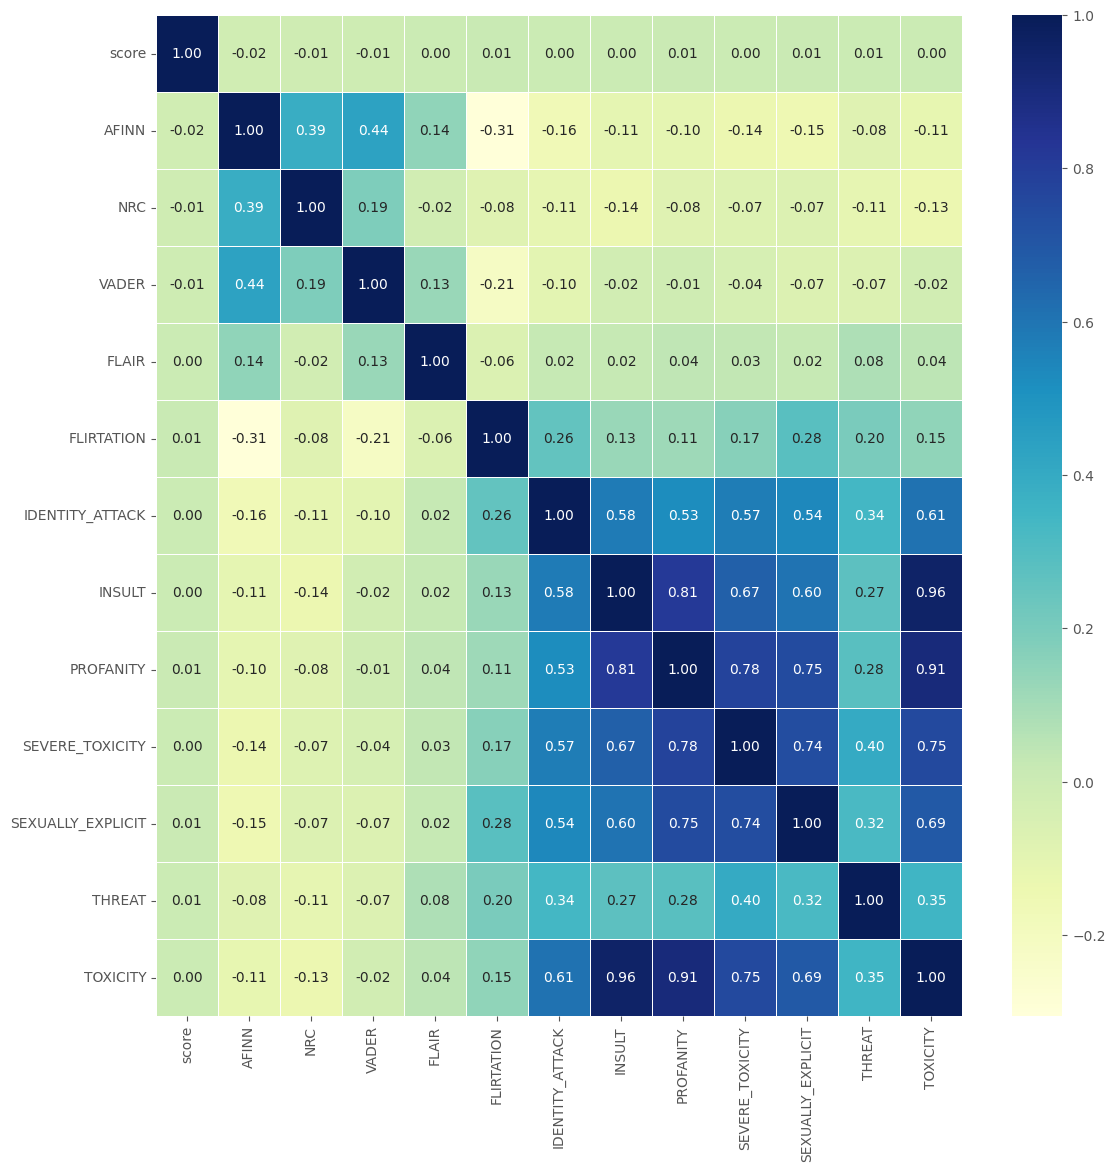

In [ ]:
# Slide 72
# Correlation Heatmap of numerical columns
r_perspective = r_perspective.drop(["comment_date", "subreddit.name", "permalink", "body", "NRC_Sentiments"])
size = len(r_perspective.columns)
fig, ax = mplt.subplots(figsize=(size, size))
heatmap = sb.heatmap(r_perspective.corr(), cmap="YlGnBu", linewidths=.5, fmt='.2f', annot=True)
ax.xaxis.set_ticklabels(r_perspective.columns, rotation=90)
ax.yaxis.set_ticklabels(r_perspective.columns, rotation=0)
mplt.show()

## Youtube

Youtube Comment's API do not provide a link to comment replies, thus are missing a link to the video. However, the parentId is provided, therefore some dataframe manipulation could be done to eventually get the link as well.

Screenshot below illustrates the cut-off between commentThreads (with link) and comment replies (with parentId, missing link) initially
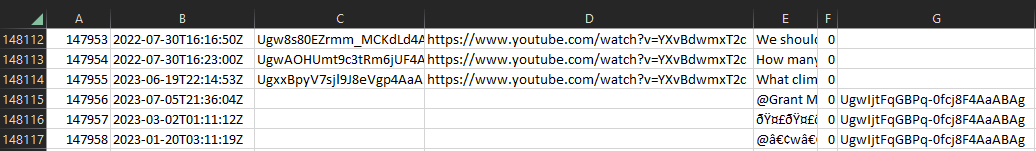

In [ ]:
# Removing unnamed column
yt_df = pl.read_csv(f"drive/My Drive/{FOLDERNAME}/data/youtube_climatechange_comments.arrow").select(pl.col('comment_date', 'id', 'link', 'body', 'like_count', 'parentId'))
yt_df = yt_df.with_columns(pl.col("comment_date").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%SZ").apply(lambda x: x.replace(hour=0, minute=0, second=0)), pl.col(["id", "link", "parentId"]).cast(pl.Categorical), pl.col("like_count").cast(pl.Int32))
print(f"Total no. of comments: {yt_df.shape[0]}")
print(f"Latest comment made on {yt_df['comment_date'].max()}")

# Removing Temporal Anormalies (Youtube comments made after specified time period 2018-08-01 - 2022-08-01, even when the videos fell into this period)
yt_df = yt_df.filter(pl.col("comment_date").is_between(datetime.strptime('2018-08-01', '%Y-%m-%d'), datetime.strptime('2022-08-01', '%Y-%m-%d')))
print(f"Total no. of comments after removal: {yt_df.shape[0]}")
print(f"Latest comment made on {yt_df['comment_date'].max()}")

# Joining on id & parentId to get the video link from commentThreads to comment replies
yt_threads = yt_df.filter(pl.col("parentId").is_null())
yt_replies =  yt_df.filter(pl.col("id").is_null())
yt_replies_new = []
for a_t, id_t, link_t, d_t, e_t, f_t in yt_threads.iter_rows():
  for a_r, b_r, c_r, d_r, e_r, parentId_r in yt_replies.iter_rows():
    if parentId_r == id_t:
      yt_replies_new.append({'comment_date': a_r, 'id': b_r, 'link': link_t, 'body': d_r, 'like_count': e_r, 'parentId': parentId_r})

yt_replies = pl.from_dicts(yt_replies_new).with_columns(
    pl.col(["id", "link", "parentId"]).cast(pl.Categorical), pl.col("like_count").cast(pl.Int32))
yt_df = pl.concat([yt_threads, yt_replies]).sort("comment_date")
yt_df

shape: (467_704, 6)
┌─────────────────┬────────────────┬────────────────┬────────────────┬────────────┬────────────────┐
│ comment_date    ┆ id             ┆ link           ┆ body           ┆ like_count ┆ parentId       │
│ ---             ┆ ---            ┆ ---            ┆ ---            ┆ ---        ┆ ---            │
│ datetime[μs]    ┆ cat            ┆ cat            ┆ str            ┆ i32        ┆ cat            │
╞═════════════════╪════════════════╪════════════════╪════════════════╪════════════╪════════════════╡
│ 2018-09-05      ┆ Ugztz4hRDSHKfq ┆ https://www.yo ┆ Do you have    ┆ 1          ┆ null           │
│ 00:00:00        ┆ bM9fB4AaABAg   ┆ utube.com/watc ┆ information    ┆            ┆                │
│                 ┆                ┆ h?v=…          ┆ about de…      ┆            ┆                │
│ 2018-09-05      ┆ Ugztz4hRDSHKfq ┆ https://www.yo ┆ Do you have    ┆ 1          ┆ null           │
│ 00:00:00        ┆ bM9fB4AaABAg   ┆ utube.com/watc ┆ information    ┆            ┆                │
│                 ┆                ┆ h?v=…          ┆ about de…      ┆            ┆                │
│ 2018-09-05      ┆ null           ┆ https://www.yo ┆ PhinkerPie -   ┆ 0          ┆ Ugztz4hRDSHKfq │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ too early to   ┆            ┆ bM9fB4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ know a…        ┆            ┆                │
│ 2018-09-05      ┆ null           ┆ https://www.yo ┆ PhinkerPie -   ┆ 0          ┆ Ugztz4hRDSHKfq │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ too early to   ┆            ┆ bM9fB4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ know a…        ┆            ┆                │
│ 2018-09-05      ┆ null           ┆ https://www.yo ┆ PhinkerPie -   ┆ 0          ┆ Ugztz4hRDSHKfq │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ too early to   ┆            ┆ bM9fB4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ know a…        ┆            ┆                │
│ …               ┆ …              ┆ …              ┆ …              ┆ …          ┆ …              │
│ 2022-07-31      ┆ null           ┆ https://www.yo ┆ @smart451cab   ┆ 0          ┆ UgxjQW4AMbKP9m │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ It would take  ┆            ┆ mSO5F4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ 22,00…         ┆            ┆                │
│ 2022-07-31      ┆ null           ┆ https://www.yo ┆ @Cyrribrae     ┆ 0          ┆ UgzD-oLSy84_n4 │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ "Humans can't  ┆            ┆ vnUGB4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ afford …       ┆            ┆                │
│ 2022-07-31      ┆ null           ┆ https://www.yo ┆ @Ivor Chandler ┆ 2          ┆ UgxJ2TPkdvirdR │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ How about you  ┆            ┆ 3kl2Z4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ che…           ┆            ┆                │
│ 2022-07-31      ┆ UgyPmlgZqcwlOK ┆ https://www.yo ┆ Al Gore:  what ┆ 1          ┆ null           │
│ 00:00:00        ┆ -5uEd4AaABAg   ┆ utube.com/watc ┆ about your     ┆            ┆                │
│                 ┆                ┆ h?v=…          ┆ multi-…        ┆            ┆                │
│ 2022-07-31      ┆ null           ┆ https://www.yo ┆ @Frank Booth   ┆ 0          ┆ UgyRekV0XrX4Bc │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ And read about ┆            ┆ Bsvwx4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ wha…           ┆            ┆                │
└─────────────────┴────────────────┴────────────────┴────────────────┴────────────┴────────────────┘

In [ ]:
# Checking no.of duplicates
yt_df.filter(yt_df["body"].is_duplicated())
yt_df = yt_df.filter(~yt_df["body"].is_duplicated()).sort("comment_date")

shape: (208_388, 6)
┌─────────────────┬────────────────┬────────────────┬────────────────┬────────────┬────────────────┐
│ comment_date    ┆ id             ┆ link           ┆ body           ┆ like_count ┆ parentId       │
│ ---             ┆ ---            ┆ ---            ┆ ---            ┆ ---        ┆ ---            │
│ datetime[μs]    ┆ cat            ┆ cat            ┆ str            ┆ i32        ┆ cat            │
╞═════════════════╪════════════════╪════════════════╪════════════════╪════════════╪════════════════╡
│ 2018-09-05      ┆ Ugztz4hRDSHKfq ┆ https://www.yo ┆ Do you have    ┆ 1          ┆ null           │
│ 00:00:00        ┆ bM9fB4AaABAg   ┆ utube.com/watc ┆ information    ┆            ┆                │
│                 ┆                ┆ h?v=…          ┆ about de…      ┆            ┆                │
│ 2018-09-05      ┆ Ugztz4hRDSHKfq ┆ https://www.yo ┆ Do you have    ┆ 1          ┆ null           │
│ 00:00:00        ┆ bM9fB4AaABAg   ┆ utube.com/watc ┆ information    ┆            ┆                │
│                 ┆                ┆ h?v=…          ┆ about de…      ┆            ┆                │
│ 2018-09-05      ┆ null           ┆ https://www.yo ┆ PhinkerPie -   ┆ 0          ┆ Ugztz4hRDSHKfq │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ too early to   ┆            ┆ bM9fB4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ know a…        ┆            ┆                │
│ 2018-09-05      ┆ null           ┆ https://www.yo ┆ PhinkerPie -   ┆ 0          ┆ Ugztz4hRDSHKfq │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ too early to   ┆            ┆ bM9fB4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ know a…        ┆            ┆                │
│ 2018-09-05      ┆ null           ┆ https://www.yo ┆ PhinkerPie -   ┆ 0          ┆ Ugztz4hRDSHKfq │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ too early to   ┆            ┆ bM9fB4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ know a…        ┆            ┆                │
│ …               ┆ …              ┆ …              ┆ …              ┆ …          ┆ …              │
│ 2022-07-31      ┆ UgzUhAqgz0JaD_ ┆ https://www.yo ┆ This video is  ┆ 0          ┆ null           │
│ 00:00:00        ┆ jGkMx4AaABAg   ┆ utube.com/watc ┆ full of facts  ┆            ┆                │
│                 ┆                ┆ h?v=…          ┆ and …          ┆            ┆                │
│ 2022-07-31      ┆ null           ┆ https://www.yo ┆ @smart451cab   ┆ 0          ┆ UgxjQW4AMbKP9m │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ It would take  ┆            ┆ mSO5F4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ 22,00…         ┆            ┆                │
│ 2022-07-31      ┆ null           ┆ https://www.yo ┆ @smart451cab   ┆ 0          ┆ UgxjQW4AMbKP9m │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ It would take  ┆            ┆ mSO5F4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ 22,00…         ┆            ┆                │
│ 2022-07-31      ┆ null           ┆ https://www.yo ┆ @smart451cab   ┆ 0          ┆ UgxjQW4AMbKP9m │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ It would take  ┆            ┆ mSO5F4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ 22,00…         ┆            ┆                │
│ 2022-07-31      ┆ null           ┆ https://www.yo ┆ @smart451cab   ┆ 0          ┆ UgxjQW4AMbKP9m │
│ 00:00:00        ┆                ┆ utube.com/watc ┆ It would take  ┆            ┆ mSO5F4AaABAg   │
│                 ┆                ┆ h?v=…          ┆ 22,00…         ┆            ┆                │
└─────────────────┴────────────────┴────────────────┴────────────────┴────────────┴────────────────┘

So many duplicates, could it be due to that many copy-pastes? or an error of my data collection? Either way, I'll remove them as 208388/467704 is quite significant (44.6%)

Available files:

- youtube_climatechange_comments (Raw)
- yt_sentence.drop("VADER", "FLAIR", axis=1) for yt_lex (Lexicon-based sentiment
(AFINN, NRC))
- yt_sentence (Sentence-based Sentiment (VADER, Flair))
- yt_perspective (In-depth toxicity analysis (Perspective API))


#### Exploratory

In [ ]:
# Slide 73
# !pip install wordcloud
from wordcloud import WordCloud
import regex as re
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import TweetTokenizer
nltk.download('punkt')
from string import punctuation, ascii_lowercase
import regex as re
from collections import Counter

with open(f"drive/My Drive/{FOLDERNAME}/data/stopwords_extra.json", "r") as file: stopwords_extra = set(json.load(file))
stopwords_nltk = set(stopwords.words('english'))
# !"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~
# Unicode symbols Eg. ' vs ’
punctuation += "–—― ̳‘’‚‛“”„†‡•...‰′′′‹›!! ̅⁄⁊"
stopwords_punct = set(punctuation)
stopwords_alphabets = set(ascii_lowercase)
combined_stoplist = list(set.union(stopwords_extra, stopwords_nltk, stopwords_punct, stopwords_alphabets))

# As the data was too large, I had to break it up into chunks
wc = WordCloud(width=1000, height=800, background_color="black")
counts_all = Counter()
tokenizer = TweetTokenizer()

for text in yt_df['body']:
    # Unicode Categories C (Control), M (Mark), S (Symbol), Z (Separator) + emojis
    re.compile(r'[\\p{C}|\\p{M}|\\p{S}|\\p{Z}]+',
               re.UNICODE).sub(" ", text)
    for word in tokenizer.tokenize(text):
        word = word.lower()
        if word not in combined_stoplist and not re.search("\d+", word):
            counts_all.update(wc.process_text(word))

wc.generate_from_frequencies(counts_all)
mplt.imshow(wc, interpolation='bilinear')
mplt.axis('off')

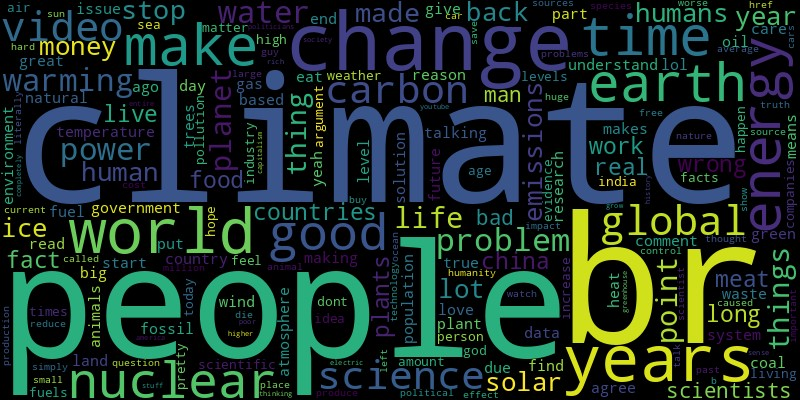

In [ ]:
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import TweetTokenizer
nltk.download('punkt')
from string import punctuation, ascii_lowercase
import regex as re
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

# Stopwords
with open(f"drive/My Drive/{FOLDERNAME}/data/stopwords_extra.json", "r") as file: stopwords_extra = set(json.load(file))
stopwords_nltk = set(stopwords.words('english'))
# !"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~
# Unicode symbols Eg. ' vs ’
punctuation += "–—― ̳‘’‚‛“”„†‡•...‰′′′‹›!! ̅⁄⁊"
stopwords_punct = set(punctuation)
stopwords_alphabets = set(ascii_lowercase)
combined_stoplist = list(set.union(stopwords_extra, stopwords_nltk, stopwords_punct, stopwords_alphabets))

# Lemmatization
def get_POS_tags(pos_tag):
  POS_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
  try:
    # Getting first 2 letters of pos_tag
    return POS_tag[pos_tag[:2]]
  except:
    # Fallback to noun (Default)
    return 'n'

class LemmaTokenizer(object):
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, corpus):
    return [self.wnl.lemmatize(word, pos=get_POS_tags(tag)) for word, tag in pos_tag(tokenizer.tokenize(corpus)) if not re.search("\d+", word)]

tokenizer = TweetTokenizer()
tf_vectorizer = CountVectorizer(stop_words=combined_stoplist, tokenizer=LemmaTokenizer())
tf = tf_vectorizer.fit_transform(reddit_df["body"])
print(f"No. of words per topic: {len(tf_vectorizer.get_feature_names_out())}")

# Using GridSearch for optimal number of topics
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA()
model = GridSearchCV(lda, param_grid={'n_components': [2, 4, 6, 8, 10]})
model.fit(tf)

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", model.best_estimator_.perplexity(tf))

No. of words per topic: 142690
Best Model's Params: {'n_components': 2}
Best Log Likelihood Score: -7432815.4723266065
Model Perplexity: 4359.44229564754


In [ ]:
# Slide 74: Topic Modelling
def get_model_topics(model, vectorizer, topics, n_top_words=10, detailed=False):
    word_dict = {}
    words = vectorizer.get_feature_names_out()
    if detailed:
        for topic_i, topic_freq in enumerate(model.components_):
            # Sorting indexes of words by top frequent topics
            top_freq_words_i = topic_freq.argsort()[:-n_top_words - 1:-1]
            # {topic: [(word, word_p), ...]}
            word_dict[topics[topic_i]] = [
                (words[i], topic_freq[i]/len(topic_freq)) for i in top_freq_words_i]
        return pl.DataFrame([(topic, word, freq) for topic, words in word_dict.items() for word, freq in words], columns=["Topic", "Word", "Probability"])

    else:
        for topic_i, topic_freq in enumerate(model.components_):
            top_freq_words_i = topic_freq.argsort()[:-n_top_words - 1:-1]
            # {topic: [word, ...]}
            word_dict[topics[topic_i]] = [words[i] for i in top_freq_words_i]
        return pl.DataFrame(word_dict)

yt_lda = LDA(n_components=2, random_state=1)
topic_per_document = yt_lda.fit_transform(tf)
# Frequency of each (142690) word-term per (2) topic
word_per_topic = yt_lda.components_

# Log Likelihood: ✅Less negative
print("Log Likelihood: ", yt_lda.score(tf))

# Perplexity: exp(-1 * log likelihood), ✅Lower
print("Perplexity: ", yt_lda.perplexity(tf))

yt_topics_words = get_model_topics(
    yt_lda, tf_vectorizer, ["Topic 1", "Topic 2"])
yt_topics_words

Log Likelihood: -34999861.64214264
Perplexity: 4432.3239812786915


shape: (10, 2)
┌─────────┬─────────┐
│ Topic 1 ┆ Topic 2 │
│ ---     ┆ ---     │
│ str     ┆ str     │
╞═════════╪═════════╡
│ climate ┆ people  │
│ <br>    ┆ make    │
│ change  ┆ ...     │
│ year    ┆ good    │
│ …       ┆ …       │
│ global  ┆ country │
│ people  ┆ world   │
│ science ┆ thing   │
│ time    ┆ power   │
└─────────┴─────────┘

Topic 1 could be Environmental science? More general

Topic 2 could be Sustainable energy? More specific, tells us "nuclear energy" is commonly associated with "good"

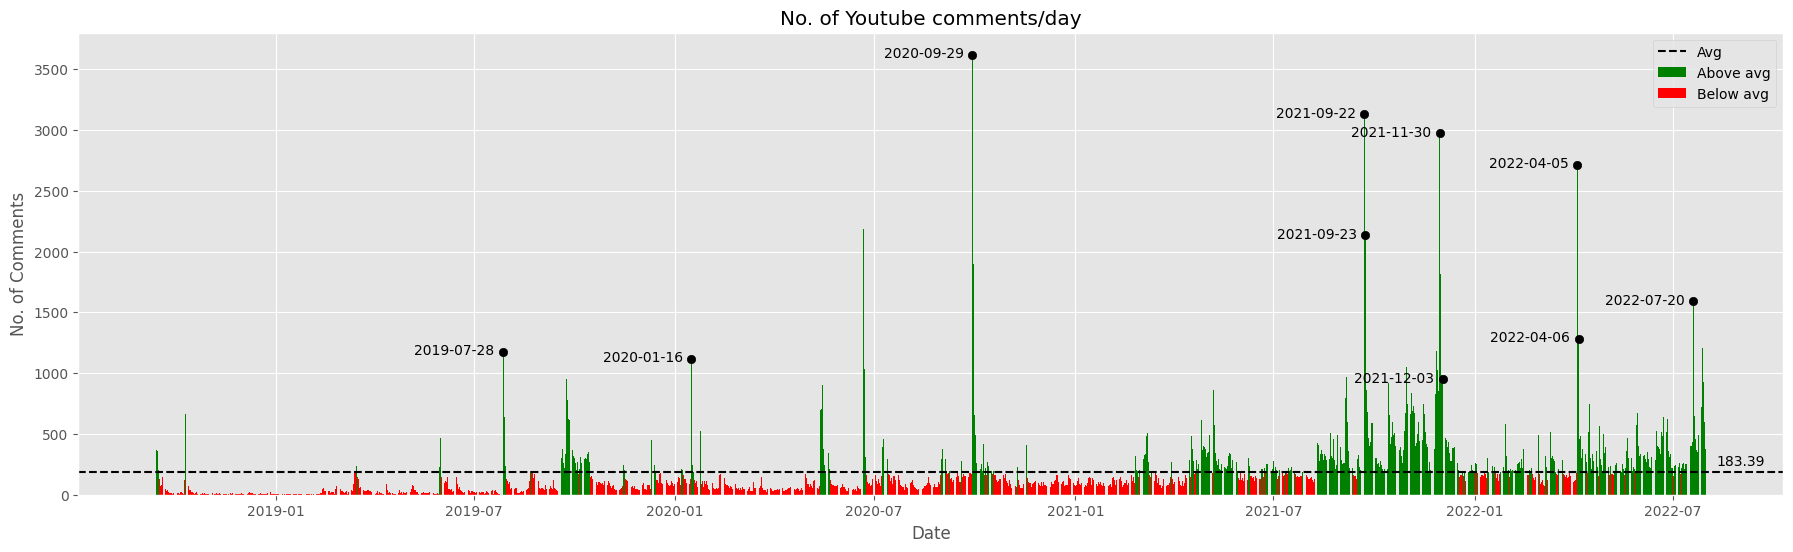

In [ ]:
# Slide 75-89
yt_comments_day = yt_df.groupby_dynamic('comment_date', every="1d").agg(pl.count('body').alias('num_comments'))
yt_avg_comments = yt_comments_day['num_comments'].mean()
yt_comments_day_above_avg = yt_comments_day.filter(yt_comments_day['num_comments'] >= yt_avg_comments)
yt_comments_day_below_avg = yt_comments_day.filter(yt_comments_day['num_comments'] < yt_avg_comments)
yt_filtered = yt_comments_day.sort("num_comments").tail(23)

mplt.figure(figsize=(22, 6))
mplt.bar(yt_comments_day_above_avg['comment_date'], yt_comments_day_above_avg['num_comments'], label='Above avg', color="green")
mplt.bar(yt_comments_day_below_avg['comment_date'], yt_comments_day_below_avg['num_comments'], label='Below avg', color="red")
mplt.axhline(y=yt_avg_comments, color='black', linestyle='--', label='Avg')
annotate(text=round(yt_avg_comments, 2),
         xy=(datetime.strptime('2022-09-01', '%Y-%m-%d'), yt_avg_comments),
         xy_offset=(0, 5))

for i, (comment_date, num_comments) in enumerate(yt_filtered.iter_rows()):
  if i in [0, 7, 8, 11, 14, 17, 19, 20, 21, 22]:
    annotate(text=comment_date.strftime('%Y-%m-%d'),
            xy=(comment_date, num_comments),
            xy_offset=(-35, -2))
    mplt.scatter(comment_date, num_comments, color="black")

mplt.xlabel('Date')
mplt.ylabel('No. of Comments')
mplt.title('No. of Youtube comments/day')
mplt.legend()
mplt.show()

In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date") == datetime.strptime('2019-07-28', '%Y-%m-%d')).select(pl.col("comment_date", "link", "like_count", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date") == datetime.strptime('2019-07-28', '%Y-%m-%d')).select(pl.col("comment_date", "link", "like_count", "body")).sort("like_count").tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2019-07-28 00:00:00 https://www.youtube.com/watch?v=6EFHZfISGp4 4617 
 Hey Goodhumans! This was one of the most requested episodes we’ve had. It was also one of the toughest to tackle for our team, but deeply illuminating for us as well. We hope the same for you.

Here at Jubilee, we believe in the value of open & honest discussions in order to pave a path towards empathy and develop a better understanding of people with different perspectives. Capturing the complexity and deeper nuances of a topic in a short period is incredibly difficult. However, we hope this discussion can inspire you to dive deeper and spark your own conversations. We’d love to be a part of it and hear your own insights below, so please share 🙂 
2019-07-28 00:00:00 https://www.youtube.com/watch?v=6EFHZfISGp4 5026 
 “Some people can’t water their lawns due to environmental restrictions.”

That’s such a first-world problem Lmao 
2019-07-28 00:00:00 https://www.youtube.com/watch?v=6EFHZfISGp4 5318 
 Lady: I know a gu

In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date").is_between(datetime.strptime('2019-09-24', '%Y-%m-%d'), datetime.strptime('2019-09-28', '%Y-%m-%d'))).select(pl.col("comment_date", "link", "like_count", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date") == datetime.strptime('2020-01-16', '%Y-%m-%d')).select(pl.col("comment_date", "link", "like_count", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date") == datetime.strptime('2020-06-21', '%Y-%m-%d')).select(pl.col("comment_date", "link", "like_count", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date").is_between(datetime.strptime('2020-09-29', '%Y-%m-%d'), datetime.strptime('2020-09-30', '%Y-%m-%d'))).select(pl.col("comment_date", "link", "like_count", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date").is_between(datetime.strptime('2021-09-22', '%Y-%m-%d'), datetime.strptime('2021-09-23', '%Y-%m-%d'))).select(pl.col("comment_date", "link", "like_count", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date") == datetime.strptime('2021-09-22', '%Y-%m-%d')).select(pl.col("comment_date", "link", "like_count", "body")).sort("like_count").tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2021-09-22 00:00:00 https://www.youtube.com/watch?v=yiw6_JakZFc 5978 
 I see what you did there with the thumbnail! This is such an important topic that way too many people are ignorant of, thanks for making this video. 
2021-09-22 00:00:00 https://www.youtube.com/watch?v=yiw6_JakZFc 6323 
 "we need politicians to..."

There's the problem. 
2021-09-22 00:00:00 https://www.youtube.com/watch?v=yiw6_JakZFc 45338 
 These next ten years will be very interesting indeed… 
2021-09-22 00:00:00 https://www.youtube.com/watch?v=yiw6_JakZFc 55456 
 The scary truth is, some humans will not care about something until they lose it 
2021-09-22 00:00:00 https://www.youtube.com/watch?v=yiw6_JakZFc 56261 
 This one's a heavy hitter. Thank you for making this and bringing awareness! 


In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date").is_between(datetime.strptime('2021-11-30', '%Y-%m-%d'), datetime.strptime('2021-12-01', '%Y-%m-%d'))).select(pl.col("comment_date", "link", "like_count", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date") == datetime.strptime('2021-11-30', '%Y-%m-%d')).select(pl.col("comment_date", "link", "like_count", "body")).sort("like_count").tail(10).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2021-11-30 00:00:00 https://www.youtube.com/watch?v=F1Hq8eVOMHs 2261 
 For all those asking why they didn't cover artificially produced meat - it's because it doesn't exist on a commercial scale yet. Nobody has managed to scale artificial meat production (as opposed to meat substitutes) to a scale where it's capable of being part of the solution. If it turns out to be possible to produce artificial meat cheaply en-masse then that would be great, but you can't rely on a technology that nobody has yet proved works (and is economically viable) on a large scale, and nobody is capable of predicting whether technology that doesn't currently exist might exist in the future. It's the same reason why nobody is going to suggest humanity will depend on nuclear fusion in a video on future energy - it'd be great if it became feasible, but nobody knows whether it ever will. 
2021-11-30 00:00:00 https://www.youtube.com/watch?v=F1Hq8eVOMHs 2306 
 Food is arguably the best thing in life and has an abil

In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date") == datetime.strptime('2022-04-05', '%Y-%m-%d')).select(pl.col("comment_date", "link", "like_count", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date") == datetime.strptime('2022-04-05', '%Y-%m-%d')).select(pl.col("comment_date", "link", "like_count", "body")).sort("like_count").tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2022-04-05 00:00:00 https://www.youtube.com/watch?v=LxgMdjyw8uw 5134 
 This actually hit me, it's so easy to fall into hopelessness with the constant barrage of bad news that you can't help but turn a blind eye to the progress we've made 
2022-04-05 00:00:00 https://www.youtube.com/watch?v=LxgMdjyw8uw 6000 
 6 months ago
“You cant fix climate change”
Now
“WE can fix climate change” 
2022-04-05 00:00:00 https://www.youtube.com/watch?v=LxgMdjyw8uw 13241 
 This is such a nice balance between the extremes of believing we’re all doomed and not believing in climate change at all 
2022-04-05 00:00:00 https://www.youtube.com/watch?v=LxgMdjyw8uw 26069 
 This has to be one of the most important videos on this platform. You've perfectly explained the calculated risk while simultaneously giving a genuine roadmap and positive point of view that will only benefit everyone. Hopefully this can bridge the divide between climate change activists and deniers; we're ALL in this together. 
2022-04-05 00:00

In [ ]:
for a, b, c, d in yt_df.filter(pl.col("comment_date").is_between(datetime.strptime('2022-07-20', '%Y-%m-%d'), datetime.strptime('2022-07-26', '%Y-%m-%d'))).select(pl.col("comment_date", "link", "like_count", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

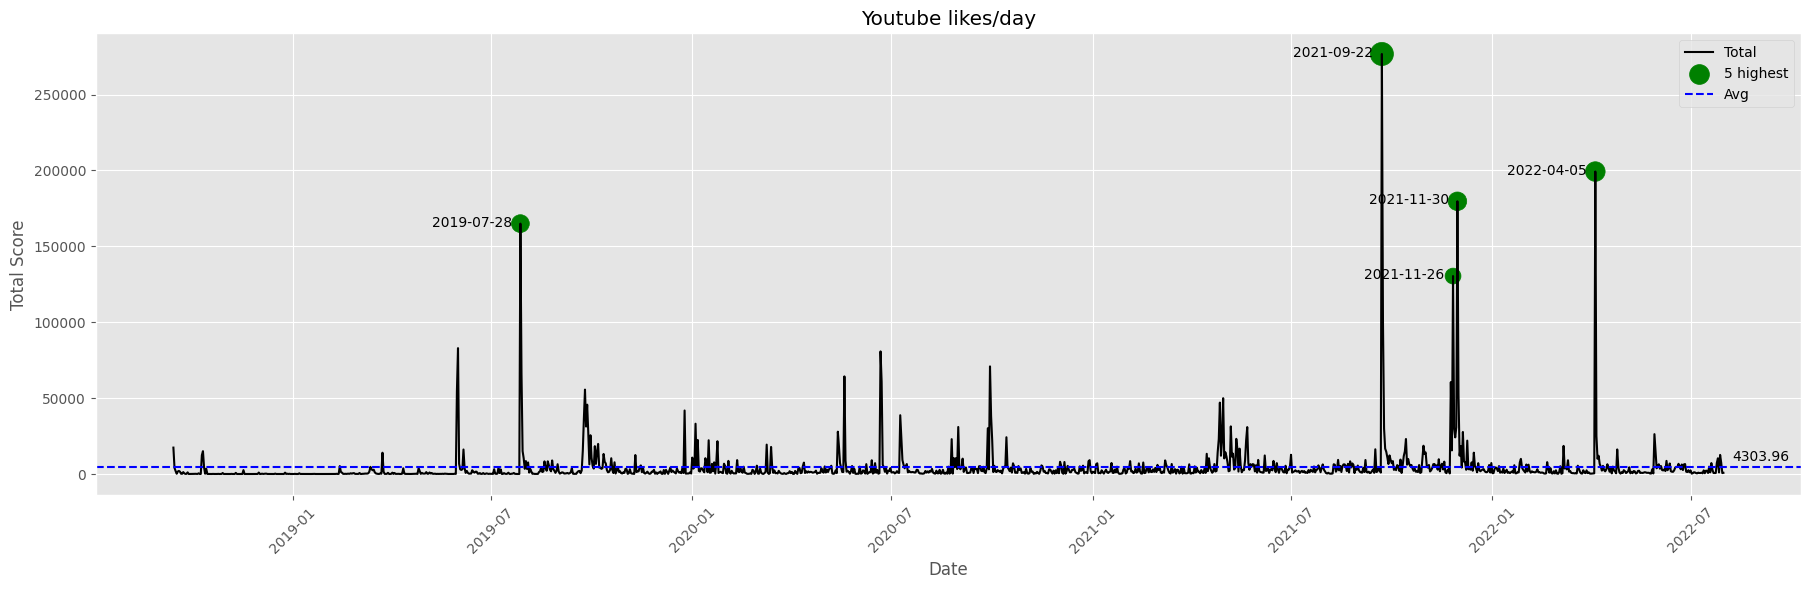

In [ ]:
# Slide 90
yt_score_day = yt_df.groupby_dynamic('comment_date', every="1d").agg(pl.col('like_count').sum().alias('total_likes'))
yt_avg_score = yt_score_day['total_likes'].mean()
yt_score_day_sorted = yt_score_day.sort("total_likes")
yt_highest_scores = yt_score_day_sorted.tail(5)

mplt.figure(figsize=(22, 6))
mplt.plot(yt_score_day['comment_date'], yt_score_day['total_likes'], label='Total', color="black")
mplt.scatter(yt_highest_scores['comment_date'], yt_highest_scores['total_likes'], label='5 highest', s=yt_highest_scores['total_likes'] * 0.001, color="green")
mplt.axhline(y=yt_avg_score, color='blue', linestyle='--', label='Avg')
annotate(text=round(yt_avg_score, 2),
         xy=(datetime.strptime('2022-09-01', '%Y-%m-%d'), yt_avg_score),
         xy_offset=(2, 5))

for comment_date, total_likes in yt_highest_scores.iter_rows():
  annotate(text=comment_date.strftime('%Y-%m-%d'),
           xy=(comment_date, total_likes),
           xy_offset=(-35, -2))

mplt.xlabel('Date')
mplt.ylabel('Total Score')
mplt.title('Youtube likes/day')
mplt.legend()
mplt.xticks(rotation=45)
mplt.show()

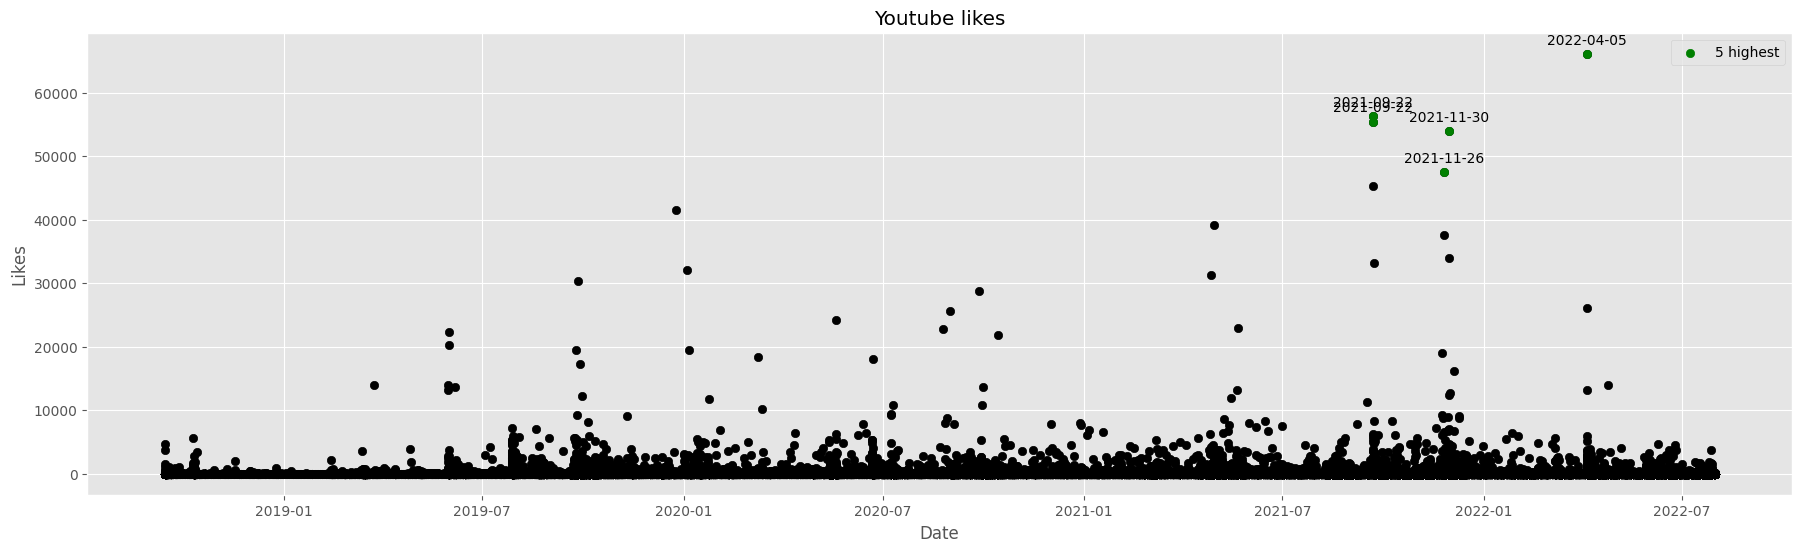

In [ ]:
# Slide 91
yt_comments_score_sorted = yt_df.sort("like_count").select(pl.col("comment_date", "like_count"))
yt_highest_comments = yt_comments_score_sorted.tail(5)

mplt.figure(figsize=(22, 6))
mplt.scatter(yt_df["comment_date"], yt_df["like_count"], color="black")
mplt.scatter(yt_comments_score_sorted["comment_date"].tail(5), yt_comments_score_sorted["like_count"].tail(5), label='5 highest', color="green")

for comment_date, score in yt_highest_comments.iter_rows():
  annotate(text=comment_date.strftime('%Y-%m-%d'),
           xy=(comment_date, score),
           xy_offset=(0, 7))

mplt.xlabel('Date')
mplt.ylabel('Likes')
mplt.title('Youtube likes')
mplt.legend()
mplt.show()

#### Lexicon-based sentiment (AFINN, NRC)

In [ ]:
# !pip install afinn
from afinn import Afinn
# !pip install NRCLex
from nrclex import NRCLex
import regex as re
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import TweetTokenizer
nltk.download('punkt')
from string import punctuation, ascii_lowercase
import regex as re
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

with open(f"drive/My Drive/{FOLDERNAME}/data/stopwords_extra.json", "r") as file: stopwords_extra = set(json.load(file))
stopwords_nltk = set(stopwords.words('english'))
# !"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~
# Unicode symbols Eg. ' vs ’
punctuation += "–—― ̳‘’‚‛“”„†‡•...‰′′′‹›!! ̅⁄⁊"
stopwords_punct = set(punctuation)
stopwords_alphabets = set(ascii_lowercase)
combined_stoplist = list(set.union(stopwords_extra, stopwords_nltk, stopwords_punct, stopwords_alphabets))

# Convert pos_tag tags to WordNet's POS tags
def get_POS_tags(pos_tag):
  POS_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
  try:
    # Getting first 2 letters of pos_tag
    return POS_tag[pos_tag[:2]]
  except:
    # Fallback to noun (Default)
    return 'n'

def lexicon_score(text: str) -> tuple:
    # Splits intelligently on whitespaces, some punctuation
    tokenized_words = tokenizer.tokenize(text.lower())
    # Unicode Categories C (Control), M (Mark), S (Symbol), Z (Separator) + emojis
    stopwords_removed = [re.compile(r'[\p{C}|\p{M}|\p{S}|\p{Z}]+', re.UNICODE).sub(" ", word).strip() for word in tokenized_words if word not in combined_stoplist and not re.search("\d+", word)]
    # Lemmatization Eg. happier (no score) => happy (3.0)
    lemmatized_joined = " ".join([wnl.lemmatize(word, pos=get_POS_tags(tag)) for word, tag in pos_tag(stopwords_removed)])

    NRC_emotions = NRCLex(lemmatized_joined)
    NRC_emotions_str = ', '.join(emotion[0] for emotion in NRC_emotions.top_emotions)
    return str(afinn.score(lemmatized_joined)), str(round(NRC_emotions.raw_emotion_scores.get("positive", 0) - NRC_emotions.raw_emotion_scores.get("negative", 0), 2)), NRC_emotions_str

tokenizer = TweetTokenizer()
wnl = WordNetLemmatizer()
afinn = Afinn()
yt_lex = yt_df.with_columns(
    pl.col("body").apply(lexicon_score).alias("AFINN_NRC")
)
yt_lex = yt_lex.select(
    pl.all().exclude("AFINN_NRC"),
    pl.col("AFINN_NRC").apply(lambda x: x[0]).alias("AFINN").cast(pl.Float32),
    pl.col("AFINN_NRC").apply(lambda x: x[1]).alias("NRC").cast(pl.Float32),
    pl.col("AFINN_NRC").apply(lambda x: x[2]).alias("NRC_Sentiments").cast(pl.Categorical)
)
yt_lex

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


shape: (259_316, 9)
┌────────────┬─────────────┬─────────────┬────────────┬───┬────────────┬───────┬──────┬────────────┐
│ comment_da ┆ id          ┆ link        ┆ body       ┆ … ┆ parentId   ┆ AFINN ┆ NRC  ┆ NRC_Sentim │
│ te         ┆ ---         ┆ ---         ┆ ---        ┆   ┆ ---        ┆ ---   ┆ ---  ┆ ents       │
│ ---        ┆ cat         ┆ cat         ┆ str        ┆   ┆ cat        ┆ f32   ┆ f32  ┆ ---        │
│ datetime[μ ┆             ┆             ┆            ┆   ┆            ┆       ┆      ┆ cat        │
│ s]         ┆             ┆             ┆            ┆   ┆            ┆       ┆      ┆            │
╞════════════╪═════════════╪═════════════╪════════════╪═══╪════════════╪═══════╪══════╪════════════╡
│ 2018-09-14 ┆ null        ┆ https://www ┆ kikivoorbu ┆ … ┆ UgxrDOROxx ┆ 4.0   ┆ 0.0  ┆ fear,      │
│ 00:00:00   ┆             ┆ .youtube.co ┆ rg wow 😮  ┆   ┆ h-KTdNqf94 ┆       ┆      ┆ anger,     │
│            ┆             ┆ m/watch?v=… ┆ it’s only  ┆   ┆ AaABAg     ┆       ┆      ┆ anticip,   │
│            ┆             ┆             ┆ 9:3…       ┆   ┆            ┆       ┆      ┆ trust,     │
│            ┆             ┆             ┆            ┆   ┆            ┆       ┆      ┆ sur…       │
│ 2018-09-14 ┆ UgxVCO1BnAL ┆ https://www ┆ The earth  ┆ … ┆ null       ┆ 0.0   ┆ 0.0  ┆ fear,      │
│ 00:00:00   ┆ I6YO7Vp54Aa ┆ .youtube.co ┆ has        ┆   ┆            ┆       ┆      ┆ anger,     │
│            ┆ ABAg        ┆ m/watch?v=… ┆ already    ┆   ┆            ┆       ┆      ┆ positive,  │
│            ┆             ┆             ┆ done       ┆   ┆            ┆       ┆      ┆ negative,… │
│            ┆             ┆             ┆ it...…     ┆   ┆            ┆       ┆      ┆            │
│ 2018-09-14 ┆ UgwJvvwa6As ┆ https://www ┆ Oh, <i>you ┆ … ┆ null       ┆ -4.0  ┆ -1.0 ┆ trust      │
│ 00:00:00   ┆ yqP4qsVp4Aa ┆ .youtube.co ┆ r</i>      ┆   ┆            ┆       ┆      ┆            │
│            ┆ ABAg        ┆ m/watch?v=… ┆ country is ┆   ┆            ┆       ┆      ┆            │
│            ┆             ┆             ┆ going…     ┆   ┆            ┆       ┆      ┆            │
│ 2018-09-14 ┆ UgwisLALVH9 ┆ https://www ┆ real       ┆ … ┆ null       ┆ 0.0   ┆ 1.0  ┆ trust,     │
│ 00:00:00   ┆ y0uQ9mBh4Aa ┆ .youtube.co ┆ enginering ┆   ┆            ┆       ┆      ┆ positive   │
│            ┆ ABAg        ┆ m/watch?v=… ┆ give me a  ┆   ┆            ┆       ┆      ┆            │
│            ┆             ┆             ┆ heart      ┆   ┆            ┆       ┆      ┆            │
│ 2018-09-14 ┆ UgyXIdjDb-d ┆ https://www ┆ I&#39;m a  ┆ … ┆ null       ┆ 0.0   ┆ 1.0  ┆ anticipati │
│ 00:00:00   ┆ yws7Irsd4Aa ┆ .youtube.co ┆ simple     ┆   ┆            ┆       ┆      ┆ on         │
│            ┆ ABAg        ┆ m/watch?v=… ┆ man. I see ┆   ┆            ┆       ┆      ┆            │
│            ┆             ┆             ┆ a ne…      ┆   ┆            ┆       ┆      ┆            │
│ …          ┆ …           ┆ …           ┆ …          ┆ … ┆ …          ┆ …     ┆ …    ┆ …          │
│ 2022-07-31 ┆ null        ┆ https://www ┆ In the     ┆ … ┆ UgynwWEGW8 ┆ 1.0   ┆ 1.0  ┆ positive   │
│ 00:00:00   ┆             ┆ .youtube.co ┆ last few   ┆   ┆ 6JpAi6rKV4 ┆       ┆      ┆            │
│            ┆             ┆ m/watch?v=… ┆ thousand   ┆   ┆ AaABAg     ┆       ┆      ┆            │
│            ┆             ┆             ┆ years g…   ┆   ┆            ┆       ┆      ┆            │
│ 2022-07-31 ┆ null        ┆ https://www ┆ @Cyrribrae ┆ … ┆ UgzD-oLSy8 ┆ 2.0   ┆ -2.0 ┆ negative   │
│ 00:00:00   ┆             ┆ .youtube.co ┆ "Humans    ┆   ┆ 4_n4vnUGB4 ┆       ┆      ┆            │
│            ┆             ┆ m/watch?v=… ┆ can't      ┆   ┆ AaABAg     ┆       ┆      ┆            │
│            ┆             ┆             ┆ afford …   ┆   ┆            ┆       ┆      ┆            │
│ 2022-07-31 ┆ null        ┆ https://www ┆ @Ivor      ┆ … ┆ UgxJ2TPkdv ┆ 2.0   ┆ 1.0  ┆ surprise,  │
│ 00:00:00   ┆             ┆ .youtube.co ┆

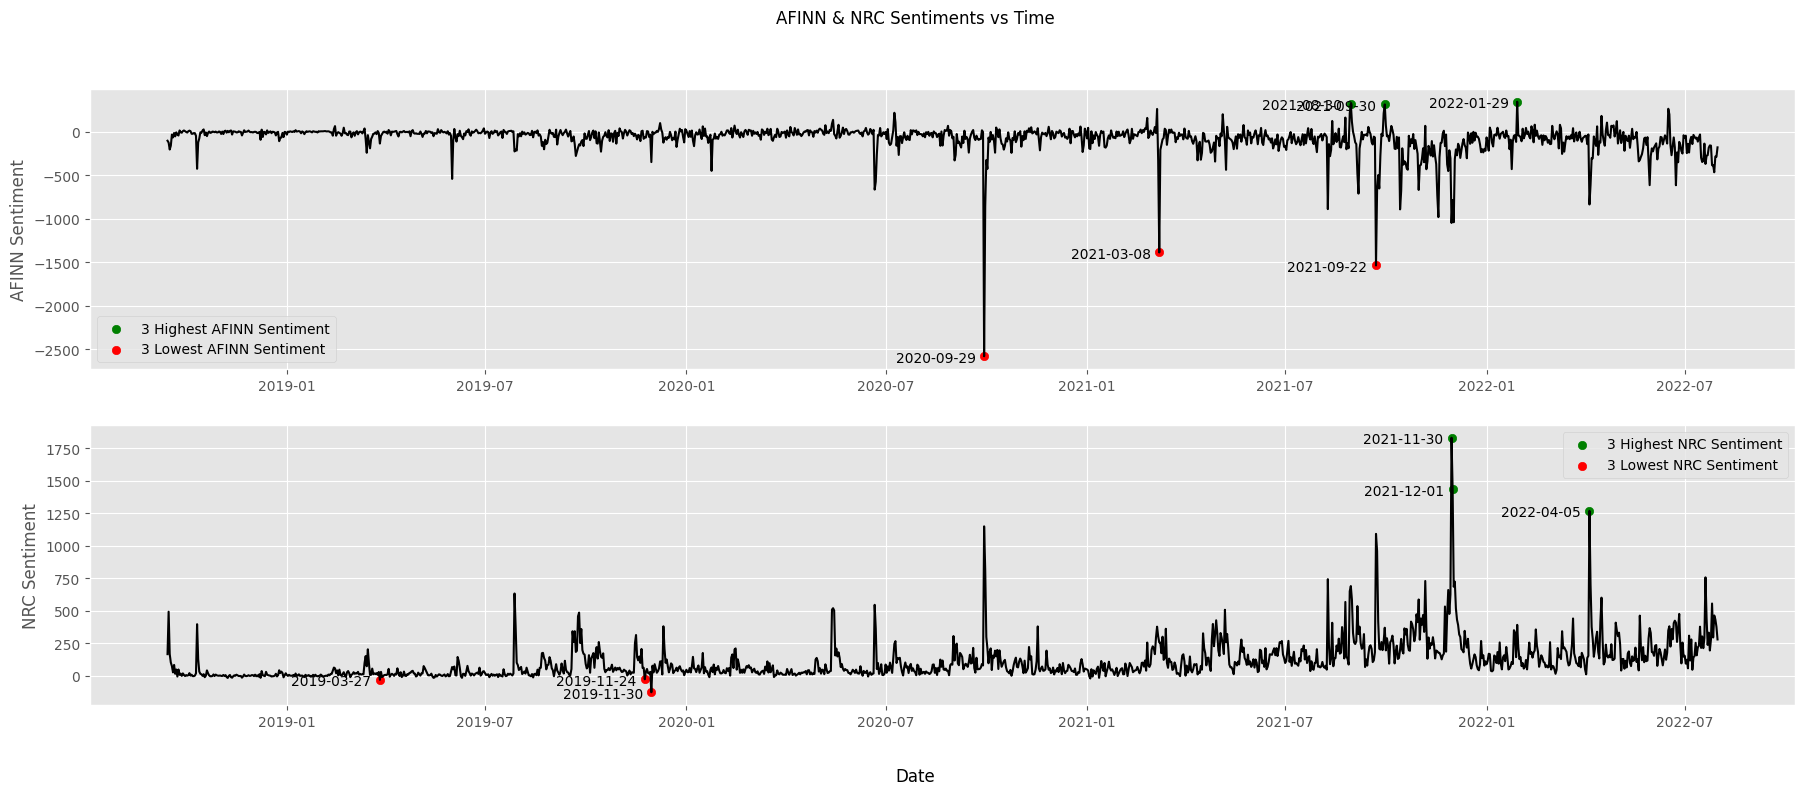

In [ ]:
# Slide 92
yt_lex_afinn_sum = yt_lex.groupby_dynamic('comment_date', every="1d").agg(pl.col('AFINN').sum().alias("afinn_sum"))
yt_lex_nrc_sum = yt_lex.groupby_dynamic('comment_date', every="1d").agg(pl.col('NRC').sum().alias("nrc_sum"))
afinn_date_sorted = yt_lex_afinn_sum.sort("afinn_sum")
afinn_date_filtered_high = afinn_date_sorted.tail(3)
afinn_date_filtered_low = afinn_date_sorted.head(3)
nrc_date_sorted = yt_lex_nrc_sum.sort("nrc_sum")
nrc_date_filtered_high = nrc_date_sorted.tail(3)
nrc_date_filtered_low = nrc_date_sorted.head(3)

fig, axes = mplt.subplots(2, 1, figsize=(22, 8))
axes[0].plot(yt_lex_afinn_sum["comment_date"], yt_lex_afinn_sum["afinn_sum"], color='black')
axes[0].scatter(afinn_date_filtered_high["comment_date"], afinn_date_filtered_high["afinn_sum"], color='green', label="3 Highest AFINN Sentiment")
axes[0].scatter(afinn_date_filtered_low["comment_date"], afinn_date_filtered_low["afinn_sum"], color='red', label="3 Lowest AFINN Sentiment")
axes[0].set_ylabel('AFINN Sentiment')
axes[0].legend()
axes[1].plot(yt_lex_nrc_sum["comment_date"], yt_lex_nrc_sum["nrc_sum"], color='black')
axes[1].scatter(nrc_date_filtered_high["comment_date"], nrc_date_filtered_high["nrc_sum"], color='green', label="3 Highest NRC Sentiment")
axes[1].scatter(nrc_date_filtered_low["comment_date"], nrc_date_filtered_low["nrc_sum"], color='red', label="3 Lowest NRC Sentiment")
axes[1].set_ylabel('NRC Sentiment')
axes[1].legend()
fig.supxlabel("Date")
mplt.suptitle("AFINN & NRC Sentiments vs Time")

for filtered_df, ax in [(afinn_date_filtered_high, axes[0]), (afinn_date_filtered_low, axes[0]), (nrc_date_filtered_high, axes[1]), (nrc_date_filtered_low, axes[1])]:
    for comment_date, sentiment in filtered_df.iter_rows():
      annotate(text=comment_date.strftime('%Y-%m-%d'),
              xy=(comment_date, sentiment),
              xy_offset=(-35, -4), ax=ax)

mplt.show()

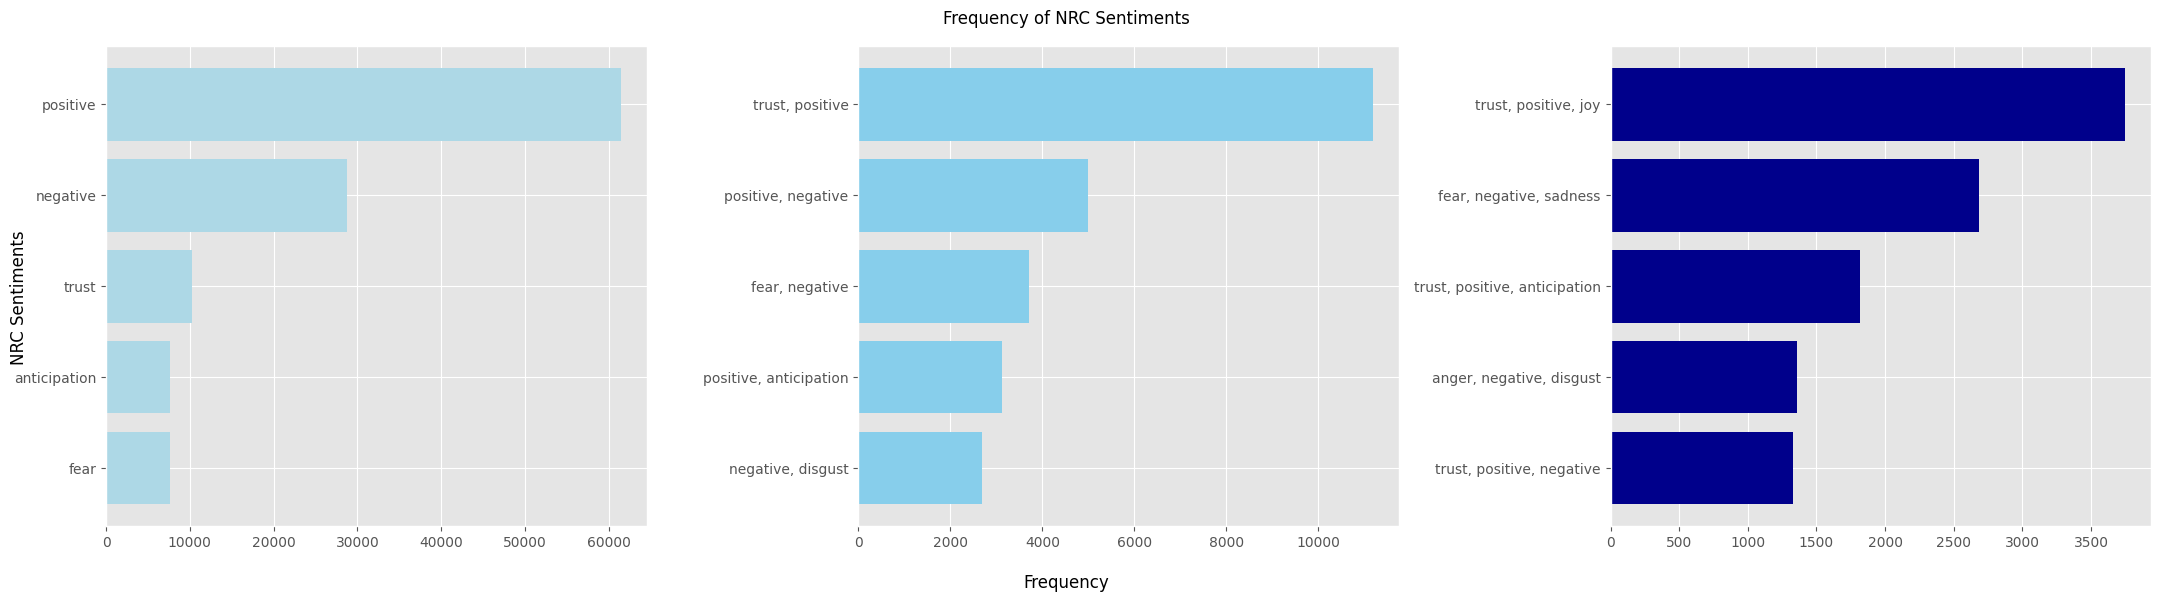

In [ ]:
# Slide 93, 94
yt_lex_to_grp = yt_lex.select(pl.col("*"), pl.col("NRC_Sentiments").apply(lambda x: len(x.split(","))).alias("NRC_Sentiment_List"))
yt_lex_grped_1g_sentiments = yt_lex_to_grp.filter(pl.col("NRC_Sentiment_List") == 1).groupby("NRC_Sentiments").agg(pl.count('body').alias('num_top_1g_sentiments')).sort("num_top_1g_sentiments")
yt_lex_grped_2g_sentiments = yt_lex_to_grp.filter(pl.col("NRC_Sentiment_List") == 2).groupby("NRC_Sentiments").agg(pl.count('body').alias('num_top_2g_sentiments')).sort("num_top_2g_sentiments")
yt_lex_grped_3g_sentiments = yt_lex_to_grp.filter(pl.col("NRC_Sentiment_List") == 3).groupby("NRC_Sentiments").agg(pl.count('body').alias('num_top_3g_sentiments')).sort("num_top_3g_sentiments")


fig, axes = mplt.subplots(1, 3, figsize=(22, 6))
axes[0].barh(yt_lex_grped_1g_sentiments['NRC_Sentiments'].tail(5), yt_lex_grped_1g_sentiments['num_top_1g_sentiments'].tail(5), color='lightblue')
axes[1].barh(yt_lex_grped_2g_sentiments['NRC_Sentiments'].tail(5), yt_lex_grped_2g_sentiments['num_top_2g_sentiments'].tail(5), color='skyblue')
axes[2].barh(yt_lex_grped_3g_sentiments['NRC_Sentiments'].tail(5), yt_lex_grped_3g_sentiments['num_top_3g_sentiments'].tail(5), color='darkblue')
fig.supylabel("NRC Sentiments")
fig.supxlabel("Frequency")
mplt.suptitle("Frequency of NRC Sentiments")
mplt.tight_layout()
mplt.show()

In [ ]:
for a, b, c, d in yt_lex.filter(pl.col("NRC_Sentiments") == "negative, disgust").select(pl.col("comment_date", "link", "like_count", "body")).sample(500).iter_rows(): print(a, b, c, "\n", d, "\n==============")

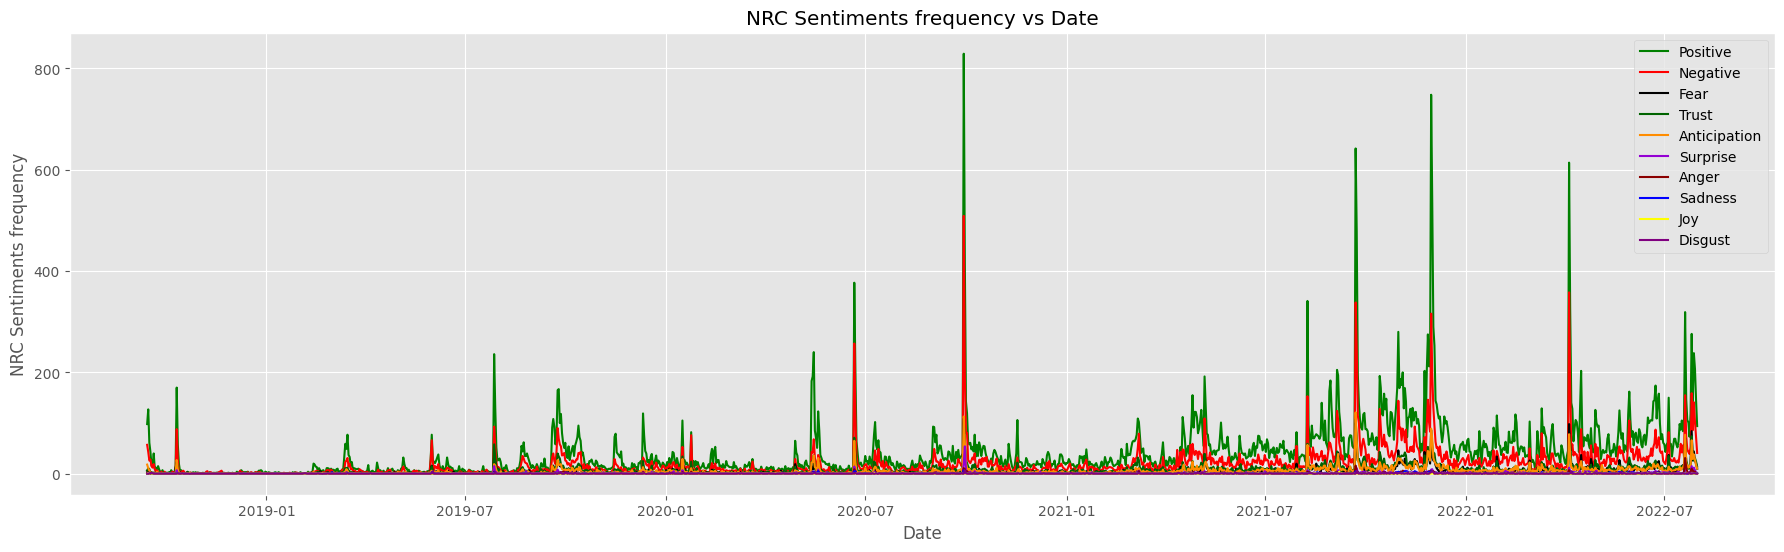

In [ ]:
# Slide 95-97
# Make comment_date the same date, excluding time for grouping
yt_lex_grped_date_sentiment = yt_lex_to_grp.filter(pl.col("NRC_Sentiment_List") == 1).filter(pl.col("NRC_Sentiment_List") == 1).groupby("comment_date", "NRC_Sentiments").agg(pl.count('body').alias('num_sentiment_comments').cast(pl.UInt32))

all_sentiments = ["fear", "anger", "anticipation", "trust", "surprise", "positive", "negative", "sadness", "disgust", "joy"]
missing_sentiments = []
day_sentiments = []
current_date = yt_lex_grped_date_sentiment["comment_date"].min()
counter = 0

for comment_date, sentiment, num_comments in yt_lex_grped_date_sentiment.sort("comment_date").iter_rows():
  counter += 1
  if len(day_sentiments) != len(all_sentiments):
    # Last one, will end with less than 10 since no more rows to iterate
    if counter == 7893:
      day_sentiments.append(sentiment)
      current_date = None

    if comment_date != current_date:
      for s in all_sentiments:
        if s not in day_sentiments:
          missing_sentiments.append({"comment_date": current_date,
                                     "NRC_Sentiments": s,
                                     "num_sentiment_comments": 0})
      day_sentiments = []
      day_sentiments.append(sentiment)
      current_date = comment_date
    else:
      day_sentiments.append(sentiment)

  else:
    day_sentiments = []
    day_sentiments.append(sentiment)
    current_date = comment_date
    continue

missing_sentiments_df = pl.from_dicts(missing_sentiments).with_columns(pl.col("comment_date").cast(pl.Datetime(time_unit="us")), pl.col("NRC_Sentiments").cast(pl.Categorical), pl.col("num_sentiment_comments").cast(pl.UInt32))
yt_lex_grped_date_sentiment_filled = pl.concat([yt_lex_grped_date_sentiment, missing_sentiments_df]).sort("comment_date")
yt_lex_grped_date_sentiment_filled_filtered = yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "positive")
yt_lex_filter_anticip = yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "anticipation")
yt_lex_filter_anticip_sorted = yt_lex_filter_anticip.sort("num_sentiment_comments").tail(10)

mplt.figure(figsize=(22, 6))
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled_filtered["num_sentiment_comments"], color='green', label="Positive")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "negative")["num_sentiment_comments"], color='red', label="Negative")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "fear")["num_sentiment_comments"],  color='black', label="Fear")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "trust")["num_sentiment_comments"], color='darkgreen', label="Trust")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_filter_anticip["num_sentiment_comments"], color='darkorange', label="Anticipation")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "surprise")["num_sentiment_comments"], color='darkviolet', label="Surprise")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "anger")["num_sentiment_comments"], color='darkred', label="Anger")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "sadness")["num_sentiment_comments"], color='blue', label="Sadness")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "joy")["num_sentiment_comments"], color='yellow', label="Joy")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "disgust")["num_sentiment_comments"], color='purple', label="Disgust")

mplt.xlabel('Date')
mplt.ylabel('NRC Sentiments frequency')
mplt.title('NRC Sentiments frequency vs Date')
mplt.legend()
mplt.show()

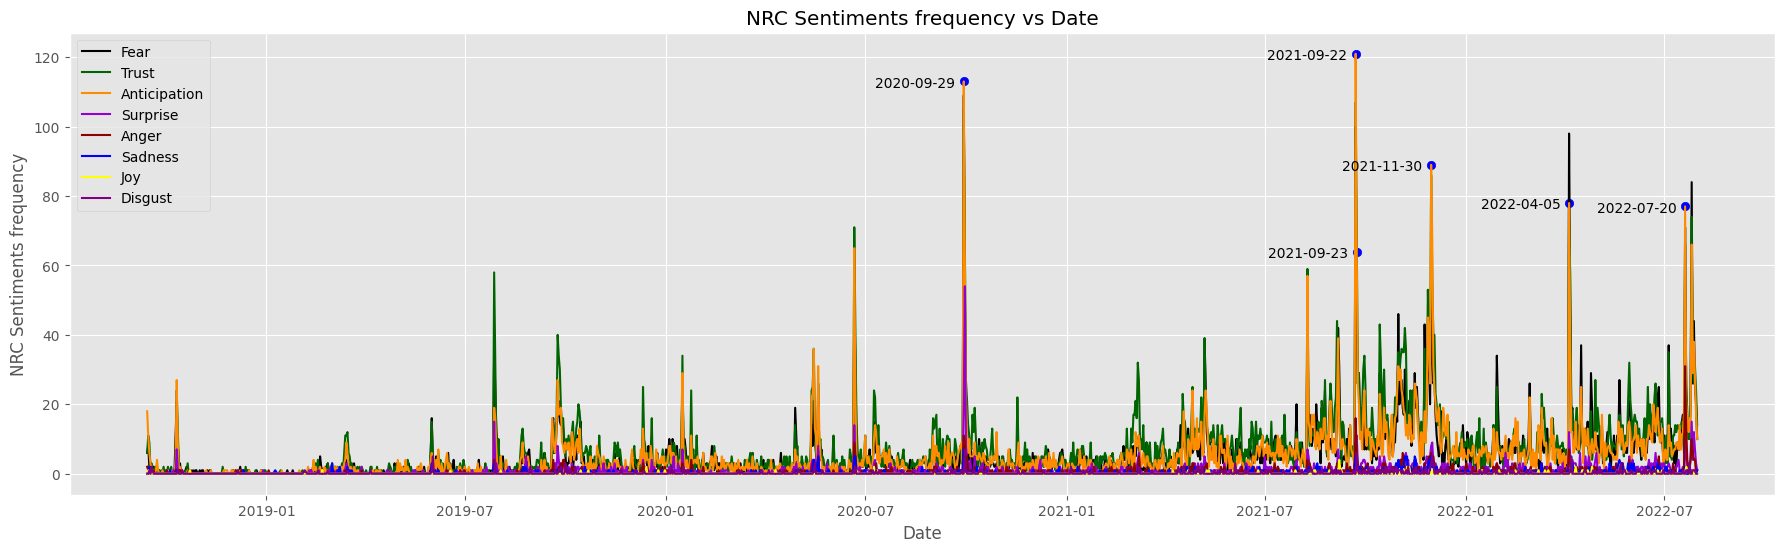

In [ ]:
mplt.figure(figsize=(22, 6))
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "fear")["num_sentiment_comments"],  color='black', label="Fear")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "trust")["num_sentiment_comments"], color='darkgreen', label="Trust")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_filter_anticip["num_sentiment_comments"], color='darkorange', label="Anticipation")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "surprise")["num_sentiment_comments"], color='darkviolet', label="Surprise")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "anger")["num_sentiment_comments"], color='darkred', label="Anger")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "sadness")["num_sentiment_comments"], color='blue', label="Sadness")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "joy")["num_sentiment_comments"], color='yellow', label="Joy")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "disgust")["num_sentiment_comments"], color='purple', label="Disgust")

for i, (comment_date, sentiment, num_comments) in enumerate(yt_lex_filter_anticip_sorted.iter_rows()):
  if i in [1, 5, 6, 7, 8, 9]:
    annotate(text=comment_date.strftime('%Y-%m-%d'),
            xy=(comment_date, num_comments),
            xy_offset=(-35, -4))
    mplt.scatter(comment_date, num_comments, color="blue")

mplt.xlabel('Date')
mplt.ylabel('NRC Sentiments frequency')
mplt.title('NRC Sentiments frequency vs Date')
mplt.legend()
mplt.show()

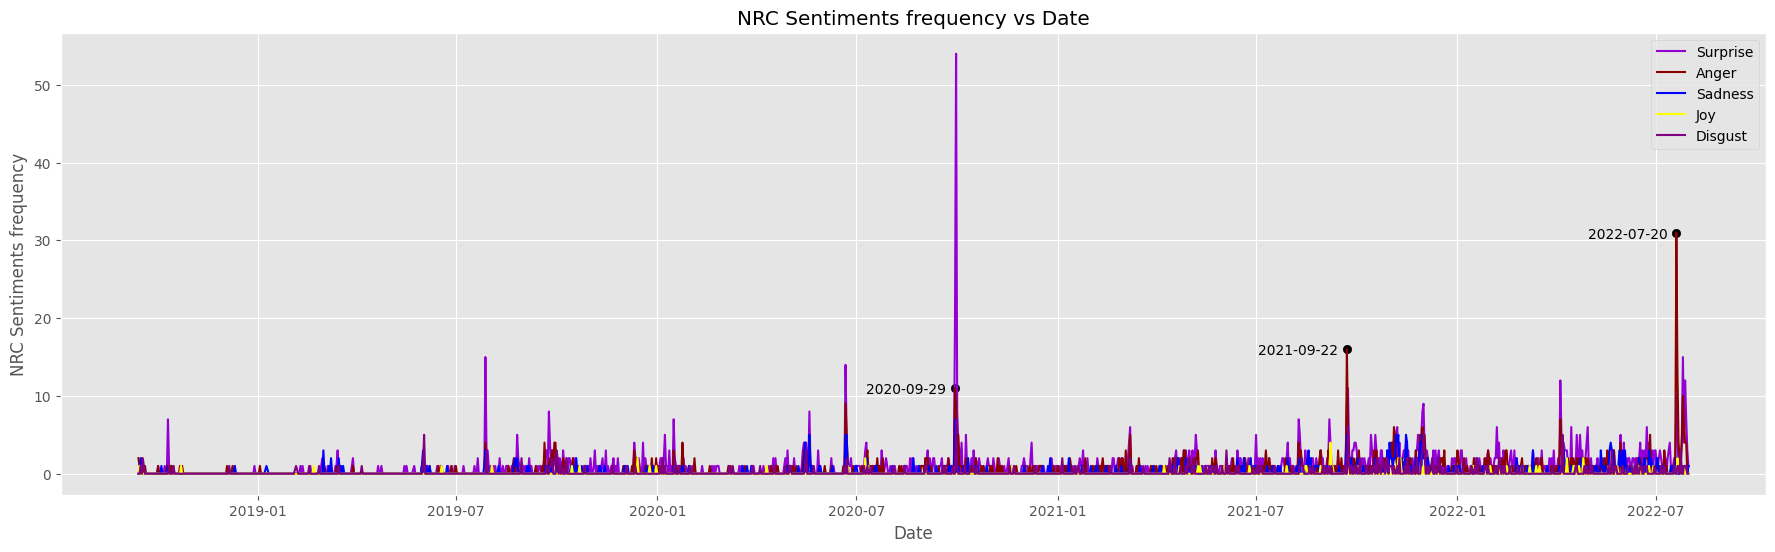

In [ ]:
yt_lex_filter_anger = yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "anger")
yt_lex_filter_anger_sorted = yt_lex_filter_anger.sort("num_sentiment_comments").tail(4)

mplt.figure(figsize=(22, 6))
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "surprise")["num_sentiment_comments"], color='darkviolet', label="Surprise")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_filter_anger["num_sentiment_comments"], color='darkred', label="Anger")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "sadness")["num_sentiment_comments"], color='blue', label="Sadness")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "joy")["num_sentiment_comments"], color='yellow', label="Joy")
mplt.plot(yt_lex_grped_date_sentiment_filled_filtered["comment_date"], yt_lex_grped_date_sentiment_filled.filter(pl.col("NRC_Sentiments") == "disgust")["num_sentiment_comments"], color='purple', label="Disgust")

for i, (comment_date, sentiment, num_comments) in enumerate(yt_lex_filter_anger_sorted.iter_rows()):
  if i in [0, 2, 3]:
    annotate(text=comment_date.strftime('%Y-%m-%d'),
            xy=(comment_date, num_comments),
            xy_offset=(-35, -4))
    mplt.scatter(comment_date, num_comments, color="black")

mplt.xlabel('Date')
mplt.ylabel('NRC Sentiments frequency')
mplt.title('NRC Sentiments frequency vs Date')
mplt.legend()
mplt.show()

#### Sentence-based Sentiment (VADER, Flair)

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
# !pip install flair
from flair.data import Sentence
from flair.nn import Classifier

# Most models suggest splitting up into sentences as they are trained on individual sentences, but this is both less accurate and more computationally intensive.
# Can take up to 200 words
def split_text_by_word_limit(text: str, word_limit: int = 200) -> list:
  sentences = nltk.sent_tokenize(text)
  paragraphs = []
  current_paragraph = []
  current_word_count = 0
  for sentence in sentences:
      words = sentence.split()
      sentence_word_count = len(words)
      if current_word_count + sentence_word_count > word_limit:
          paragraphs.append(" ".join(current_paragraph))
          #  Resetting
          current_paragraph = []
          current_word_count = 0
      current_paragraph.append(sentence)
      current_word_count += sentence_word_count
  if current_paragraph:
      paragraphs.append(" ".join(current_paragraph))
  return paragraphs

def get_sentence_score(paragraphs: list) -> tuple:
  vaders = []
  flairs = []
  for paragraph in paragraphs:
    vaders.append(vader.polarity_scores(paragraph)["compound"])

    sentence = Sentence(paragraph)
    flair.predict(sentence)
    try:
      if "POSITIVE" in str(sentence):
        flairs.append(sentence.score)
      else:
        flairs.append(sentence.score * -1)
    except:
      flairs.append(0)

  # Up to 200 words
  if len(vaders) == 1:
        most_polar_vader = vaders[0]
        most_polar_flair = flairs[0]
  else:
      # If need to be broken up into paragraphs, take the most extreme/polar sentiment
      if abs(min(vaders)) >= max(vaders):
          most_polar_vader = min(vaders)
      else:
          most_polar_vader = max(vaders)

      if abs(min(flairs)) >= max(flairs):
          most_polar_flair = min(flairs)
      else:
          most_polar_flair = max(flairs)

  return round(most_polar_vader, 2), round(most_polar_flair, 2)

vader = SentimentIntensityAnalyzer()
flair = Classifier.load('sentiment-fast')
yt_sentence = yt_lex.with_columns(
    pl.col("body").apply(split_text_by_word_limit).apply(get_sentence_score).alias("VADER_FLAIR"),
)
yt_sentence = yt_sentence.select(
    pl.all().exclude("VADER_FLAIR"),
    pl.col("VADER_FLAIR").apply(lambda x: x[0]).alias("VADER").cast(pl.Float32),
    pl.col("VADER_FLAIR").apply(lambda x: x[1]).alias("FLAIR").cast(pl.Float32),
)
yt_sentence

shape: (259_316, 11)
┌────────────┬───────────────┬──────────────┬──────────────┬───┬──────┬────────────┬───────┬───────┐
│ comment_da ┆ id            ┆ link         ┆ body         ┆ … ┆ NRC  ┆ NRC_Sentim ┆ VADER ┆ FLAIR │
│ te         ┆ ---           ┆ ---          ┆ ---          ┆   ┆ ---  ┆ ents       ┆ ---   ┆ ---   │
│ ---        ┆ cat           ┆ cat          ┆ str          ┆   ┆ f32  ┆ ---        ┆ f32   ┆ f32   │
│ datetime[μ ┆               ┆              ┆              ┆   ┆      ┆ cat        ┆       ┆       │
│ s]         ┆               ┆              ┆              ┆   ┆      ┆            ┆       ┆       │
╞════════════╪═══════════════╪══════════════╪══════════════╪═══╪══════╪════════════╪═══════╪═══════╡
│ 2018-09-14 ┆ null          ┆ https://www. ┆ kikivoorburg ┆ … ┆ 0.0  ┆ fear,      ┆ 0.59  ┆ -0.79 │
│ 00:00:00   ┆               ┆ youtube.com/ ┆ wow 😮 it’s  ┆   ┆      ┆ anger,     ┆       ┆       │
│            ┆               ┆ watch?v=…    ┆ only 9:3…    ┆   ┆      ┆ anticip,   ┆       ┆       │
│            ┆               ┆              ┆              ┆   ┆      ┆ trust,     ┆       ┆       │
│            ┆               ┆              ┆              ┆   ┆      ┆ sur…       ┆       ┆       │
│ 2018-09-14 ┆ UgxVCO1BnALI6 ┆ https://www. ┆ The earth    ┆ … ┆ 0.0  ┆ fear,      ┆ 0.0   ┆ 0.67  │
│ 00:00:00   ┆ YO7Vp54AaABAg ┆ youtube.com/ ┆ has already  ┆   ┆      ┆ anger,     ┆       ┆       │
│            ┆               ┆ watch?v=…    ┆ done it...…  ┆   ┆      ┆ positive,  ┆       ┆       │
│            ┆               ┆              ┆              ┆   ┆      ┆ negative,… ┆       ┆       │
│ 2018-09-14 ┆ UgwJvvwa6Asyq ┆ https://www. ┆ Oh,          ┆ … ┆ -1.0 ┆ trust      ┆ -0.18 ┆ -0.87 │
│ 00:00:00   ┆ P4qsVp4AaABAg ┆ youtube.com/ ┆ <i>your</i>  ┆   ┆      ┆            ┆       ┆       │
│            ┆               ┆ watch?v=…    ┆ country is   ┆   ┆      ┆            ┆       ┆       │
│            ┆               ┆              ┆ going…       ┆   ┆      ┆            ┆       ┆       │
│ 2018-09-14 ┆ UgwisLALVH9y0 ┆ https://www. ┆ real         ┆ … ┆ 1.0  ┆ trust,     ┆ 0.0   ┆ 1.0   │
│ 00:00:00   ┆ uQ9mBh4AaABAg ┆ youtube.com/ ┆ enginering   ┆   ┆      ┆ positive   ┆       ┆       │
│            ┆               ┆ watch?v=…    ┆ give me a    ┆   ┆      ┆            ┆       ┆       │
│            ┆               ┆              ┆ heart        ┆   ┆      ┆            ┆       ┆       │
│ 2018-09-14 ┆ UgyXIdjDb-dyw ┆ https://www. ┆ I&#39;m a    ┆ … ┆ 1.0  ┆ anticipati ┆ 0.36  ┆ 0.89  │
│ 00:00:00   ┆ s7Irsd4AaABAg ┆ youtube.com/ ┆ simple man.  ┆   ┆      ┆ on         ┆       ┆       │
│            ┆               ┆ watch?v=…    ┆ I see a ne…  ┆   ┆      ┆            ┆       ┆       │
│ …          ┆ …             ┆ …            ┆ …            ┆ … ┆ …    ┆ …          ┆ …     ┆ …     │
│ 2022-07-31 ┆ null          ┆ https://www. ┆ In the last  ┆ … ┆ 1.0  ┆ positive   ┆ -0.21 ┆ -0.96 │
│ 00:00:00   ┆               ┆ youtube.com/ ┆ few thousand ┆   ┆      ┆            ┆       ┆       │
│            ┆               ┆ watch?v=…    ┆ years g…     ┆   ┆      ┆            ┆       ┆       │
│ 2022-07-31 ┆ null          ┆ https://www. ┆ @Cyrribrae   ┆ … ┆ -2.0 ┆ negative   ┆ -0.74 ┆ -0.93 │
│ 00:00:00   ┆               ┆ youtube.com/ ┆ "Humans      ┆   ┆      ┆            ┆       ┆       │
│            ┆               ┆ watch?v=…    ┆ can't afford ┆   ┆      ┆            ┆       ┆       │
│            ┆               ┆              ┆ …            ┆   ┆      ┆            ┆       ┆       │
│ 2022-07-31 ┆ null          ┆ https://www. ┆ @Ivor        ┆ … ┆ 1.0  ┆ surprise,  ┆ 0.46  ┆ 0.54  │
│ 00:00:00   ┆               ┆ youtube.com/ ┆ Chandler How ┆   ┆      ┆ positive,  ┆       ┆       │
│            ┆               ┆ watch?v=…    ┆ about you    ┆   ┆      ┆ anticipati ┆       ┆       │
│            ┆               ┆              ┆ che…         ┆   ┆      ┆ on         ┆       ┆       │
│ 2022-07-31 ┆ UgyPmlgZqcwlO ┆ https://ww

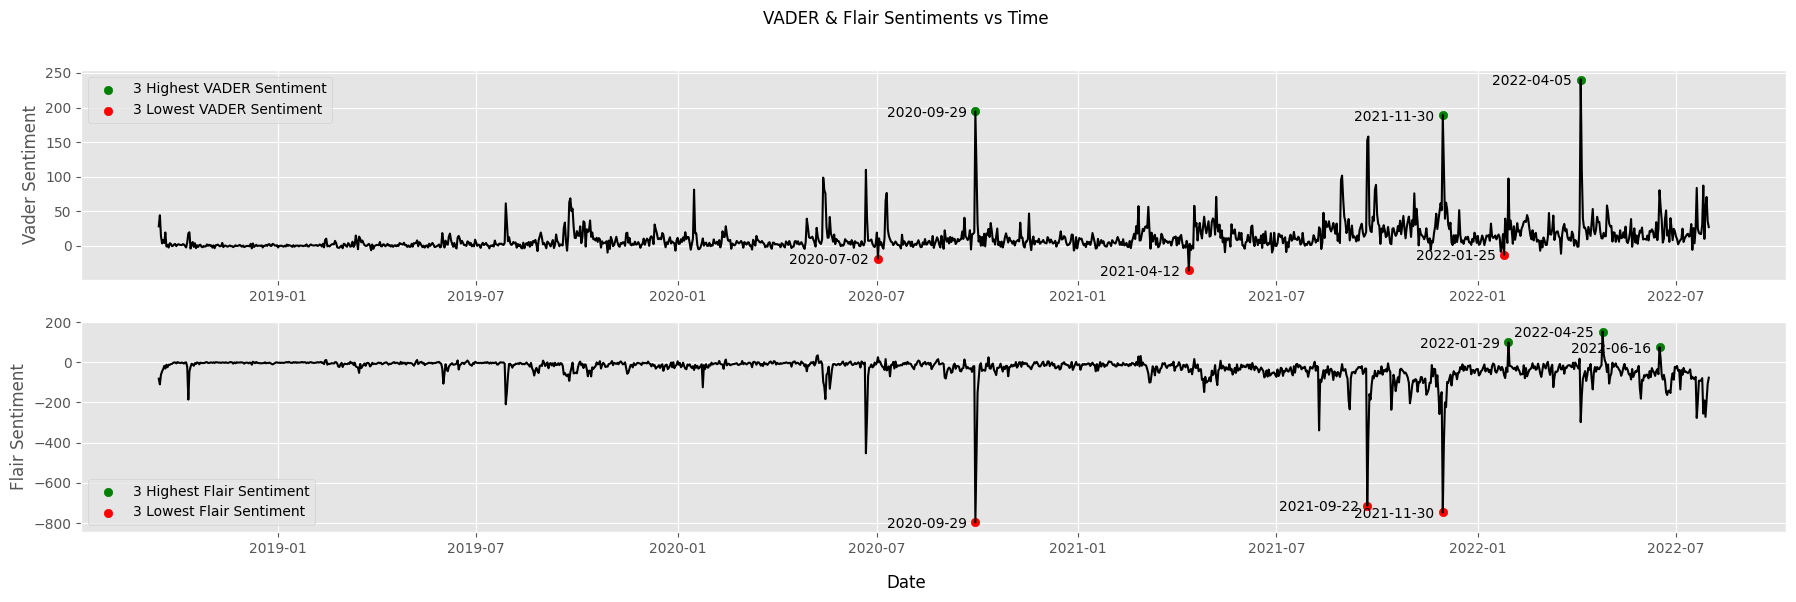

In [ ]:
# Slide 98
yt_sentence_vader_sum = yt_sentence.groupby_dynamic('comment_date', every="1d").agg(pl.col('VADER').sum().alias("vader_sum"))
yt_sentence_flair_sum = yt_sentence.groupby_dynamic('comment_date', every="1d").agg(pl.col('FLAIR').sum().alias("flair_sum"))
vader_date_sorted = yt_sentence_vader_sum.sort("vader_sum")
vader_date_filtered_high = vader_date_sorted.tail(3)
vader_date_filtered_low = vader_date_sorted.head(3)
flair_date_sorted = yt_sentence_flair_sum.sort("flair_sum")
flair_date_filtered_high = flair_date_sorted.tail(3)
flair_date_filtered_low = flair_date_sorted.head(3)

fig, axes = mplt.subplots(2, 1, figsize=(22, 6))
axes[0].plot(yt_sentence_vader_sum["comment_date"], yt_sentence_vader_sum["vader_sum"], color='black')
axes[0].scatter(vader_date_filtered_high["comment_date"], vader_date_filtered_high["vader_sum"], color='green', label="3 Highest VADER Sentiment")
axes[0].scatter(vader_date_filtered_low["comment_date"], vader_date_filtered_low["vader_sum"], color='red', label="3 Lowest VADER Sentiment")
axes[0].set_ylabel('Vader Sentiment')
axes[0].legend()
axes[1].plot(yt_sentence_flair_sum["comment_date"], yt_sentence_flair_sum["flair_sum"], color='black')
axes[1].scatter(flair_date_filtered_high["comment_date"], flair_date_filtered_high["flair_sum"], color='green', label="3 Highest Flair Sentiment")
axes[1].scatter(flair_date_filtered_low["comment_date"], flair_date_filtered_low["flair_sum"], color='red', label="3 Lowest Flair Sentiment")
axes[1].set_ylabel('Flair Sentiment')
axes[1].legend()
fig.supxlabel("Date")
mplt.suptitle("VADER & Flair Sentiments vs Time")

for filtered_df, ax in [(vader_date_filtered_high, axes[0]), (vader_date_filtered_low, axes[0]), (flair_date_filtered_high, axes[1]), (flair_date_filtered_low, axes[1])]:
    for comment_date, sentiment in filtered_df.iter_rows():
      annotate(text=comment_date.strftime('%Y-%m-%d'),
              xy=(comment_date, sentiment),
              xy_offset=(-35, -4), ax=ax)

mplt.show()

#### In-depth toxicity analysis (Perspective API)

In [ ]:
yt_sentence = yt_sentence.filter((pl.col("VADER") < -0.9) & (pl.col("FLAIR") < -0.9))
yt_sentence = yt_sentence.filter(~yt_sentence["body"].is_duplicated())
yt_sentence

shape: (3_826, 11)
┌────────────┬──────────────┬──────────────┬──────────────┬───┬───────┬────────────┬───────┬───────┐
│ comment_da ┆ id           ┆ link         ┆ body         ┆ … ┆ NRC   ┆ NRC_Sentim ┆ VADER ┆ FLAIR │
│ te         ┆ ---          ┆ ---          ┆ ---          ┆   ┆ ---   ┆ ents       ┆ ---   ┆ ---   │
│ ---        ┆ cat          ┆ cat          ┆ str          ┆   ┆ f32   ┆ ---        ┆ f32   ┆ f32   │
│ datetime[μ ┆              ┆              ┆              ┆   ┆       ┆ cat        ┆       ┆       │
│ s]         ┆              ┆              ┆              ┆   ┆       ┆            ┆       ┆       │
╞════════════╪══════════════╪══════════════╪══════════════╪═══╪═══════╪════════════╪═══════╪═══════╡
│ 2018-09-14 ┆ null         ┆ https://www. ┆ This video   ┆ … ┆ -3.0  ┆ negative   ┆ -0.96 ┆ -1.0  │
│ 00:00:00   ┆              ┆ youtube.com/ ┆ is           ┆   ┆       ┆            ┆       ┆       │
│            ┆              ┆ watch?v=…    ┆ simplifying  ┆   ┆       ┆            ┆       ┆       │
│            ┆              ┆              ┆ way to…      ┆   ┆       ┆            ┆       ┆       │
│ 2018-09-14 ┆ null         ┆ https://www. ┆ I get that   ┆ … ┆ -13.0 ┆ negative   ┆ -0.93 ┆ -0.98 │
│ 00:00:00   ┆              ┆ youtube.com/ ┆ relative to  ┆   ┆       ┆            ┆       ┆       │
│            ┆              ┆ watch?v=…    ┆ petroleum…   ┆   ┆       ┆            ┆       ┆       │
│ 2018-09-14 ┆ null         ┆ https://www. ┆ @nikami      ┆ … ┆ -2.0  ┆ fear,      ┆ -0.94 ┆ -0.96 │
│ 00:00:00   ┆              ┆ youtube.com/ ┆ Also,        ┆   ┆       ┆ negative   ┆       ┆       │
│            ┆              ┆ watch?v=…    ┆ Germany has  ┆   ┆       ┆            ┆       ┆       │
│            ┆              ┆              ┆ had a …      ┆   ┆       ┆            ┆       ┆       │
│ 2018-09-14 ┆ null         ┆ https://www. ┆ Actually,    ┆ … ┆ -3.0  ┆ fear       ┆ -0.95 ┆ -0.98 │
│ 00:00:00   ┆              ┆ youtube.com/ ┆ the          ┆   ┆       ┆            ┆       ┆       │
│            ┆              ┆ watch?v=…    ┆ fukushima    ┆   ┆       ┆            ┆       ┆       │
│            ┆              ┆              ┆ disaster…    ┆   ┆       ┆            ┆       ┆       │
│ 2018-09-14 ┆ UgwS8kw7zbpN ┆ https://www. ┆ One of the   ┆ … ┆ -12.0 ┆ negative   ┆ -0.94 ┆ -1.0  │
│ 00:00:00   ┆ emlk_cR4AaAB ┆ youtube.com/ ┆ largest      ┆   ┆       ┆            ┆       ┆       │
│            ┆ Ag           ┆ watch?v=…    ┆ problems     ┆   ┆       ┆            ┆       ┆       │
│            ┆              ┆              ┆ that…        ┆   ┆       ┆            ┆       ┆       │
│ …          ┆ …            ┆ …            ┆ …            ┆ … ┆ …     ┆ …          ┆ …     ┆ …     │
│ 2022-07-31 ┆ null         ┆ https://www. ┆ @Kryptonarie ┆ … ┆ -2.0  ┆ negative   ┆ -0.91 ┆ -1.0  │
│ 00:00:00   ┆              ┆ youtube.com/ ┆ 63 In a      ┆   ┆       ┆            ┆       ┆       │
│            ┆              ┆ watch?v=…    ┆ stunning de… ┆   ┆       ┆            ┆       ┆       │
│ 2022-07-31 ┆ null         ┆ https://www. ┆ A primer on  ┆ … ┆ 0.0   ┆ positive,  ┆ -0.96 ┆ -1.0  │
│ 00:00:00   ┆              ┆ youtube.com/ ┆ climate      ┆   ┆       ┆ negative   ┆       ┆       │
│            ┆              ┆ watch?v=…    ┆ quackery     ┆   ┆       ┆            ┆       ┆       │
│            ┆              ┆              ┆              ┆   ┆       ┆            ┆       ┆       │
│            ┆              ┆              ┆ CO…          ┆   ┆       ┆            ┆       ┆       │
│ 2022-07-31 ┆ null         ┆ https://www. ┆ That region  ┆ … ┆ -2.0  ┆ negative,  ┆ -0.95 ┆ -0.95 │
│ 00:00:00   ┆              ┆ youtube.com/ ┆ needs to     ┆   ┆       ┆ sadness    ┆       ┆       │
│            ┆              ┆ watch?v=…    ┆ deal with t… ┆   ┆       ┆            ┆       ┆       │
│ 2022-07-31 ┆ null         ┆ https://www. ┆ Jason Taylor ┆ … ┆ -2.0  ┆ negative   ┆ -0.98 ┆ -1.0  │
│ 00:00:00   ┆              ┆ youtube.com/

In [ ]:
from googleapiclient import discovery
import time

API_KEY = '...'
client = discovery.build(
    "commentanalyzer",
    "v1alpha1",
    developerKey=API_KEY,
    discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
    static_discovery=False,
)
perspectives = {'FLIRTATION': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'IDENTITY_ATTACK': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'INSULT': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'PROFANITY': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'SEVERE_TOXICITY': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'SEXUALLY_EXPLICIT': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'THREAT': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0},
                'TOXICITY': {"scoreType": "PROBABILITY", "scoreThreshold": 0.0}
                }


def perspective_analyze(text: str, API_KEY=None) -> list:
    global client
    if API_KEY:
        client = discovery.build(
            "commentanalyzer",
            "v1alpha1",
            developerKey=API_KEY,
            discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
            static_discovery=False,
        )
    req = {
        'comment': {'text': text, 'type': 'PLAIN_TEXT'},
        'requestedAttributes': perspectives,
        # "languages": ["en"]
    }
    try:
        response = client.comments().analyze(body=req).execute()
        result = [round(attrib_v["summaryScore"]["value"], 2) for attrib_k, attrib_v in sorted(
            response["attributeScores"].items())]
    except Exception as e:
        if "LANGUAGE_NOT_SUPPORTED_BY_ATTRIBUTE" in str(e):
            return [None for i in range(8)]
        time.sleep(5)
        result = perspective_analyze(
            text, "...")
    return result

yt_perspective = yt_sentence.with_columns(
    pl.col("body").apply(perspective_analyze).alias("perspectives"),
)

yt_perspective = yt_perspective.select(
    pl.all().exclude("perspectives"),
    pl.col("perspectives").apply(lambda x: x[0]).alias(
        "FLIRTATION").cast(pl.Float32),
    pl.col("perspectives").apply(lambda x: x[1]).alias(
        "IDENTITY_ATTACK").cast(pl.Float32),
    pl.col("perspectives").apply(lambda x: x[2]).alias(
        "INSULT").cast(pl.Float32),
    pl.col("perspectives").apply(lambda x: x[3]).alias(
        "PROFANITY").cast(pl.Float32),
    pl.col("perspectives").apply(lambda x: x[4]).alias(
        "SEVERE_TOXICITY").cast(pl.Float32),
    pl.col("perspectives").apply(lambda x: x[5]).alias(
        "SEXUALLY_EXPLICIT").cast(pl.Float32),
    pl.col("perspectives").apply(lambda x: x[6]).alias(
        "THREAT").cast(pl.Float32),
    pl.col("perspectives").apply(lambda x: x[7]).alias(
        "TOXICITY").cast(pl.Float32),
)
yt_perspective

shape: (3_826, 19)
┌────────────┬───────────┬───────────┬───────────┬───┬────────────┬────────────┬────────┬──────────┐
│ comment_da ┆ id        ┆ link      ┆ body      ┆ … ┆ SEVERE_TOX ┆ SEXUALLY_E ┆ THREAT ┆ TOXICITY │
│ te         ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ICITY      ┆ XPLICIT    ┆ ---    ┆ ---      │
│ ---        ┆ cat       ┆ cat       ┆ str       ┆   ┆ ---        ┆ ---        ┆ f32    ┆ f32      │
│ datetime[μ ┆           ┆           ┆           ┆   ┆ f32        ┆ f32        ┆        ┆          │
│ s]         ┆           ┆           ┆           ┆   ┆            ┆            ┆        ┆          │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪════════════╪════════════╪════════╪══════════╡
│ 2018-09-14 ┆ null      ┆ https://w ┆ This      ┆ … ┆ 0.02       ┆ 0.05       ┆ 0.01   ┆ 0.34     │
│ 00:00:00   ┆           ┆ ww.youtub ┆ video is  ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆ e.com/wat ┆ simplifyi ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆ ch?v=…    ┆ ng way    ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆           ┆ to…       ┆   ┆            ┆            ┆        ┆          │
│ 2018-09-14 ┆ null      ┆ https://w ┆ I get     ┆ … ┆ 0.0        ┆ 0.02       ┆ 0.02   ┆ 0.16     │
│ 00:00:00   ┆           ┆ ww.youtub ┆ that      ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆ e.com/wat ┆ relative  ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆ ch?v=…    ┆ to petrol ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆           ┆ eum…      ┆   ┆            ┆            ┆        ┆          │
│ 2018-09-14 ┆ null      ┆ https://w ┆ @nikami   ┆ … ┆ 0.0        ┆ 0.01       ┆ 0.01   ┆ 0.04     │
│ 00:00:00   ┆           ┆ ww.youtub ┆ Also,     ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆ e.com/wat ┆ Germany   ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆ ch?v=…    ┆ has had a ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆           ┆ …         ┆   ┆            ┆            ┆        ┆          │
│ 2018-09-14 ┆ null      ┆ https://w ┆ Actually, ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.01   ┆ 0.02     │
│ 00:00:00   ┆           ┆ ww.youtub ┆ the       ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆ e.com/wat ┆ fukushima ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆ ch?v=…    ┆ disaster… ┆   ┆            ┆            ┆        ┆          │
│ 2018-09-14 ┆ UgwS8kw7z ┆ https://w ┆ One of    ┆ … ┆ 0.0        ┆ 0.01       ┆ 0.01   ┆ 0.06     │
│ 00:00:00   ┆ bpNemlk_c ┆ ww.youtub ┆ the       ┆   ┆            ┆            ┆        ┆          │
│            ┆ R4AaABAg  ┆ e.com/wat ┆ largest   ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆ ch?v=…    ┆ problems  ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆           ┆ that…     ┆   ┆            ┆            ┆        ┆          │
│ …          ┆ …         ┆ …         ┆ …         ┆ … ┆ …          ┆ …          ┆ …      ┆ …        │
│ 2022-07-31 ┆ null      ┆ https://w ┆ @Kryptona ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.01   ┆ 0.04     │
│ 00:00:00   ┆           ┆ ww.youtub ┆ rie 63 In ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆ e.com/wat ┆ a         ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆ ch?v=…    ┆ stunning  ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆           ┆ de…       ┆   ┆            ┆            ┆        ┆          │
│ 2022-07-31 ┆ null      ┆ https://w ┆ A primer  ┆ … ┆ 0.0        ┆ 0.01       ┆ 0.01   ┆ 0.04     │
│ 00:00:00   ┆           ┆ ww.youtub ┆ on        ┆   ┆            ┆            ┆        ┆          │
│            ┆           ┆ e.com/wat ┆ cli

In [ ]:
# See top 5 of each category
for a, b, c, d in yt_perspective.sort("FLIRTATION").select(pl.col("comment_date", "link", "like_count", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2021-06-29 00:00:00 https://www.youtube.com/watch?v=R7FAAfK78_M 0 
 Balbazurk Was Here&quot;Insure and sexually frustrated white males&quot;... WE NEED TO SEE SCIENTIFIC REFERENCES FOR THAT STATEMENT.  NO.... REFILL YOUR SCIENCE CARD BECAUSE YOU&#39;RE OUT OF CREDIT.  IF YOU CANT SHOW SCIENTIFIC REFERENCES FOR SEXUALLY FRUSTRATED WHITE MALES THEN YOUR JUST A SAD HUMAN BEING AND A SCIENCE DENIER.   VALENTINA ZAHRKOVA......remember.....what does it mean when the sun is out of phase....hmmmmm 
2019-06-03 00:00:00 https://www.youtube.com/watch?v=RLqXkYrdmjY 1 
 Add Louder to the list of alt right youtubers who give me raging hate boners. I'd bet mine is bigger than Rational Bear's lol. I srsly never noticed how good looking that douche is before today (bc I hate his guts  >:T) You gotta know the right hires these good looking doucherag bootlickers on purpose so people *will want to look at them, and listen to their garbage.*  They just make me want to wear leather when I smash them. Especi

In [ ]:
for a, b, c, d in yt_perspective.sort("IDENTITY_ATTACK").select(pl.col("comment_date", "link", "like_count", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2021-11-04 00:00:00 https://www.youtube.com/watch?v=Wpy4xBftFuY 0 
 If we really want to address climate change and pollution how much cleaning up India and China? But that will never happen, for two reasons. First, global elites make too damn much money having all their crap manufacture there. Second, nobody really gives a shit in the west about Asians and people in these so-called Third World. Drop a plastic straw in California and I’ll cut your balls off. Pollute whole communities in India and whitey liberals don’t care. 
2021-10-07 00:00:00 https://www.youtube.com/watch?v=q8l-_xKOhBc 2 
 These evangelicals are crazy with their fake rapture and Mark of beast stupid nonsense comments! They use the Bible as a weapon to spread lies! What does meeting to address climate change have to do with rapture? The 40 different religions will never become Catholic and denounce their religion? That is not Pope Francis intention. Where does the Bible talk about climate change or global problems to 

In [ ]:
for a, b, c, d in yt_perspective.sort("INSULT").select(pl.col("comment_date", "link", "like_count", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2021-04-18 00:00:00 https://www.youtube.com/watch?v=NVyM6J2jbAU 0 
 I absolutely hate this idiot Gandhi .... Assholes 
2020-01-24 00:00:00 https://www.youtube.com/watch?v=8RVooYlyl20 0 
 @Nymin hey dumb fuck, it's difference, say what you typed and see how big of a jackass you feel like. Now argue on the side of liberals to show how stupid they are. 
2022-07-28 00:00:00 https://www.youtube.com/watch?v=oRd8T8sVsWE 0 
 @Mcclean Dazza Knock it off with the stupid Trump crap.  Lack of maintenance in a forest?   What, rake the leaves?  The worst fires are caused by severe drought.   Seems everyone knows this except you and the idiot. 
2019-09-21 00:00:00 https://www.youtube.com/watch?v=EXkbdELr4EQ 3 
 C_R_O_M__________ such a blatant fucking idiot. Disagreeing with the thousands of climate scientists globally, with NO evidence WHATSOEVER, arrogant blatant moron - clear case of the dunning Kruger effect. Idiot. 
2019-09-03 00:00:00 https://www.youtube.com/watch?v=pl1Rnz4zNkg 24 
 Stupid,  id

In [ ]:
for a, b, c, d in yt_perspective.sort("PROFANITY").select(pl.col("comment_date", "link", "like_count", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2021-05-09 00:00:00 https://www.youtube.com/watch?v=H787Dj4oMWU 3 
 Fuck You that's the problem, people would much rather die than give up their lifestyle. I mean nobody is going to stop using electricity, it's not going to happen even if the planet explodes, they don't care 
2022-05-31 00:00:00 https://www.youtube.com/watch?v=0KQYNtPl7V4 25 
 WHAT THE FUCK IS CARBON CAPTURE? WHAT ARE EVEN TREES GOD DAMNIT! FUCK I hate this idea that technology will deliver us from... where technology brought us. 
2022-06-01 00:00:00 https://www.youtube.com/watch?v=0KQYNtPl7V4 38 
 You fucking murdered him holy shit. I've never seen someone make such floundering arguments so close to the fire. 
2019-10-11 00:00:00 https://www.youtube.com/watch?v=wRk1p8Lzwvo 4 
 Every single prediction form the last 40 years tfrom experts that support climate change HAS BEEN WRONG.
EVERY FUKIN SINGLE ONE.


So we take their next predictions seriously ? HOW ABOUT YOU GO FUCK YOURSELF YOU FUCKIN IGNORANT PIECE OF UNINTELL

In [ ]:
for a, b, c, d in yt_perspective.sort("SEVERE_TOXICITY").select(pl.col("comment_date", "link", "like_count", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2021-09-29 00:00:00 https://www.youtube.com/watch?v=yiw6_JakZFc 3 
 @Nazmanaebbbz how to describe my entire generation: _uuugh my life sucks everything hurts future is looking bad_


*_FUCK IT .l._*
Decide it already fellas, these are times were you have to get clear wether you wanna keep the fight or just fucking hang yourself, I'm tired of being scared of everything, just fuck it man, I'm depressed as fuck yeah I can't deny it but *_STOP TALKING ABOUT DEPRESSION AS IF IT SHOULD BE THE NORMALITY_* don't let the future scare you damn cowards... Damn.. 
2021-11-15 00:00:00 https://www.youtube.com/watch?v=1zrejG-WI3U 0 
 NOPE...This is still one of the last places you speak your mind and release.  FUCK CNN! FUCK CBS! FUCK ABC! FUCK MSNBC AND EVERYBODY AFFILIATED!!!.......SEE?  2024/ PEACE_BACK_TOGETHER!!! 
2019-10-11 00:00:00 https://www.youtube.com/watch?v=wRk1p8Lzwvo 4 
 Every single prediction form the last 40 years tfrom experts that support climate change HAS BEEN WRONG.
EVERY FUKIN

In [ ]:
for a, b, c, d in yt_perspective.sort("SEXUALLY_EXPLICIT").select(pl.col("comment_date", "link", "like_count", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2021-09-30 00:00:00 https://www.youtube.com/watch?v=ipVxxxqwBQw 3 
 This is the wrong mindset that will doom us all. When are competent ppl gonna be like "Y'know what fuck it y'all don't wanna fix it?", whip their dick on the table and say "Then I'll go first". Even if they don't care the publicity and Historical Headline it will create would he worth it for any sleazy moneybag politician to care about it.

Ppl really are dumb. Just start, don't just point at others. If someone starts, and then laughs at the others for being too incompetent to follow, what y'all think will happen? 
2022-04-22 00:00:00 https://www.youtube.com/watch?v=AVu-vplvCZE 0 
 Damn so no matter what happens the world is doomed anyway it seems. Our least concerns are aliens , meteors , Terrorist, Putin , yellow stone , climate change. Oh who am i kidding let me just watch a new season of hunter hunter before anything happens uuuhhhgggg life sucks ass 
2019-09-05 00:00:00 https://www.youtube.com/watch?v=1zrejG-WI3U 

In [ ]:
for a, b, c, d in yt_perspective.sort("THREAT").select(pl.col("comment_date", "link", "like_count", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2021-11-27 00:00:00 https://www.youtube.com/watch?v=CaLOiGEDPJQ 1 
 Nonsense <br>We should be dead . It&#39;s all survival instinct . It&#39;s nothing like global countries coming together to stop a common problem. 
2019-06-05 00:00:00 https://www.youtube.com/watch?v=RLqXkYrdmjY 51 
 @Living Myth  "Virtually no gun violence" 

Me with my diving suit and a Harpoon gun : I'm about to ruin this man's whole career. 
2020-06-22 00:00:00 https://www.youtube.com/watch?v=ipVxxxqwBQw 0 
 I bet people would rather kill each other to keep their privileges instead of sharing it. People have hated socialism and embracing capitalism. Overcrowding is a real problem and people will kill each other. 
2020-10-17 00:00:00 https://www.youtube.com/watch?v=uqwvf6R1_QY 0 
 veracsthane Don&#39;t know how I missed that but YOU ARE CORECT MY FRIEND !! Commies, commie, commies everywhere. The schools are pumping out little commie soldiers. My own high school is pushing the same lies. I hope those teachers get br

In [ ]:
for a, b, c, d in yt_perspective.sort("TOXICITY").select(pl.col("comment_date", "link", "like_count", "body")).tail(5).iter_rows(): print(a, b, c, "\n", d, "\n==============")

2019-09-21 00:00:00 https://www.youtube.com/watch?v=EXkbdELr4EQ 3 
 C_R_O_M__________ such a blatant fucking idiot. Disagreeing with the thousands of climate scientists globally, with NO evidence WHATSOEVER, arrogant blatant moron - clear case of the dunning Kruger effect. Idiot. 
2020-01-24 00:00:00 https://www.youtube.com/watch?v=8RVooYlyl20 0 
 @Nymin hey dumb fuck, it's difference, say what you typed and see how big of a jackass you feel like. Now argue on the side of liberals to show how stupid they are. 
2019-10-11 00:00:00 https://www.youtube.com/watch?v=wRk1p8Lzwvo 4 
 Every single prediction form the last 40 years tfrom experts that support climate change HAS BEEN WRONG.
EVERY FUKIN SINGLE ONE.


So we take their next predictions seriously ? HOW ABOUT YOU GO FUCK YOURSELF YOU FUCKIN IGNORANT PIECE OF UNINTELLIGENT SHIT. 
2021-04-18 00:00:00 https://www.youtube.com/watch?v=NVyM6J2jbAU 0 
 I absolutely hate this idiot Gandhi .... Assholes 
2019-09-03 00:00:00 https://www.youtube

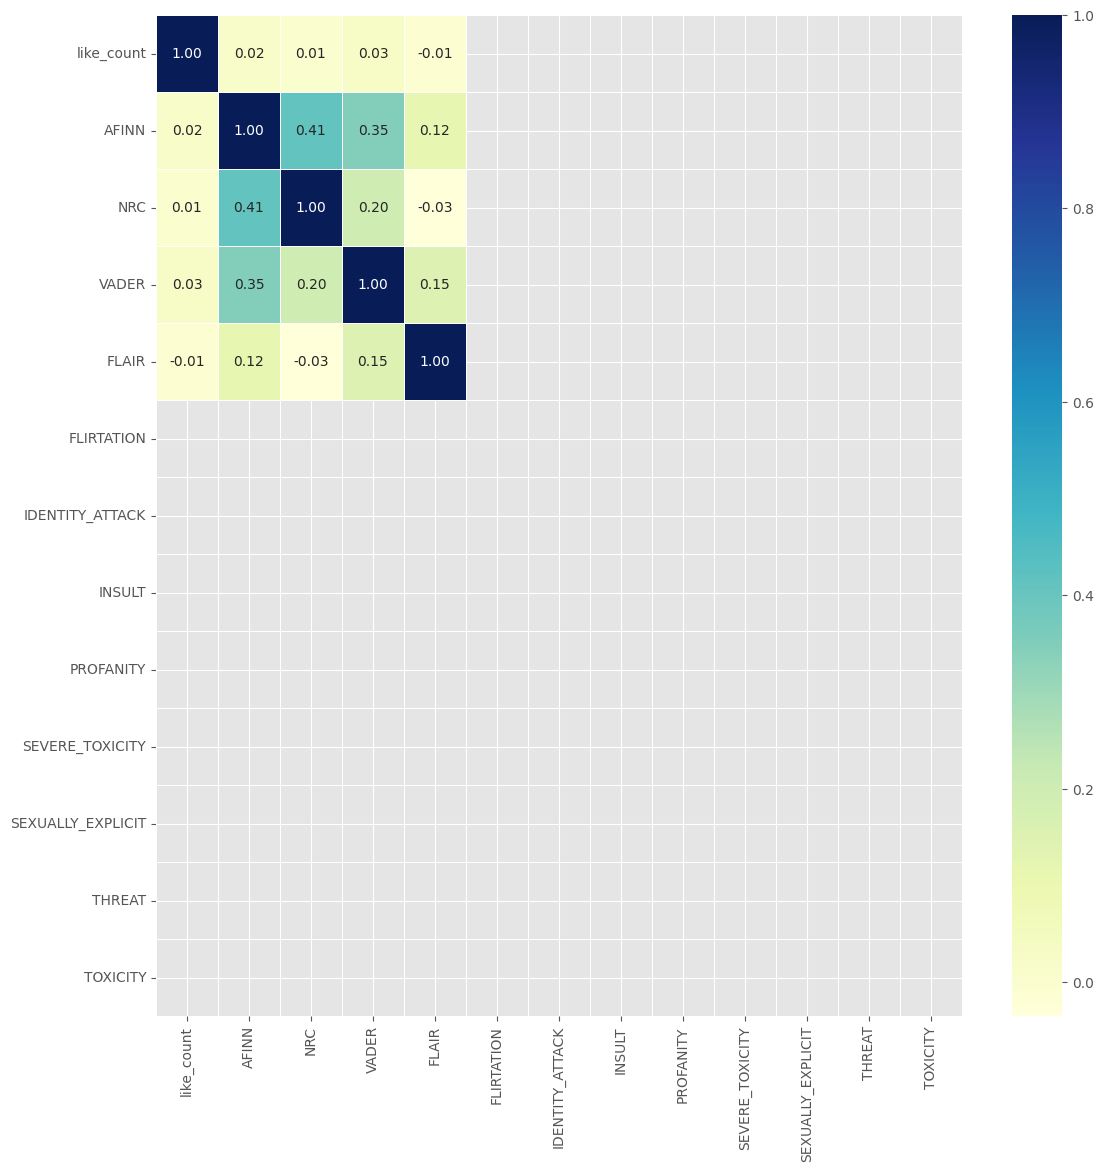

In [ ]:
# Slide 99
# Correlation Heatmap of numerical columns
yt_perspective = yt_perspective.drop(["comment_date", "id", "link", "body", "parentId", "NRC_Sentiments"])
size = len(yt_perspective.columns)
fig, ax = mplt.subplots(figsize=(size, size))
heatmap = sb.heatmap(yt_perspective.corr(), cmap="YlGnBu", linewidths=.5, fmt='.2f', annot=True)
ax.xaxis.set_ticklabels(yt_perspective.columns, rotation=90)
ax.yaxis.set_ticklabels(yt_perspective.columns, rotation=0)
mplt.show()

Perspectives columns seem to be blank (NaN) for this dataset, apparently as a result of many values being the same.

By the formula cor(i,j) = cov(i,j)/[stdev(i)*stdev(j)], the respective standard deviation will be zero and so will the denominator of the fraction. Thus, the correlation will be NaN.

[Reference](https://stackoverflow.com/questions/22655667/dataframe-correlation-produces-nan-although-its-values-are-all-integers/22657319#22657319)

### The End!

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
FOLDERNAME = "Stanford Summer Session/SOC 128D"
FILENAME = "Eco_Emosphere_Code.ipynb"

%cd drive/My\ Drive
%cd $FOLDERNAME
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!pip install PyPDF2

!sudo apt-get install inkscape
!jupyter nbconvert --log-level CRITICAL --to pdf